## Importing Required Libraries.

In [1]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sqlite3
import numpy as np
import sklearn
import datetime
from sklearn.neighbors import KernelDensity
%matplotlib inline
from datetime import time
import miceforest
from miceforest import ImputationKernel
import geopandas as gpd
from shapely.geometry import Point
import folium
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import (SelectKBest, chi2, f_regression)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree

## Establishing Connection To The Accident Database.

In [2]:
con = sqlite3.connect("accident_data_v1.0.0_2023.db")

In [3]:
# Creating a variable that would allow the successful executions of SQL queries.

cur = con.cursor()

## Retrieving Information About The Database Tables.

In [4]:
cur.execute("""
SELECT name
FRom sqlite_master
WHERE type = "table"
""")
table_names = cur.fetchall()
print(f"The name of the tables in accident database are:")
for a in table_names:
    print(a[0])

The name of the tables in accident database are:
accident
casualty
vehicle
lsoa


## Tasks

### 1. Are there significant hours of the day, and days of the week, on which accidents occur?

In [5]:
query_1 = """
SELECT accident_index, date, time, day_of_week, accident_severity, longitude, latitude, speed_limit, light_conditions, weather_conditions,
road_surface_conditions, special_conditions_at_site
FROM accident
WHERE accident_year = 2020
"""

pd.set_option("display.max_columns", None) # Displays all the data series without truncation.
df1 = pd.read_sql(query_1, con)
df1

accident_index        date   time  day_of_week  accident_severity  \
0      2020010219808  04/02/2020  09:00            3                  3   
1      2020010220496  27/04/2020  13:55            2                  3   
2      2020010228005  01/01/2020  01:25            4                  3   
3      2020010228006  01/01/2020  01:50            4                  2   
4      2020010228011  01/01/2020  02:25            4                  3   
...              ...         ...    ...          ...                ...   
91194  2020991027064  12/08/2020  14:30            4                  2   
91195  2020991029573  13/11/2020  15:05            6                  3   
91196  2020991030297  15/04/2020  12:42            4                  2   
91197  2020991030900  15/12/2020  14:00            3                  3   
91198  2020991032575  25/08/2020  13:50            3                  3   

       longitude   latitude  speed_limit  light_conditions  \
0      -0.254001  51.462262           20                 1   
1      -0.139253  51.470327           20                 1   
2      -0.178719  51.529614           30                 4   
3      -0.001683  51.541210           30                 4   
4      -0.137592  51.515704           30                 4   
...          ...        ...          ...               ...   
91194  -2.926320  56.473539           30                 1   
91195  -4.267565  55.802353           30                 1   
91196  -2.271903  57.186317           60                 1   
91197  -3.968753  55.950940           30                 1   
91198  -4.561040  56.003843           30                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       9                        9                           0  
1                       1                        1                           0  
2                       1                        2                           0  
3                       1                        1                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
91194                   1                        1                           0  
91195                   1                        1                           0  
91196                   1                        1                           0  
91197                   1                        1                           0  
91198                   1                        1                           0  

[91199 rows x 12 columns]

### EDA & Data Cleaning for The Columns Relevant to Question 1.

In [6]:
# A function that return the information of a dataframe.

def info_chk(df_info):
    info_chk_res = df_info.info()
    return info_chk_res

In [7]:
# A function that return the non-null value counts information of a dataframe.

def df_null_chk(df_null):
    df_null_chk_res = df_null.isna().sum()
    return df_null_chk_res

In [8]:
# A function that return the describe information of a dataframe.

def df_desc_chk(df_desc):
    df_desc_chk_res = df_desc.describe()
    return df_desc_chk_res

In [9]:
# Retrieving information of dataframe df1.

info_chk(df1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   accident_index              91199 non-null  object 
 1   date                        91199 non-null  object 
 2   time                        91199 non-null  object 
 3   day_of_week                 91199 non-null  int64  
 4   accident_severity           91199 non-null  int64  
 5   longitude                   91185 non-null  float64
 6   latitude                    91185 non-null  float64
 7   speed_limit                 91199 non-null  int64  
 8   light_conditions            91199 non-null  int64  
 9   weather_conditions          91199 non-null  int64  
 10  road_surface_conditions     91199 non-null  int64  
 11  special_conditions_at_site  91199 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 8.3+ MB


In [10]:
# Retrieving information of dataframe df1.

df_null_chk(df1)

accident_index                 0
date                           0
time                           0
day_of_week                    0
accident_severity              0
longitude                     14
latitude                      14
speed_limit                    0
light_conditions               0
weather_conditions             0
road_surface_conditions        0
special_conditions_at_site     0
dtype: int64

In [11]:
# Retrieving the describe information of dataframe df1.

df_desc_chk(df1)

day_of_week  accident_severity     longitude      latitude  \
count  91199.000000       91199.000000  91185.000000  91185.000000   
mean       4.121558           2.768232     -1.189258     52.351073   
std        1.932200           0.456682      1.367786      1.327573   
min        1.000000           1.000000     -7.497375     49.970479   
25%        2.000000           3.000000     -2.107789     51.457237   
50%        4.000000           3.000000     -1.046912     51.763385   
75%        6.000000           3.000000     -0.125238     53.297386   
max        7.000000           3.000000      1.756257     60.541144   

        speed_limit  light_conditions  weather_conditions  \
count  91199.000000      91199.000000        91199.000000   
mean      36.270113          2.065308            1.702047   
std       13.896032          1.747690            1.845786   
min       -1.000000         -1.000000           -1.000000   
25%       30.000000          1.000000            1.000000   
50%       30.000000          1.000000            1.000000   
75%       40.000000          4.000000            1.000000   
max       70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             91199.000000                91199.000000  
mean                  1.391583                    0.244740  
std                   0.925690                    1.318554  
min                  -1.000000                   -1.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

In [12]:
# A function that check if a dataframe column is blank or has value None.

def ds_empty_chk(df_empty, ds_empty):
    empty_chk_res = ((df_empty[ds_empty] == "None") | (df_empty[ds_empty] == "")).sum()
    return empty_chk_res

In [13]:
# A function that returns the uniqye values a dataframe column.

def ds_unique_chk(df_empty, ds_empty):
    unique_chk_res = df_empty[ds_empty].unique()
    return unique_chk_res

#### Date

In [14]:
# Checking if the date column has any blank records or None values.

ds_empty_chk(df1, "date")

0

#### Time

In [15]:
# Checking if the time data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "time")

0

#### Day of Week

In [16]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "day_of_week")

0

In [17]:
# Retrieving the unique values of the day_of_week column.

ds_unique_chk(df1, "day_of_week")

array([3, 2, 4, 5, 6, 7, 1], dtype=int64)

#### Accident Severity

In [18]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "accident_severity")

0

In [19]:
# Retrieving the unique values of the accident_severity column.

ds_unique_chk(df1, "accident_severity")

array([3, 2, 1], dtype=int64)

#### Longitude And Latitude

In [20]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "longitude")

0

In [21]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "latitude")

0

Multiple Imputation by Chain Equation will be used to geneate and impute missing values in the longitude and latitude columns.

#### Speed Limit

In [22]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "speed_limit")

0

In [23]:
# Retrieving the unique values of the day_of_week column.

ds_unique_chk(df1, "speed_limit")

array([20, 30, 40, 50, 60, 70, -1], dtype=int64)

In [24]:
# A function that retrieves all records with speed limit of -1.

def sp_limit(df_sp_limit):
    sp_limit_res = (df_sp_limit["speed_limit"] == -1)
    df_sp_limit.loc[sp_limit_res, "speed_limit"] = np.nan

In [25]:
# Changing all records with speed limit of -1 to NaN inorder to implement Multiple Imputation by Chain Equation (MICE).

sp_limit(df1)

#### Light Conditions

In [26]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "light_conditions")

0

In [27]:
# Retrieving the unique values of the light_conditions column.

ds_unique_chk(df1, "light_conditions")

array([ 1,  4,  5,  7,  6, -1], dtype=int64)

In [28]:
# Retrieving the record where light conditions is -1, a value that is incorrect.

df1[df1["light_conditions"] == -1]

accident_index        date   time  day_of_week  accident_severity  \
79777  2020520002488  24/06/2020  01:15            4                  1   

       longitude   latitude  speed_limit  light_conditions  \
79777  -2.809007  51.288686         60.0                -1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
79777                  -1                       -1                          -1

In [29]:
"""
The time of the accident is 01:15 (midnight) which means the light condition would be dark.
The exact location of the accident is on A371 Road located in Axbridge, Somerser this information was confirmed with... 
... Google Maps (Google, 2023).
A371 is a primary road leading to several cities and towns. However, such road are usually unlit as street lights are....
....only available in part of the road where there settlements.
For this reason the possibility of that the light conditions is Darkness: no street lighting (6) is very high.
"""

df1.loc[79777, "light_conditions"] = 6 # Replaced -1 with 6.

#### Special Conditions at Site

In [30]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "special_conditions_at_site")

0

In [31]:
# Retrieving the unique values of the special_conditions_at_site column.

ds_unique_chk(df1, "special_conditions_at_site")

array([ 0,  9,  2,  4,  5,  1,  3,  6,  7, -1], dtype=int64)

In [32]:
"""
Mapping the days of the week to their respective number code. (Pandas Map, Explained - Sharp Sight, 2022).
The stat19 document indicated that Sunday is the first day of the week.

For better visualization some interpretation of the following special conditions at site codes were abbreviated:
1) Auto Traffic Signal Out: ATSO.
2) Auto Traffic Signal Partially Defective: ATSPD.
3) Permanent Road Signing or Marking Defective or Obscured: PRS/MD/O.
4) Road Surface Defective: RSD.
"""

scas_mapping = {-1: "-1", 
                0 : "None", 
                1: "ATSO", 
                2 : "ATSPD", 
                3 : "PRS/MD/O", 
                4 : "Roadworks", 
                5 : "RSD", 
                6 : "Oil or Diesel", 
                7 : "Mud", 
                9: "Unknown (Self reported)"}

scas_new = df1["special_conditions_at_site"].map(scas_mapping) # Creating a new dataseries and replacing with the mapped values.
scas_new_count = scas_new.value_counts()

In [33]:
colour_bar_scas = ["red", "green", "blue", "orange", "purple", "yellow", "brown", "magenta", "indigo", "navy"]

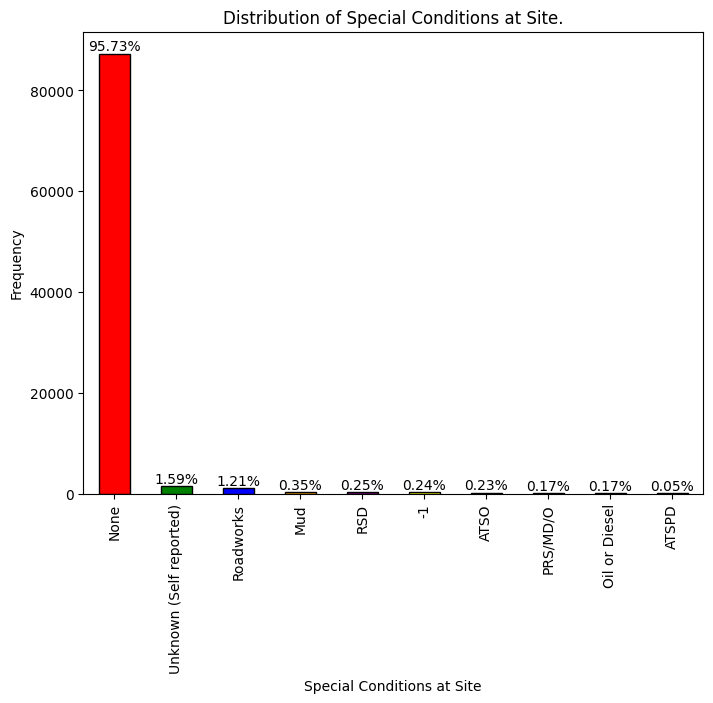

In [34]:
# Creating a bar plot for distribution of special conditions at site.

plt.figure(figsize = (8, 6))
scas_new_count.plot(kind = "bar", color = colour_bar_scas, edgecolor="black")
total_data_points = len(scas_new)
plt.xlabel("Special Conditions at Site")
plt.ylabel("Frequency")
plt.title("Distribution of Special Conditions at Site.")
plt.xticks(rotation = 90)
plt.grid(False)

for bar in plt.gca().patches:
    percentage = (bar.get_height() / total_data_points) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage:.2f}%", 
             ha="center", va="bottom")
plt.savefig("dist_special_conditions", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
"""
Values for Special Conditions at Site are difficult to infer.
Also from the EDA approximately 96% of these conditions are None (0), which could be that it was difficult to tell the conditions...
... or there are none.
The incorrect values of -1 would be replaced with 0 meaning None.
"""

df1["special_conditions_at_site"].replace([-1], 0, inplace = True) 

#### Weather Conditions

In [36]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "weather_conditions")

0

In [37]:
# Retrieving the unique values of the weather_conditions column.

ds_unique_chk(df1, "weather_conditions")

array([ 9,  1,  8,  7,  2,  4,  5,  3,  6, -1], dtype=int64)

In [38]:
df1[df1["weather_conditions"] == -1]

accident_index        date   time  day_of_week  accident_severity  \
79777  2020520002488  24/06/2020  01:15            4                  1   

       longitude   latitude  speed_limit  light_conditions  \
79777  -2.809007  51.288686         60.0                 6   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
79777                  -1                       -1                           0

In [39]:
"""
Weather history of the location was retrieved from VisualCrossing (Historical weather data for axbridge | Visual Crossing, n.d.).
From the record at 01:15 midnight the condition was dry with wind speed of 9.6kph, which is considered to be low.
Therefore, the weather condition during the accident is Fine without high winds (1). 
Also, since it has been confirmed from the weather record that it was a rain day the previous day.
A precipitation 0.79mm was recorded during the 19th hour of the previous day indicating rainfall just few hours to the incident.
This would certainly me the road surface was still wet/damp as at the time of accident.

"""

df1.loc[79777, "weather_conditions"] = 1
df1.loc[79777,"road_surface_conditions"] = 2

#### Road Surface Conditions

In [40]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "road_surface_conditions")

0

In [41]:
ds_unique_chk(df1, "road_surface_conditions")

array([ 9,  1,  2,  5,  4,  3, -1], dtype=int64)

###### The following inferences were made:
###### 1) If the weather condition was raining without high winds or raining with high winds then the road surface must be wet/damp. Hence, road surface conditions with values -1 for all accidents that occurred while raining was changed to wet/damp (2).
###### 2) If the weather condition was snowing without high winds then the road surface must be snow. Hence, road surface conditions with values -1 for all accidents that occurred while snowing without high winds was changed to snow (3).
###### 3) If the weather condition was snowing with high winds then the road surface would most likely be frosty or icy as high winds turns snow to ice. Hence, road surface conditions with values -1 for all accidents that occurred while snowing with high winds was changed to frost/ice (4).
###### 4) If the weather condition was fog or mist then the road surface would most likely be wet. Hence, road surface conditions with values -1 for all accidents that occurred while it was foggy or misty was changed to wet/damp (2).
###### 5) It is quite difficult to infer other road surface conditions accurately e.g. an accident could occurred while light condition is fine without high winds just few after a rainfall which would mean the road surface is still wet/damp and not dry as opposed to general believe. For all accidents with road surface conditions with values -1 that belongs to this category the multiple imputation by chain equations (MICE) technique would be used to generate and impute their corresponding road surface conditions values.

In [42]:
"""
The function changes all road surface conditions with values -1 for all accidents that occurred while raining....
.... to wet/damp (2).
"""

def scas_filter1(df_scas1):
    scas_filter1_res = (((df_scas1["weather_conditions"] == 2) | (df_scas1["weather_conditions"] == 5)) & ((df_scas1["road_surface_conditions"] == -1)))
    df_scas1.loc[scas_filter1_res, "road_surface_conditions"] = 2

In [43]:
# Changed road surface conditions in dataframe df1 with values -1 and 9 for all accidents that occurred while raining was changed to wet/damp (2).

scas_filter1(df1)

In [44]:
"""
The function changes all road surface conditions with values -1 for all accidents to the specified values....
.... in relations to it corresponding weather condition values.
"""

def scas_filter2(df_scas2, val_wc, val_rsc):
    scas_filter2_res = (((df_scas2["weather_conditions"] == val_wc)) & ((df_scas2["road_surface_conditions"] == -1)))
    df_scas2.loc[scas_filter2_res, "road_surface_conditions"] = val_rsc

In [45]:
# Changed road surface conditions in dataframe df1 with values -1 for all accidents that occurred while snowing without high winds was changed to snow (3).


scas_filter2(df1, 3, 3)

In [46]:
# Changed road surface conditions in dataframe df1 with values -1 for all accidents that occurred while it was foggy or misty was changed to wet/damp (2)..


scas_filter2(df1, 7, 2)

In [47]:
"""
There are no records where the weather condition was snowing with high winds and...
... road surface conditions was -1.
"""

df1[(df1["weather_conditions"] == 6) & ((df1["road_surface_conditions"] == -1))]

Empty DataFrame
Columns: [accident_index, date, time, day_of_week, accident_severity, longitude, latitude, speed_limit, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site]
Index: []

In [48]:
"""
A function that converts all accidents with road surface conditions with values -1 whose values in the....
.... weather conditions columns are 1, 4, 8 and 9 to NaN.
"""

def scas_filter3(df_scas3):
    scas_filter3_res = (((df_scas3["weather_conditions"] == 1) | (df_scas3["weather_conditions"] == 4) | (df_scas3["weather_conditions"] == 8) | (df_scas3["weather_conditions"] == 9)) & ((df_scas3["road_surface_conditions"] == -1)))
    df_scas3.loc[scas_filter3_res, "road_surface_conditions"] = np.nan

In [49]:
"""
Changing road surface conditions in dataframe df1 with values -1 and 9 for all accidents that occurred while the ..
.... weather conditons are 1, 4, 8 and 9 to np.nan in order to implement MICE.

"""

scas_filter3(df1)

#### Multiple Imputation Using Chain Equations (MICE)

MICE would generate and impute estimated values for all missing records (NaN) in the dataframe.

In [50]:
# Creating a copy of dataframe df1.
df1_cc = df1.copy()

In [51]:
# A function that removes all columns with datatype object in order to implement MICE without error.
def mice_col_remover(df_mice_col, mice_col_list):
    df_mice_col.drop(mice_col_list, axis=1, inplace=True)

In [52]:
# Removing the accident_index, date and time columns in dataframe df1_cc.

q1_mice_col = ["accident_index", "date", "time"]


mice_col_remover(df1_cc, q1_mice_col)

In [53]:
# A function that creates mice kernel and performs imputations.
# Creating mice kernel for imputations (Keita, 2023)

def mice_exec(df_mice_exec, iter_val1):
    df_kernel = ImputationKernel(
    data = df_mice_exec,
    save_all_iterations = True,
    random_state = 10
    )
    
    df_kernel.mice(iter_val1)
    df_mice_exec_imputed = df_kernel.complete_data()
    return df_mice_exec_imputed

In [54]:
# Executing MICE.

df1_cc = mice_exec(df1_cc, 3)

In [55]:
"""Retrieving the dataframe df1_cc describe information in order to compare data distribution values with....
... uncleaned dataframe df1. 
"""

df_desc_chk(df1_cc)

day_of_week  accident_severity     longitude      latitude  \
count  91199.000000       91199.000000  91199.000000  91199.000000   
mean       4.121558           2.768232     -1.189367     52.351151   
std        1.932200           0.456682      1.367810      1.327580   
min        1.000000           1.000000     -7.497375     49.970479   
25%        2.000000           3.000000     -2.107997     51.457234   
50%        4.000000           3.000000     -1.047081     51.763518   
75%        6.000000           3.000000     -0.125262     53.297714   
max        7.000000           3.000000      1.756257     60.541144   

        speed_limit  light_conditions  weather_conditions  \
count  91199.000000      91199.000000        91199.000000   
mean      36.274521          2.065384            1.702069   
std       13.889925          1.747709            1.845765   
min       20.000000          1.000000            1.000000   
25%       30.000000          1.000000            1.000000   
50%       30.000000          1.000000            1.000000   
75%       40.000000          4.000000            1.000000   
max       70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             91199.000000                91199.000000  
mean                  1.399982                    0.247130  
std                   0.916091                    1.317201  
min                   1.000000                    0.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

In [56]:
# A function that converts float object columns to int.

def ds_type_conv(df_type_conv, ds_type_name):
    df_type_conv[ds_type_name] = df_type_conv[ds_type_name].astype("int64")

In [57]:
# Converting the speed_limit columns back to int64.

ds_type_conv(df1_cc, "speed_limit")

In [58]:
# Converting the road surface condition columns back to int64.

ds_type_conv(df1_cc, "road_surface_conditions")

In [59]:
# A function that add columns to a dataframe.

def col_add(df_col_cur, df_col_old, ds_col_list):
    for a in range(len(ds_col_list)):
        df_col_cur.insert(a, ds_col_list[a], df_col_old[ds_col_list[a]].copy())  

In [60]:
# Returning the all columns with datatype object that were drop earlier to implement MICE.

col_add(df1_cc, df1, q1_mice_col)

In [61]:
df1_cc

accident_index        date   time  day_of_week  accident_severity  \
0      2020010219808  04/02/2020  09:00            3                  3   
1      2020010220496  27/04/2020  13:55            2                  3   
2      2020010228005  01/01/2020  01:25            4                  3   
3      2020010228006  01/01/2020  01:50            4                  2   
4      2020010228011  01/01/2020  02:25            4                  3   
...              ...         ...    ...          ...                ...   
91194  2020991027064  12/08/2020  14:30            4                  2   
91195  2020991029573  13/11/2020  15:05            6                  3   
91196  2020991030297  15/04/2020  12:42            4                  2   
91197  2020991030900  15/12/2020  14:00            3                  3   
91198  2020991032575  25/08/2020  13:50            3                  3   

       longitude   latitude  speed_limit  light_conditions  \
0      -0.254001  51.462262           20                 1   
1      -0.139253  51.470327           20                 1   
2      -0.178719  51.529614           30                 4   
3      -0.001683  51.541210           30                 4   
4      -0.137592  51.515704           30                 4   
...          ...        ...          ...               ...   
91194  -2.926320  56.473539           30                 1   
91195  -4.267565  55.802353           30                 1   
91196  -2.271903  57.186317           60                 1   
91197  -3.968753  55.950940           30                 1   
91198  -4.561040  56.003843           30                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       9                        9                           0  
1                       1                        1                           0  
2                       1                        2                           0  
3                       1                        1                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
91194                   1                        1                           0  
91195                   1                        1                           0  
91196                   1                        1                           0  
91197                   1                        1                           0  
91198                   1                        1                           0  

[91199 rows x 12 columns]

### Analysis

### Hours of the day with most accidents

In [62]:
"""
A function that creates datatime object from a dataseries. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

def obj_time(df_obj_time, ds_obj_time, format_obj):
    converted_time = pd.to_datetime(df_obj_time[ds_obj_time], format = format_obj)
    return converted_time

In [63]:
"""
Creating a datatime object from the time dataseries. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

time_ds = obj_time(df1_cc, "time", "%H:%M") 

In [64]:
"""
A function that extracts hours from a datetime object. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

def hr_extract(ds_hr_extract):
    extracted_hr = ds_hr_extract.dt.hour
    return extracted_hr

In [65]:
# Extracting the hours from the datetime object.

hr = hr_extract(time_ds)

In [66]:
# Creating a list of colours.

colour_bar_1 = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'brown',
              'gray', 'pink', 'olive', 'teal', 'navy', 'salmon', 'gold', 'lime', 'violet',
              'darkorange', 'turquoise', 'indigo', 'sienna', 'darkgray', 'hotpink']

In [67]:
# A function that plots a bar chart for hours in a day and displays their corresponding proportions.

def bar_plot(ds_hr_extract2, pix_name):
    bar_hr_count = ds_hr_extract2.value_counts() # Count the occurrences of each hour.
    bar_hr_count = bar_hr_count.reindex(range(24))
    plt.figure(figsize = (12, 6))
    bar_hr_count.plot(kind = "bar", color = colour_bar_1, edgecolor="black")
    bar_hr_total_data_points = len(ds_hr_extract2)
    plt.xlabel("Hours of The Day")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accident Hours.")
    plt.xticks(range(24), rotation = 0)
    plt.grid(False)

    for bar2 in plt.gca().patches:
        percentage = (bar2.get_height() / bar_hr_total_data_points) * 100
        plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f"{percentage:.2f}%", 
             ha="center", va="bottom")
    plt.savefig(pix_name, dpi=300, bbox_inches='tight')
    plt.show()

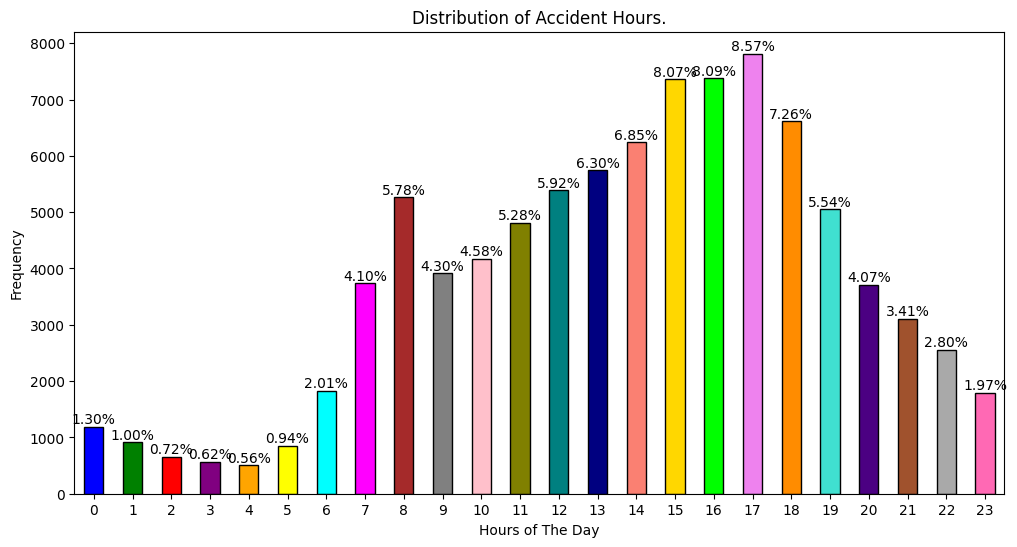

In [68]:
# Plotting a bar chart accident occurrances for each hour of the day and respective proportions.

bar_plot(hr, "dist_acc_hr_q1")

Generally, the significant hours which accident occurs are between hour 7 & 8 and hour 15 & 18. This is mostly likely due to the early morning and late evening rush to and fro different destinations. Hours 17, 16 and 15 are top hours of accident.

### Days of Week With Most Accident

In [69]:
colour_bar_2 = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown']

In [70]:
"""
Mapping the days of the week to their respective number code. (Pandas Map, Explained - Sharp Sight, 2022).
The stat19 document indicated that Sunday is the first day of the week.
"""

def days_mapper(df_days_mapper):
    days_mapping = {1 : "Sunday", 
                    2 : "Monday", 
                    3 : "Tuesday", 
                    4 : "Wednesday", 
                    5 : "Thursday", 
                    6 : "Friday", 
                    7 : "Saturday"}
    
    ds_new_week = df_days_mapper["day_of_week"].map(days_mapping) # Creating a new dataseries and replacing with the mapped values.
    return ds_new_week

In [71]:
# Creating a new dataseries and replacing with the mapped values.

day_of_week_new = days_mapper(df1_cc)

In [72]:
# A function that stores the count of the newly mapped dataseries.

def map_count(ds_map_count):
    label_count_val = ds_map_count.value_counts()
    return label_count_val

In [73]:
# Creating a variable that stores the count of the newly mapped dataseries.

day_of_week_new_count = map_count(day_of_week_new)

In [74]:
# A function that plots a bar chart for the days of the week.

def days_bar_plotter(ds_days_mapper, pix_name2):
    #ds_days_mapper_count = ds_days_mapper.value_counts()
    # Create a figure and axis
    plt.figure(figsize = (10, 6))  # Set the figure size (width, height)
    
    # Plot the histogram
    plt.bar(ds_days_mapper.index, ds_days_mapper.values, color = colour_bar_2, edgecolor= "black")
    
    # Set appropriate labels and title
    plt.xlabel("Day of the Week")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accident Days.")

    plt.xticks(rotation = 0)

    plt.grid(False)
    plt.savefig(pix_name2, dpi=300, bbox_inches='tight')
    plt.show()

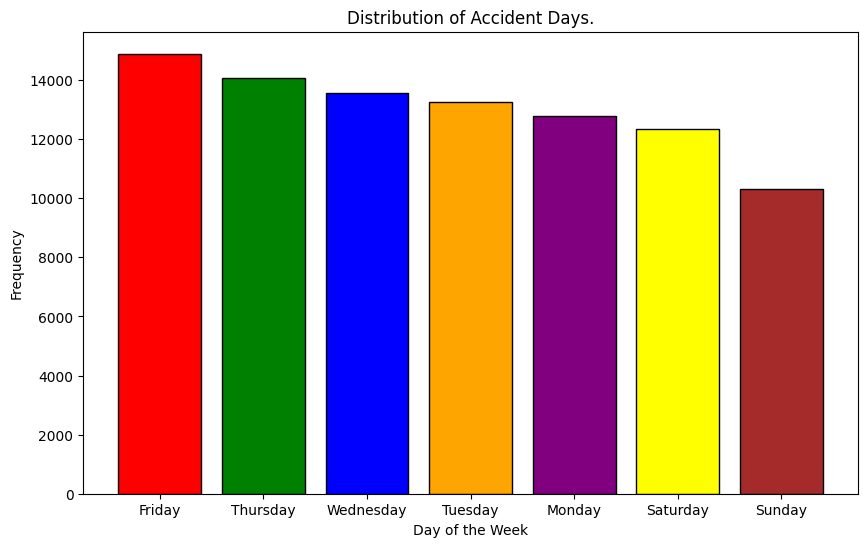

In [75]:
# Plotting a bar chart showing the accident frequency for each day of the week.

days_bar_plotter(day_of_week_new_count, "dis_acc_days_q1")

In [76]:
def pie_plotter(ds_pie_count, pix_name3):
    # Get the labels for the pie chart
    days_labels = [f"{i}" for i in ds_pie_count.index]

    # Plot the pie chart
    plt.figure(figsize = (10, 6))
    plt.pie(ds_pie_count, labels = days_labels, autopct = "%1.1f%%", startangle = 90, wedgeprops=dict(width=0.4))
    plt.title("Proportions of Accident Days.")
    plt.axis("equal")  # Equal aspect ratio ensures that the pie is drawn as a circle.
    plt.savefig(pix_name3, dpi=300, bbox_inches='tight')
    plt.show()

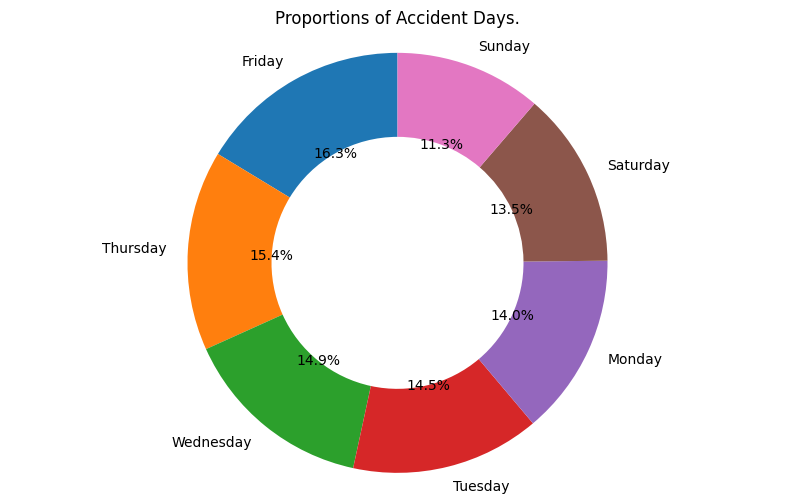

In [77]:
pie_plotter(day_of_week_new_count, "pie_days_q1")

In [78]:
# A function that displays the total number accidents for each day.

def day_acc_total(ds_day_acc):
    for b in range(7):
        print(f"The number of accidents on {ds_day_acc.index[b]}s is {ds_day_acc.values[b]}.")

In [79]:
# Displaying the total number of accidents for each day.

day_acc_total(day_of_week_new_count)

The number of accidents on Fridays is 14889.
The number of accidents on Thursdays is 14056.
The number of accidents on Wednesdays is 13564.
The number of accidents on Tuesdays is 13267.
The number of accidents on Mondays is 12772.
The number of accidents on Saturdays is 12336.
The number of accidents on Sundays is 10315.


Significant days which accident occur are from Monday to Friday.

### Plotting Time Stamp

In [80]:
df1_cc_combined = pd.concat([day_of_week_new, hr], axis=1)
df1_cc_combined.columns = ["day_of_week", "hour_of_day"]

In [81]:
grouped_df1_cc = df1_cc_combined.groupby(["day_of_week", "hour_of_day"]).size()

In [82]:
pivot_df1_cc = grouped_df1_cc.unstack(level="day_of_week")

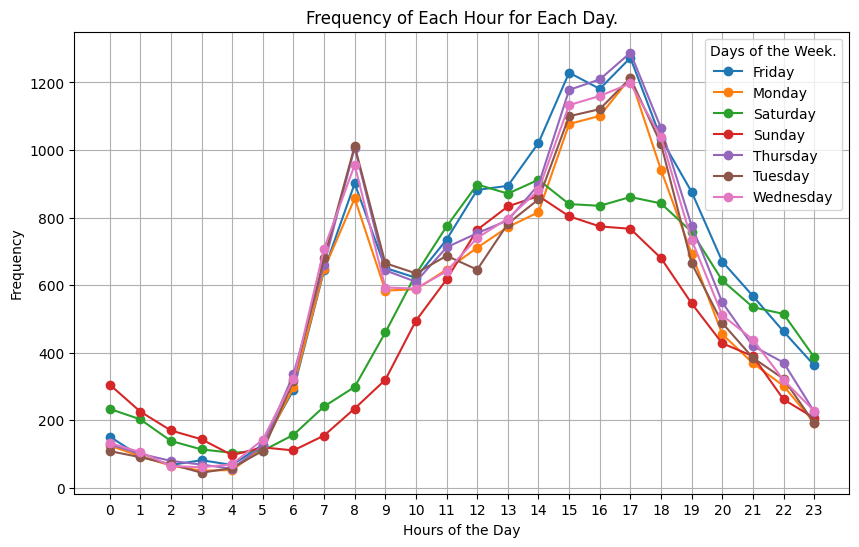

In [83]:
pivot_df1_cc.plot(kind="line", marker="o", figsize=(10, 6))
plt.xlabel("Hours of the Day")
plt.ylabel("Frequency")
plt.title("Frequency of Each Hour for Each Day.")
plt.xticks(range(24), range(24))  # Assuming hours are integers from 0 to 23
plt.legend(title="Days of the Week.")
plt.grid(True)
plt.savefig("time_stamp_q1", dpi=300, bbox_inches='tight')
plt.show()

The time stamp corroborates the initial findings that the significant hour periods are 7 – 8 and 15 – 18. And significant days are weekdays. 

#### Locations of Accident During Significants Hours and Days.

In [84]:
# Introducing a new dataseries containing only hour of time.

df1_cc["hour"] = hr.copy()

In [85]:
# Creating a dataframe containing accidents that occurred during the significants hours and days.

df1_cc2 = df1_cc[((((df1_cc["hour"] >= 7) & (df1_cc["hour"] < 9)) | ((df1_cc["hour"] >= 15) & (df1_cc["hour"] < 19))) & ((df1_cc["day_of_week"] >=2) & (df1_cc["day_of_week"] <7)))]

In [86]:
# Combining longitude and latitude columns to create a Point geometry column.
geo_df1_cc2 = [Point(lon, lat) for lon, lat in zip(df1_cc2["longitude"], df1_cc2["latitude"])]

# Creating a GeoDataFrame with the original DataFrame and the Point geometries.
gdf1 = gpd.GeoDataFrame(df1_cc2, geometry = geo_df1_cc2, crs = "EPSG:4326")


In [87]:
# Loading the UK map shapefile (you can download shapefiles from various sources).
uk_map = gpd.read_file("./UK_DISTRICTS_COUNTIES_CENSUS2011.shp")

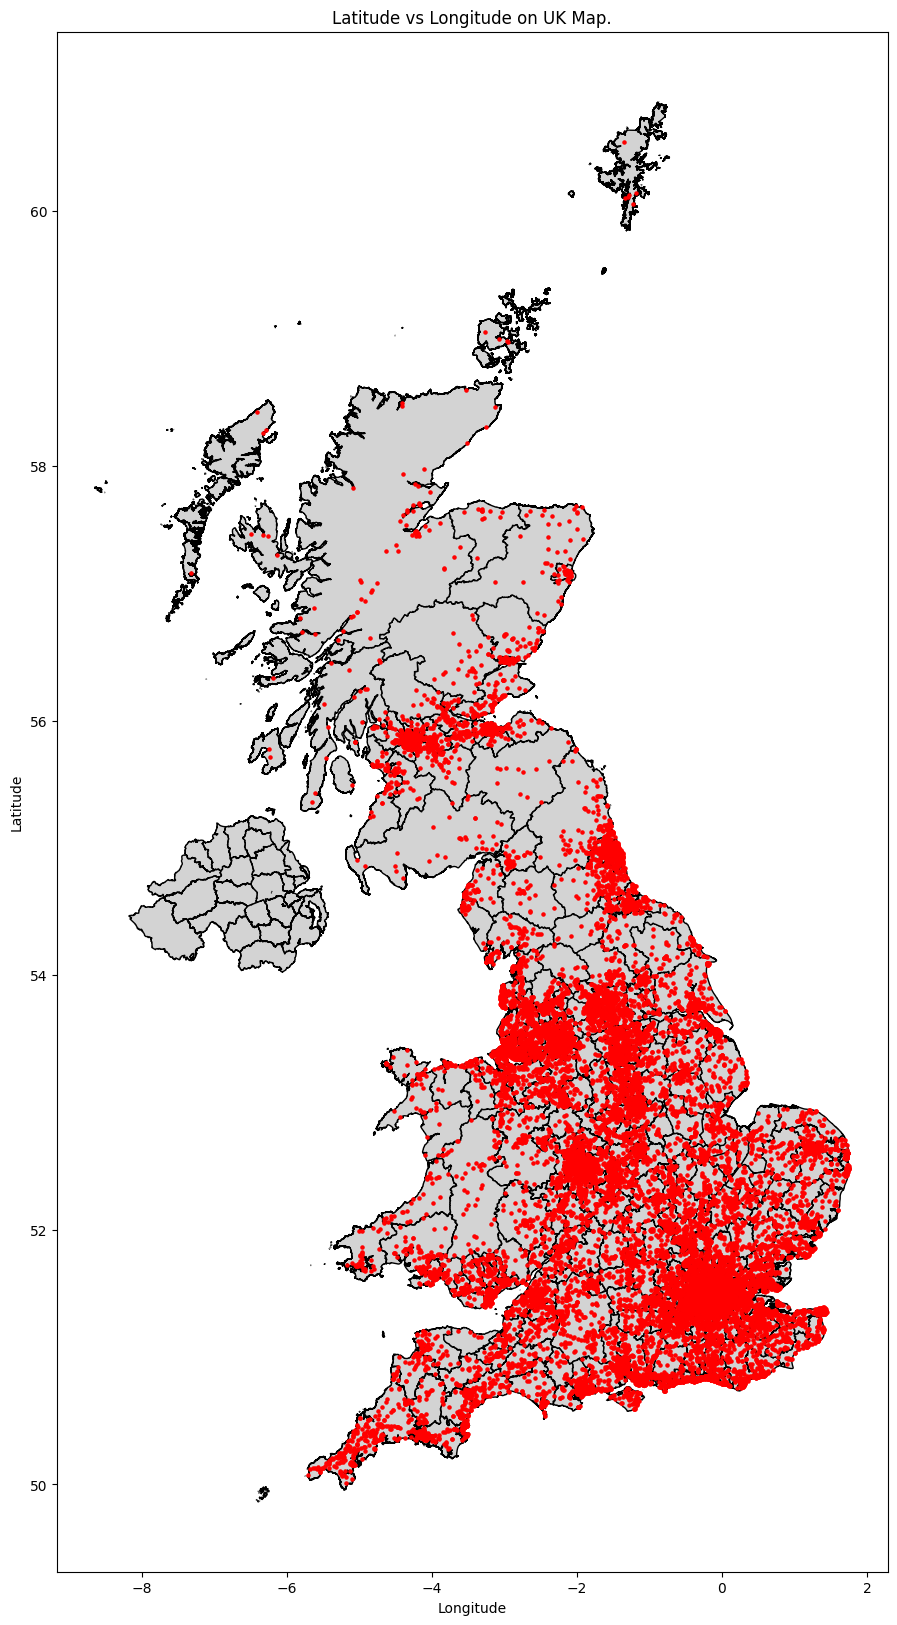

In [88]:
# Creating the plot
fig, ax = plt.subplots(figsize = (20, 20))

# Plotting the world map
uk_map.plot(ax = ax, color= "lightgray", edgecolor= "black")

# Plotting the GeoDataFrame with latitude and longitude data on the world map.
gdf1.plot(ax = ax, color = "red", markersize = 5)

# Adding title and labels.
plt.title("Latitude vs Longitude on UK Map.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("acc_loc_q1", dpi=300, bbox_inches='tight')

# Showing the plot.
plt.show()

In [89]:
"""
Creating a folium map (Reinking, 2023).
Source: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium
"""

folium_map_1 = folium.Map(prefer_canvas=True)

def folium_plotter(plot):
    folium.CircleMarker(location=[plot.latitude, plot.longitude],
                        radius=2,
                        weight=5).add_to(folium_map_1)

# Iterating through every row in the dataframe
df1_cc2.apply(folium_plotter, axis = 1)


# Setting the zoom to the maximum possible
folium_map_1.fit_bounds(folium_map_1.get_bounds())

# Saving the map to an HTML file
folium_map_1.save("./acc_loc_folium_q1.html")

Majority of accident within the significant periods occurred in the London Metropolitan region.

#### Conditions

In [90]:
# A function to plot pie chart.

def cond_plotter(plot_data, plot_labels, plot_titles, pix_name4):
    
    # Calculate the percentage for each code
    cond_total = len(plot_data)
    cond_percentages = [plot_data.tolist().count(code) / cond_total * 100 for code in plot_labels]

    # Create the pie chart
    plt.figure(figsize = (10, 6))  # Set the figure size (width, height)
    plt.pie(cond_percentages, autopct = "%1.1f%%", startangle = 90, wedgeprops = dict(width = 0.4), textprops={"fontsize": 10})
    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(
    loc = "upper left",
    labels = plot_labels.values(),
    bbox_to_anchor=(1, 1)  # Adjust the legend position
    )
    plt.tight_layout()  # Automatically adjust spacing to prevent overlapping
    plt.title(f"Pie Chart of {plot_titles}.")
    plt.savefig(pix_name4, dpi = 300, bbox_inches = "tight")
    plt.show()

###### Speed Limit

In [91]:
# Dictionary of light conditions and interpretation.

speed_labels = {20: "20 mph", 
          30: "30 mph", 
          40: "40 mph", 
          50: "50 mph", 
          60: "60 mph", 
          70: "70 mph"}

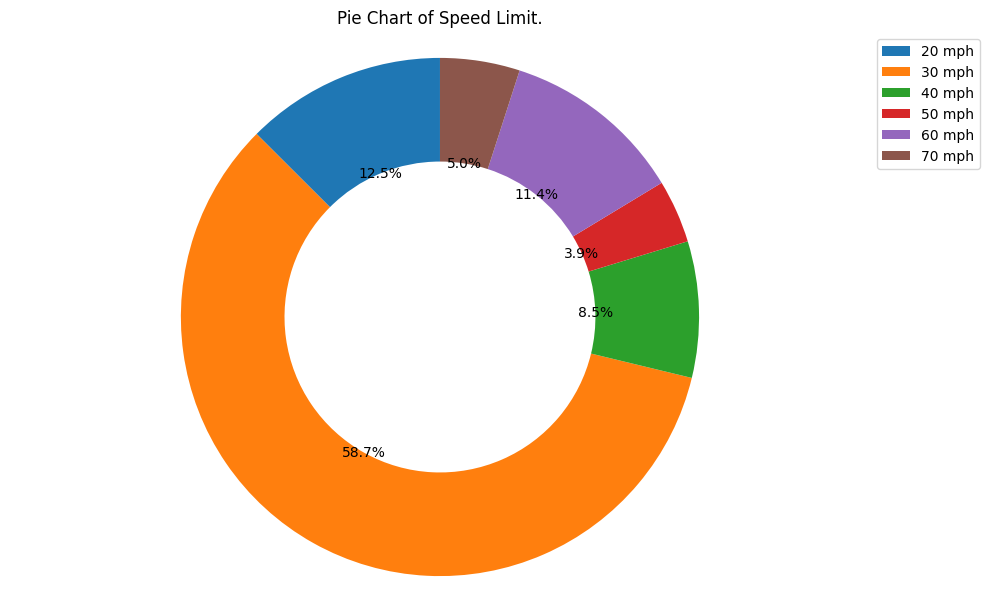

In [92]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df1_cc2["speed_limit"], speed_labels, "Speed Limit", "spd_cond_q1")

Most accidents during the significant period and days occurred within speed limit of 30 mph.

###### Light Conditions

In [93]:
# Dictionary of light conditions and interpretation.

light_labels = {1: "Daylight", 
          4: "Darkness: street lights present and lit", 
          5: "Darkness: street lights present but unlit", 
          6: "Darkness: no street lighting", 
          7: "Darkness: street lighting unknown"}

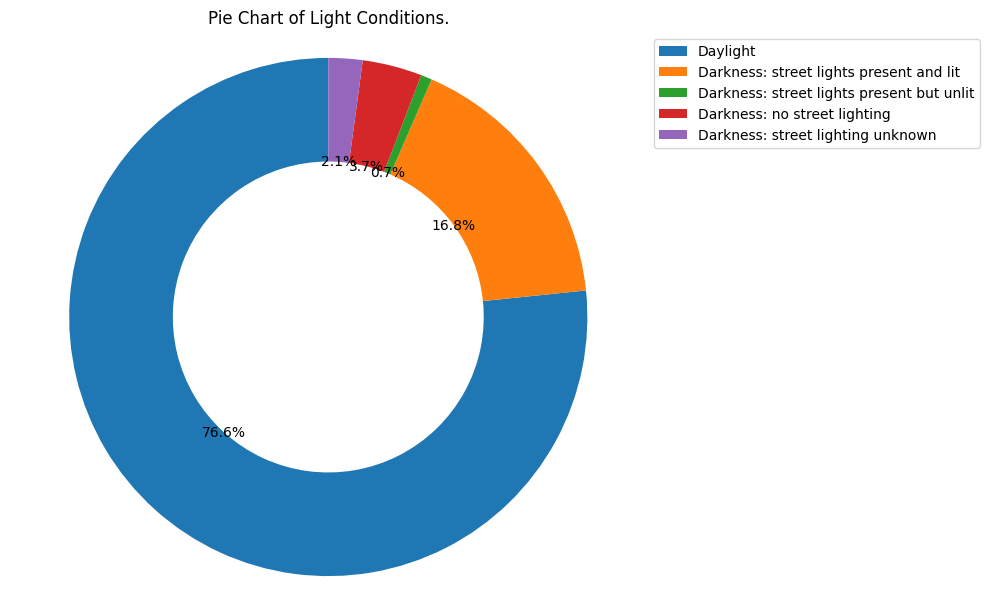

In [94]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df1_cc2["light_conditions"], light_labels, "Light Conditions", "lit_cond_q1")

Most accidents during the significant period and days occurred during daylight.

###### Weather Conditions

In [95]:
# Dictionary of weather conditions and interpretation.

weather_labels = {1: "Fine without high winds", 
          2: "Raining w/out high winds", 
          3: "Snowing w/out high winds", 
          4: "Fine with high winds", 
          5: "Raining with high winds", 
          6: "Snowing with high winds",
          7: "Fog or mist — if hazard",
          8: "Other",
          9: "Unknown"}

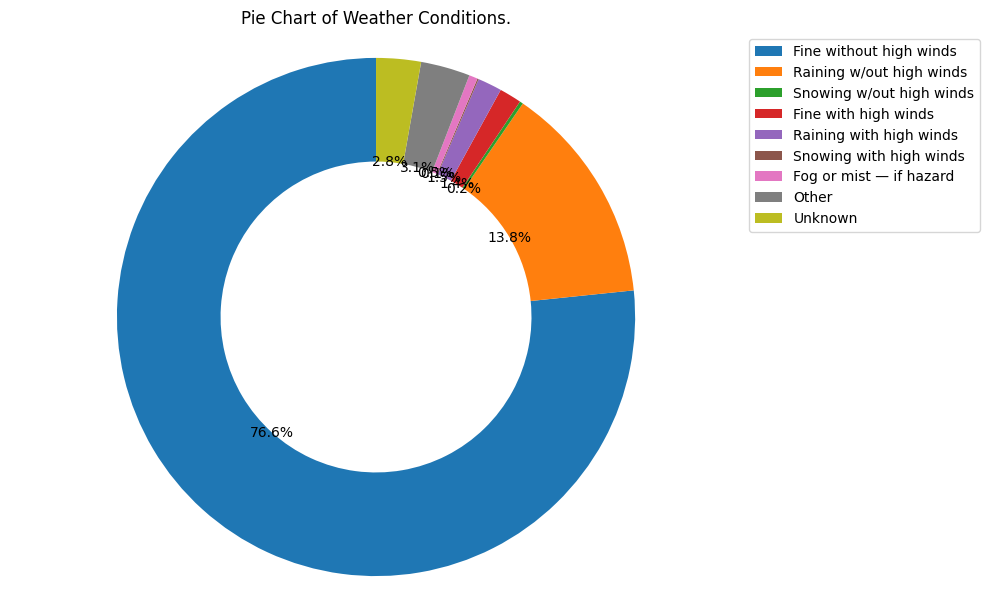

In [96]:
cond_plotter(df1_cc2["weather_conditions"], weather_labels, "Weather Conditions", "wth_cond_q1")

Most accidents during the significant period and days occurred during fine weather without high winds.

##### Road Surface Conditions

In [97]:
# Dictionary of light conditions and interpretation.

rsc_labels = {1: "Dry", 
          2: "Wet / Damp", 
          3: "Snow", 
          4: "Frost / Ice", 
          5: "Flood (surface water over 3cm deep)",
          9: "Unknown (Self reported)"}

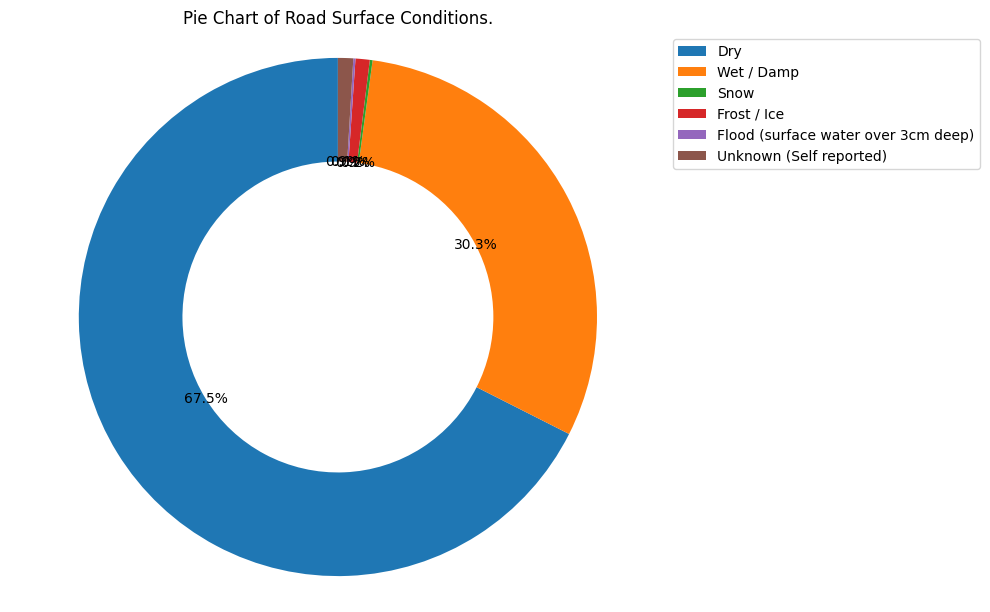

In [98]:
cond_plotter(df1_cc2["road_surface_conditions"], rsc_labels, "Road Surface Conditions", "rsc_cond_q1")

Most accidents during the significant period and days occurred on dry road surface.

##### Special Conditions at Site

In [99]:
# Dictionary of special conditions at site and interpretation.

scs_labels = {0: "None", 
          1: "A/traffic signal out", 
          2: "A/traffic signal partially defective", 
          3: "Perm rd signing or mrkng defective or obscured", 
          4: "Roadworks",
          5: "Road surface defective", 
          6: "Oil or diesel", 
          7: "Mud", 
          9: "Unknown (Self reported)"}

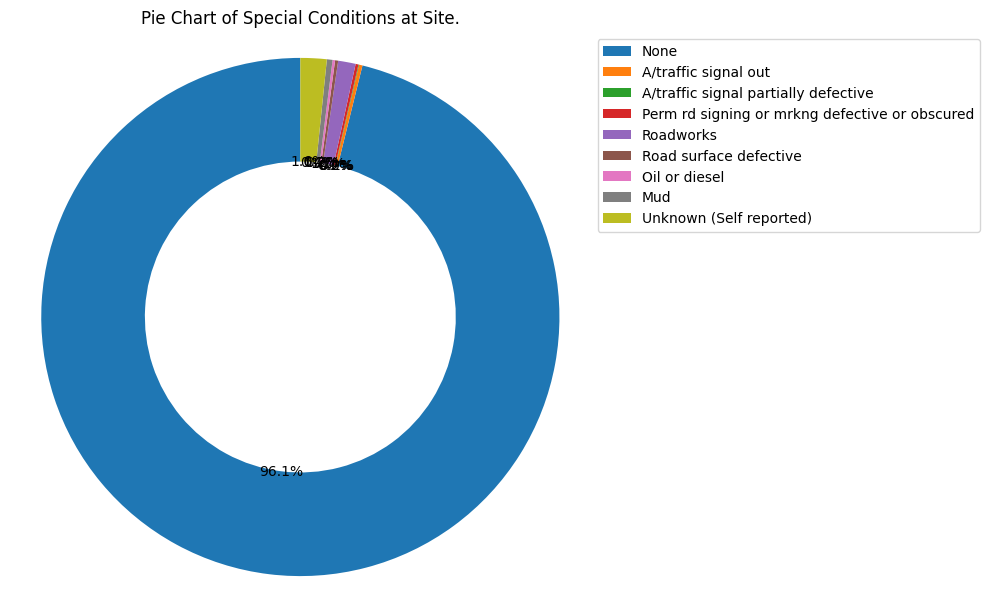

In [100]:
cond_plotter(df1_cc2["special_conditions_at_site"], scs_labels, "Special Conditions at Site", "scs_cond_q1")

Most accidents during the significant period and days occurred within no special conditions at site.

##### Accident Severity

In [101]:
# Dictionary of light conditions and interpretation.

acc_sev_labels = { 1: "Fatal", 
               2: "Serious", 
               3: "Slight"}

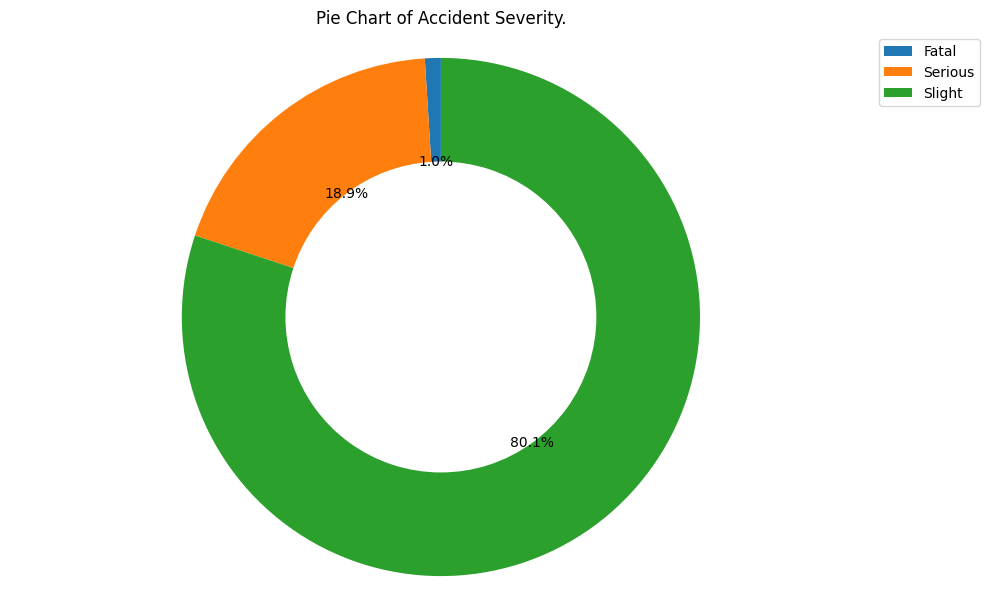

In [102]:
cond_plotter(df1_cc2["accident_severity"], acc_sev_labels, "Accident Severity", "acc_sev_q1")

Most accidents during the significant period and days were slightly severe.

### 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

In [103]:
query_2 = """
SELECT a.accident_index, v.vehicle_type, a.date, a.time, a.day_of_week, a.accident_severity, a.longitude, a.latitude, a.speed_limit, a.light_conditions, a.weather_conditions, a.road_surface_conditions, a.special_conditions_at_site
FROM accident as a
INNER JOIN vehicle as v ON a.accident_index = v.accident_index
WHERE a.accident_year = 2020 AND v.vehicle_type IN (3, 4, 5)
"""

df2 = pd.read_sql(query_2, con)
df2

accident_index  vehicle_type        date   time  day_of_week  \
0      2020010228020             3  01/01/2020  03:25            4   
1      2020010228086             3  01/01/2020  14:00            4   
2      2020010228097             3  01/01/2020  14:37            4   
3      2020010228148             3  01/01/2020  19:05            4   
4      2020010228207             3  01/01/2020  14:29            4   
...              ...           ...         ...    ...          ...   
12993  2020991010130             3  24/12/2020  16:30            5   
12994  2020991011809             3  16/12/2020  17:30            4   
12995  2020991012311             3  28/12/2020  17:55            2   
12996  2020991012353             4  06/08/2020  15:45            5   
12997  2020991030297             5  15/04/2020  12:42            4   

       accident_severity  longitude   latitude  speed_limit  light_conditions  \
0                      3  -0.127840  51.614971           30                 4   
1                      3  -0.114680  51.470537           20                 1   
2                      3  -0.150994  51.503659           30                 1   
3                      3  -0.292651  51.553691           30                 4   
4                      3  -0.174362  51.420033           20                 1   
...                  ...        ...        ...          ...               ...   
12993                  3  -4.383591  55.792760           30                 4   
12994                  3  -4.104624  55.785004           30                 4   
12995                  2  -3.419652  56.038240           30                 4   
12996                  3  -3.336269  56.591779           20                 1   
12997                  2  -2.271903  57.186317           60                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       1                        1                           0  
1                       1                        1                           0  
2                       1                        1                           0  
3                       1                        1                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
12993                   1                        1                           0  
12994                   8                        2                           0  
12995                   1                        1                           0  
12996                   1                        1                           0  
12997                   1                        1                           0  

[12998 rows x 13 columns]

### EDA for The Columns Relevant to Question 2.

In [104]:
# Retrieving information of dataframe df2.

info_chk(df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12998 entries, 0 to 12997
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   accident_index              12998 non-null  object 
 1   vehicle_type                12998 non-null  int64  
 2   date                        12998 non-null  object 
 3   time                        12998 non-null  object 
 4   day_of_week                 12998 non-null  int64  
 5   accident_severity           12998 non-null  int64  
 6   longitude                   12994 non-null  float64
 7   latitude                    12994 non-null  float64
 8   speed_limit                 12998 non-null  int64  
 9   light_conditions            12998 non-null  int64  
 10  weather_conditions          12998 non-null  int64  
 11  road_surface_conditions     12998 non-null  int64  
 12  special_conditions_at_site  12998 non-null  int64  
dtypes: float64(2), int64(8), object

In [105]:
# Retrieving information of dataframe df2.

df_null_chk(df2)

accident_index                0
vehicle_type                  0
date                          0
time                          0
day_of_week                   0
accident_severity             0
longitude                     4
latitude                      4
speed_limit                   0
light_conditions              0
weather_conditions            0
road_surface_conditions       0
special_conditions_at_site    0
dtype: int64

In [106]:
# Retrieving the describe information of dataframe df2.

df_desc_chk(df2)

vehicle_type   day_of_week  accident_severity     longitude  \
count  12998.000000  12998.000000       12998.000000  12994.000000   
mean       3.712340      4.103477           2.649177     -0.939362   
std        0.887252      1.981445           0.522646      1.311875   
min        3.000000      1.000000           1.000000     -7.497375   
25%        3.000000      2.000000           2.000000     -1.718515   
50%        3.000000      4.000000           3.000000     -0.291742   
75%        5.000000      6.000000           3.000000     -0.098784   
max        5.000000      7.000000           3.000000      1.751341   

           latitude   speed_limit  light_conditions  weather_conditions  \
count  12994.000000  12998.000000      12998.000000        12998.000000   
mean      52.061843     34.545315          1.968764            1.596169   
std        1.202404     13.342808          1.652725            1.720156   
min       50.036209     20.000000          1.000000            1.000000   
25%       51.441777     30.000000          1.000000            1.000000   
50%       51.546754     30.000000          1.000000            1.000000   
75%       52.578768     40.000000          4.000000            1.000000   
max       58.990846     70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             12998.000000                12998.000000  
mean                  1.353670                    0.396292  
std                   0.954419                    1.706378  
min                  -1.000000                   -1.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

##### Vehicle Type

In [107]:
# Checking if the date column has any blank records or None values.

ds_empty_chk(df2, "vehicle_type")

0

In [108]:
# Retrieving the unique values of the day_of_week column.

ds_unique_chk(df2, "vehicle_type")

array([3, 4, 5], dtype=int64)

##### Date

In [109]:
# Checking if the date column has any blank records or None values.

ds_empty_chk(df2, "date")

0

##### Time

In [110]:
# Checking if the time column has any blank records or None values.

ds_empty_chk(df2, "time")

0

##### Day of Week

In [111]:
# Checking if the day of week column has any blank records or None values.

ds_empty_chk(df2, "day_of_week")

0

In [112]:
# Retrieving the unique values of the day_of_week column.

ds_unique_chk(df2, "day_of_week")

array([4, 5, 6, 7, 1, 2, 3], dtype=int64)

##### Accident Severity

In [113]:
# Checking if the accident severity column has any blank records or None values.

ds_empty_chk(df2, "accident_severity")

0

In [114]:
# Retrieving the unique values of the accident severity column.

ds_unique_chk(df2, "accident_severity")

array([3, 2, 1], dtype=int64)

#####  Latitude and Longitude Columns

In [115]:
# Checking if the longtitude column has any blank records or None values.

ds_empty_chk(df2, "longitude")

0

In [116]:
# Checking if the latitude column has any blank records or None values.

ds_empty_chk(df2, "latitude")

0

Multiple Imputation by Chain Equation will be used to geneate and impute missing values in the longitude and latitude columns.

##### Speed Limit

In [117]:
# Checking if the speed limit column has any blank records or None values.

ds_empty_chk(df2, "speed_limit")

0

In [118]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df2, "speed_limit")

array([30, 20, 40, 50, 60, 70], dtype=int64)

##### Light Conditions

In [119]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df2, "light_conditions")

0

In [120]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df2, "light_conditions")

array([4, 1, 7, 5, 6], dtype=int64)

##### Special Conditions at Site

In [121]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df2, "special_conditions_at_site")

0

In [122]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df2, "special_conditions_at_site")

array([ 0,  9,  4,  1,  3,  5,  7,  6,  2, -1], dtype=int64)

In [123]:
df2_scas_new = df2["special_conditions_at_site"].map(scas_mapping) # Creating a new dataseries and replacing with the mapped values.
df2_scas_new_count = df2_scas_new.value_counts()

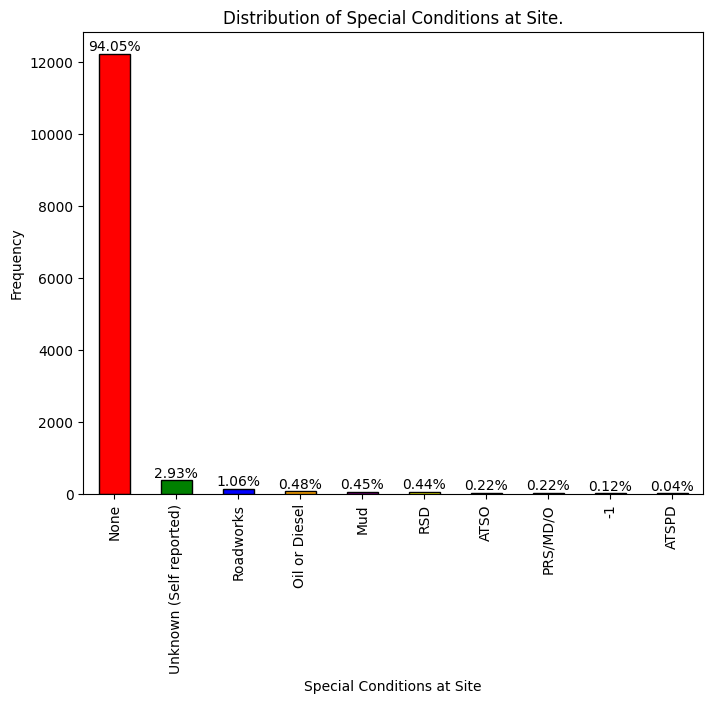

In [124]:
# Plotting a bar to display the distribution of special conditions at site.

plt.figure(figsize = (8, 6))
df2_scas_new_count.plot(kind = "bar", color = colour_bar_scas, edgecolor="black")
df2_total_data_points = len(df2_scas_new)
plt.xlabel("Special Conditions at Site")
plt.ylabel("Frequency")
plt.title("Distribution of Special Conditions at Site.")
plt.xticks(rotation=90)
plt.grid(False)

for bar2 in plt.gca().patches:
    percentage = (bar2.get_height() / df2_total_data_points) * 100
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f"{percentage:.2f}%", 
             ha="center", va="bottom")
plt.savefig("dist_special_conditions_df2", dpi=300, bbox_inches='tight')
plt.show()

In [125]:
"""
Values for Special Conditions at Site are difficult to infer.
Also from the EDA 94% of these conditions are None (0), which could be that it was difficult to tell the conditions...
... or there are none.
The incorrect values -1 and 9 would be replaced with 0 meaning None.
"""

df2["special_conditions_at_site"].replace([-1], 0, inplace = True) 

##### Weather Conditions

In [126]:
# Checking if the weather conditions column has any blank records or None values.

ds_empty_chk(df2, "weather_conditions")

0

In [127]:
# Retrieving the unique values of the weather conditions column.

ds_unique_chk(df2, "weather_conditions")

array([1, 2, 9, 8, 4, 5, 3, 7, 6], dtype=int64)

##### Road Surface Conditions

In [128]:
# Checking if the day_of_week data series from df1 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df1, "road_surface_conditions")

0

In [129]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df2, "road_surface_conditions")

array([ 1,  2,  9,  4,  3,  5, -1], dtype=int64)

In [130]:
# Changed road surface conditions in dataframe df2 with values -1 for all accidents that occurred while raining was changed to wet/damp (2).

scas_filter1(df2)

In [131]:
# Changed road surface conditions in dataframe df2 with values -1 for all accidents that occurred while snowing without high winds was changed to snow (3).


scas_filter2(df2, 3, 3)

In [132]:
# Changed road surface conditions in dataframe df2 with values -1 for all accidents that occurred while it was foggy or misty was changed to wet/damp (2)..


scas_filter2(df2, 7, 2)

In [133]:
"""
There are no records where the weather condition was snowing with high winds and...
... road surface conditions was either -1 or 9.
"""

df2[(df2["weather_conditions"] == 6) & ((df2["road_surface_conditions"] == -1))]

Empty DataFrame
Columns: [accident_index, vehicle_type, date, time, day_of_week, accident_severity, longitude, latitude, speed_limit, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site]
Index: []

In [134]:
"""
Changing road surface conditions in dataframe df1 with values -1 for all accidents that occurred while the ..
.... weather conditons are 1, 4, 8 and 9 to np.nan in order to implement MICE.

"""

scas_filter3(df2)

#### Multiple Imputation Using Chain Equations (MICE)

MICE would generate and impute estimated values for all missing records (NaN) in the dataframe.

In [135]:
# Creating a copy of dataframe df2.
df2_cc = df2.copy()

In [136]:
# Removing the accident_index, date and time columns in dataframe df2_cc.

q2_mice_col = ["accident_index", "date", "time"]


mice_col_remover(df2_cc, q2_mice_col)

In [137]:
# Executing MICE.

df2_cc = mice_exec(df2_cc, 3)

In [138]:
"""Retrieving the dataframe df2_cc describe information in order to compare data distribution values with....
... uncleaned dataframe df2. 
"""

df_desc_chk(df2_cc)

vehicle_type   day_of_week  accident_severity     longitude  \
count  12998.000000  12998.000000       12998.000000  12998.000000   
mean       3.712340      4.103477           2.649177     -0.939339   
std        0.887252      1.981445           0.522646      1.311957   
min        3.000000      1.000000           1.000000     -7.497375   
25%        3.000000      2.000000           2.000000     -1.718515   
50%        3.000000      4.000000           3.000000     -0.291742   
75%        5.000000      6.000000           3.000000     -0.098784   
max        5.000000      7.000000           3.000000      1.751341   

           latitude   speed_limit  light_conditions  weather_conditions  \
count  12998.000000  12998.000000      12998.000000        12998.000000   
mean      52.061655     34.545315          1.968764            1.596169   
std        1.202287     13.342808          1.652725            1.720156   
min       50.036209     20.000000          1.000000            1.000000   
25%       51.441699     30.000000          1.000000            1.000000   
50%       51.546745     30.000000          1.000000            1.000000   
75%       52.578673     40.000000          4.000000            1.000000   
max       58.990846     70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             12998.000000                12998.000000  
mean                  1.359132                    0.397523  
std                   0.952741                    1.705731  
min                   1.000000                    0.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

In [139]:
# Converting the road surface condition columns back to int64.

ds_type_conv(df2_cc, "road_surface_conditions")

In [140]:
# Returning the all columns with datatype object that were drop earlier to implement MICE.

col_add(df2_cc, df2, q2_mice_col)

In [141]:
df2_cc

accident_index        date   time  vehicle_type  day_of_week  \
0      2020010228020  01/01/2020  03:25             3            4   
1      2020010228086  01/01/2020  14:00             3            4   
2      2020010228097  01/01/2020  14:37             3            4   
3      2020010228148  01/01/2020  19:05             3            4   
4      2020010228207  01/01/2020  14:29             3            4   
...              ...         ...    ...           ...          ...   
12993  2020991010130  24/12/2020  16:30             3            5   
12994  2020991011809  16/12/2020  17:30             3            4   
12995  2020991012311  28/12/2020  17:55             3            2   
12996  2020991012353  06/08/2020  15:45             4            5   
12997  2020991030297  15/04/2020  12:42             5            4   

       accident_severity  longitude   latitude  speed_limit  light_conditions  \
0                      3  -0.127840  51.614971           30                 4   
1                      3  -0.114680  51.470537           20                 1   
2                      3  -0.150994  51.503659           30                 1   
3                      3  -0.292651  51.553691           30                 4   
4                      3  -0.174362  51.420033           20                 1   
...                  ...        ...        ...          ...               ...   
12993                  3  -4.383591  55.792760           30                 4   
12994                  3  -4.104624  55.785004           30                 4   
12995                  2  -3.419652  56.038240           30                 4   
12996                  3  -3.336269  56.591779           20                 1   
12997                  2  -2.271903  57.186317           60                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       1                        1                           0  
1                       1                        1                           0  
2                       1                        1                           0  
3                       1                        1                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
12993                   1                        1                           0  
12994                   8                        2                           0  
12995                   1                        1                           0  
12996                   1                        1                           0  
12997                   1                        1                           0  

[12998 rows x 13 columns]

### Analysis

### Hours of the day with most accidents

In [142]:
"""
Creating a datatime object from the time dataseries. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

time_ds_df2 = obj_time(df2_cc, "time", "%H:%M") 

In [143]:
# Extracting the hours from the datetime object.

hr_df2 = hr_extract(time_ds_df2)

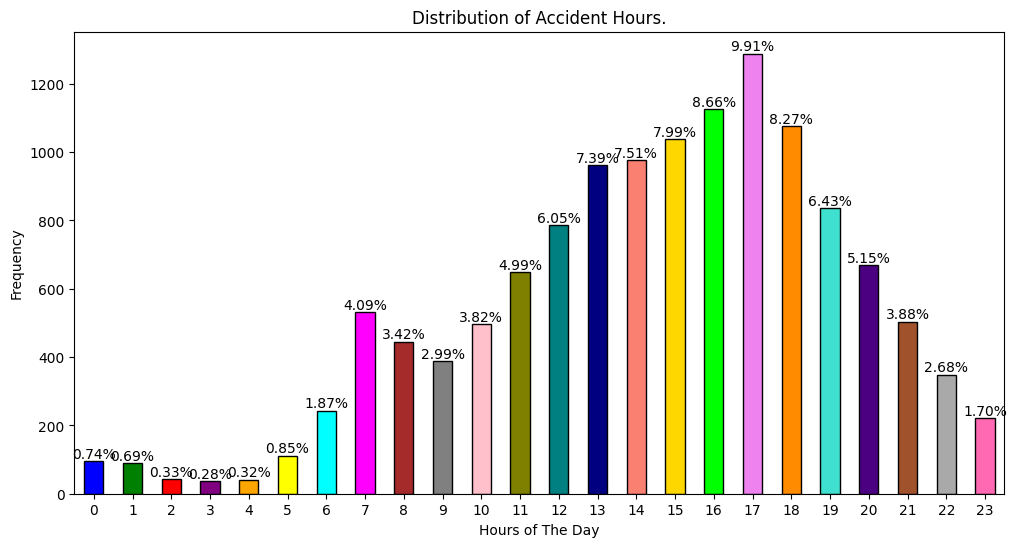

In [144]:
# Plotting a bar chart accident occurrances for each hour of the day and respective proportions.

bar_plot(hr_df2, "dist_acc_hr_q2")

Generally, the significant hours which accident occurs are between hour 7 & 8 and hour 16 & 18. This is mostly likely due to the early morning and late evening rush to and from different destinations. Hours 17, 16 and 18 are top hours of accident.

### Days of Week With Most Accident

In [145]:
# Creating a new dataseries and replacing with the mapped values.

day_of_week_new_df2 = days_mapper(df2_cc)

In [146]:
# Creating a variable that stores the count of the newly mapped dataseries.

day_of_week_new_count_df2 = map_count(day_of_week_new_df2)

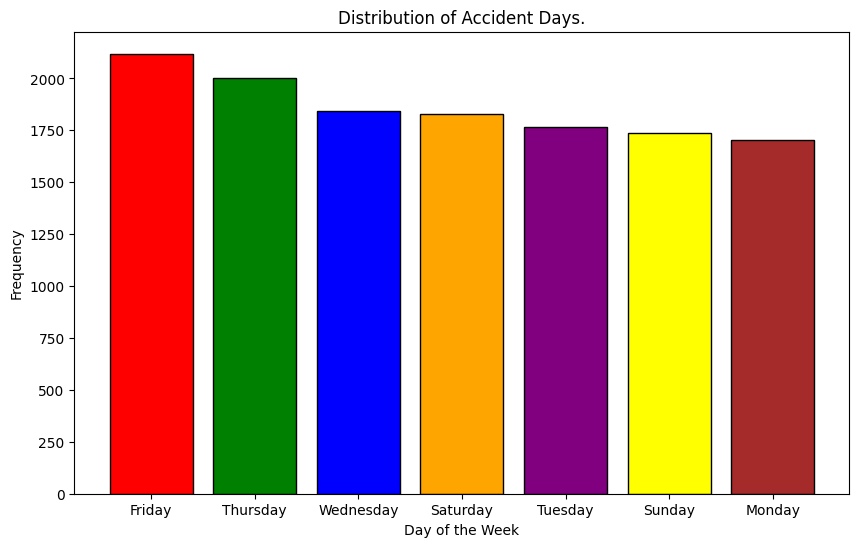

In [147]:
# Plotting a bar chart showing the accident frequency for each day of the week.

days_bar_plotter(day_of_week_new_count_df2, "dis_acc_days_q2")

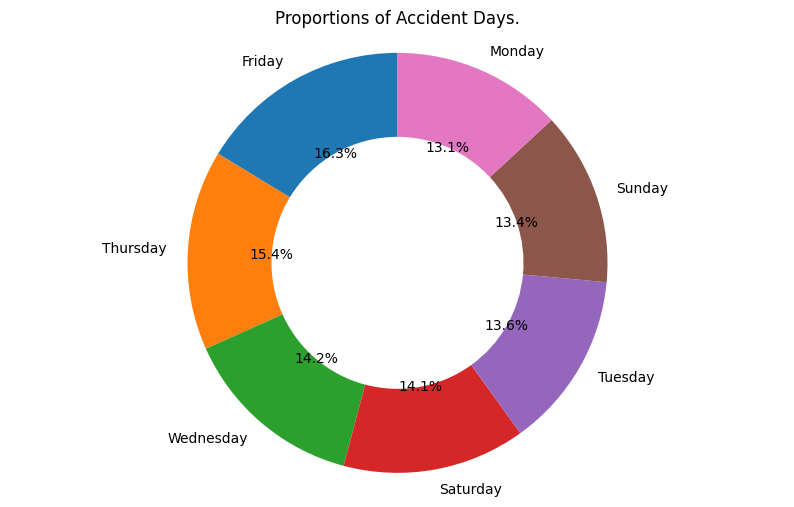

In [148]:
# Plotting Pie Chart for accident days.

pie_plotter(day_of_week_new_count_df2, "pie_days_q2")

In [149]:
# Displaying the total number of accidents for each day.

day_acc_total(day_of_week_new_count_df2)

The number of accidents on Fridays is 2119.
The number of accidents on Thursdays is 2002.
The number of accidents on Wednesdays is 1841.
The number of accidents on Saturdays is 1830.
The number of accidents on Tuesdays is 1765.
The number of accidents on Sundays is 1738.
The number of accidents on Mondays is 1703.


Thursdays and Fridays are the most significant days that accident occurs.

### Plotting Time Stamp

In [150]:
df2_cc_combined = pd.concat([day_of_week_new_df2, hr_df2], axis=1)
df2_cc_combined.columns = ["day_of_week", "hour_of_day"]

In [151]:
grouped_df2_cc = df2_cc_combined.groupby(["day_of_week", "hour_of_day"]).size()

In [152]:
pivot_df2_cc = grouped_df2_cc.unstack(level="day_of_week")

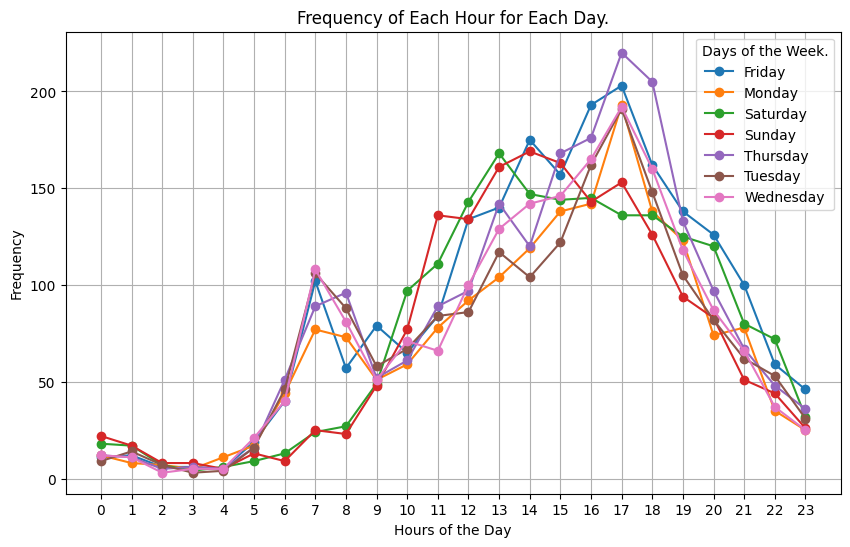

In [153]:
pivot_df2_cc.plot(kind="line", marker="o", figsize=(10, 6))
plt.xlabel("Hours of the Day")
plt.ylabel("Frequency")
plt.title("Frequency of Each Hour for Each Day.")
plt.xticks(range(24), range(24))  # Assuming hours are integers from 0 to 23
plt.legend(title="Days of the Week.")
plt.grid(True)
plt.savefig("time_stamp_q2", dpi=300, bbox_inches='tight')
plt.show()

The time stamp corroborates the initial findings that the significant hour periods are 7 – 8 and 16 – 18. And significant days of accidents are Thursdays and Fridays. 

#### Locations of Accident During Significants Hours and Days.

In [154]:
# Introducing a new dataseries containing only hour of time.

df2_cc["hour"] = hr_df2.copy()

In [155]:
# Creating a dataframe containing accidents that occurred during the significants hours and days.

df2_cc2 = df2_cc[((((df2_cc["hour"] >= 7) & (df2_cc["hour"] < 9)) | ((df2_cc["hour"] >= 16) & (df2_cc["hour"] < 19))) & ((df2_cc["day_of_week"] >=5) & (df2_cc["day_of_week"] <7)))]

In [156]:
# Combining longitude and latitude columns to create a Point geometry column.
geo_df2_cc2 = [Point(lon, lat) for lon, lat in zip(df2_cc2["longitude"], df2_cc2["latitude"])]

# Creating a GeoDataFrame with the original DataFrame and the Point geometries.
gdf2 = gpd.GeoDataFrame(df2_cc2, geometry = geo_df2_cc2, crs = "EPSG:4326")


In [157]:
# Loading the UK map shapefile (you can download shapefiles from various sources).
uk_map = gpd.read_file("./UK_DISTRICTS_COUNTIES_CENSUS2011.shp")

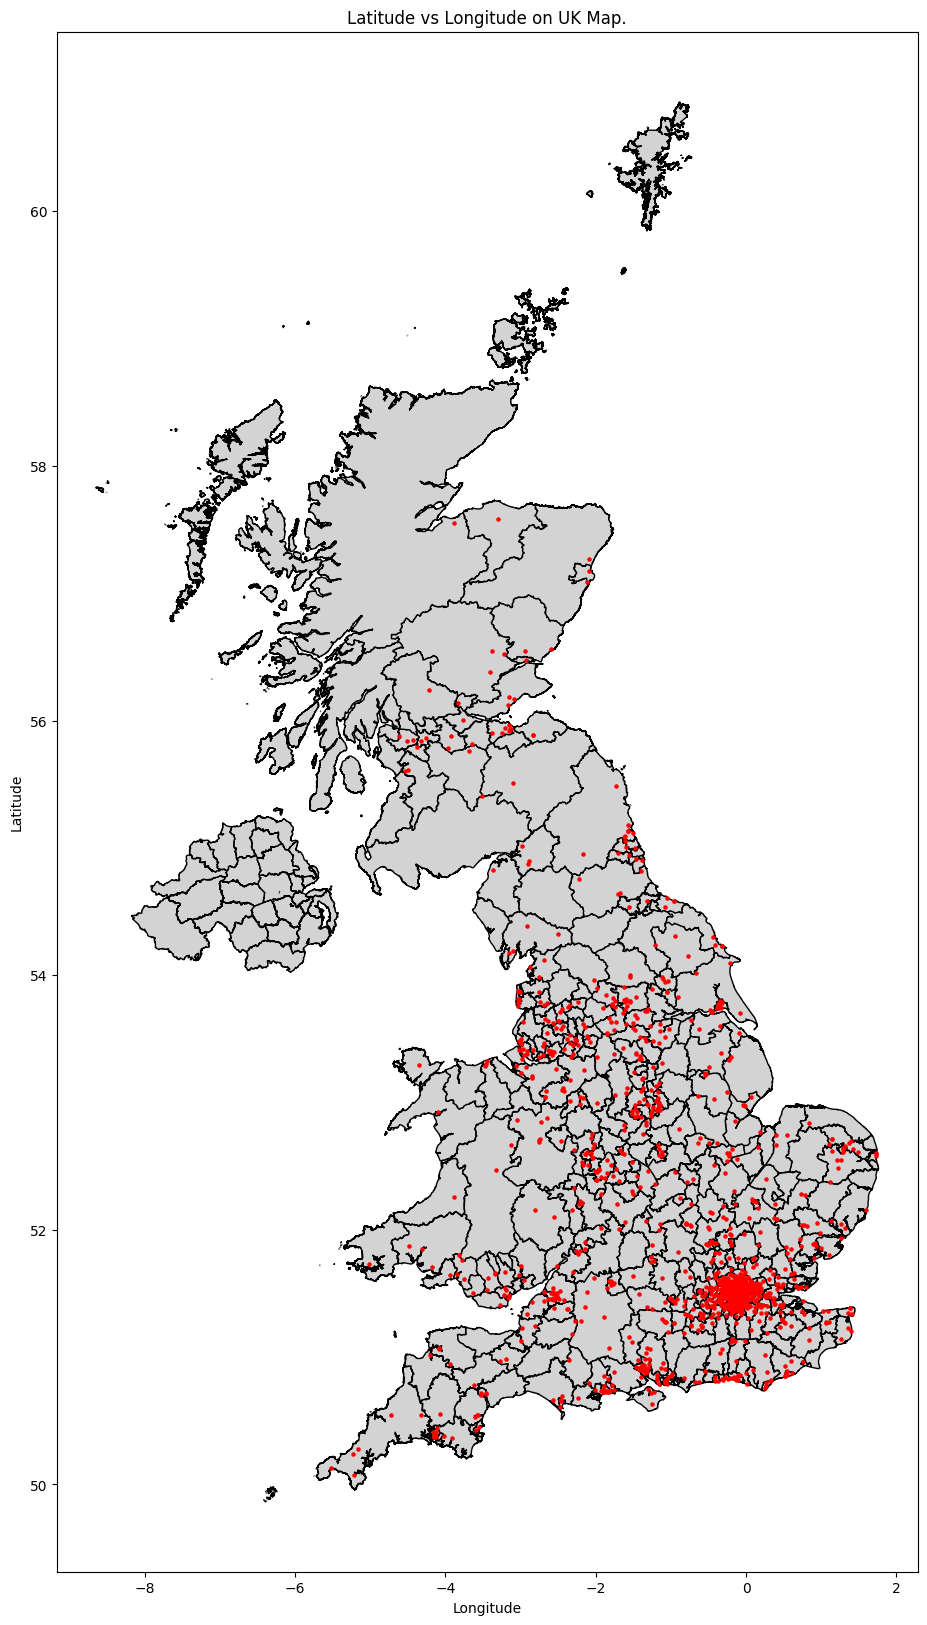

In [158]:
# Creating the plot.
fig, ax = plt.subplots(figsize = (20, 20))

# Plotting the world map.
uk_map.plot(ax = ax, color= "lightgray", edgecolor= "black")

# Plotting the GeoDataFrame with latitude and longitude data on the world map.
gdf2.plot(ax = ax, color = "red", markersize = 5)

# Adding title and labels.
plt.title("Latitude vs Longitude on UK Map.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("acc_loc_q2", dpi=300, bbox_inches='tight')

# Showing the plot.
plt.show()

In [159]:
"""
Creating a folium map (Reinking, 2023).
Source: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium
"""

folium_map_2 = folium.Map(prefer_canvas=True)

def folium_plotter2(plot):
    folium.CircleMarker(location=[plot.latitude, plot.longitude],
                        radius=2,
                        weight=5).add_to(folium_map_2)

# Iterating through every row in the dataframe.
df2_cc2.apply(folium_plotter2, axis = 1)


#Setting the zoom to the maximum possible.
folium_map_2.fit_bounds(folium_map_2.get_bounds())

#Saving the map to an HTML file.
folium_map_2.save("./acc_loc_folium_q2.html")

#### Conditions

###### Speed Limit

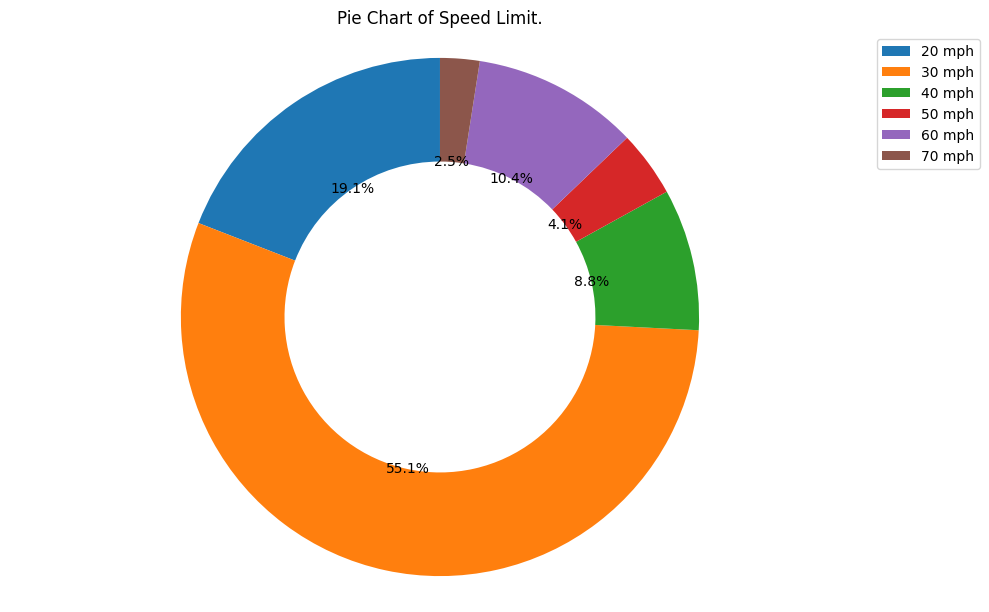

In [160]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df2_cc2["speed_limit"], speed_labels, "Speed Limit", "spd_cond_q2")

Most accidents during the significant period and days occurred within speed limit of 30 mph.

###### Light Conditions

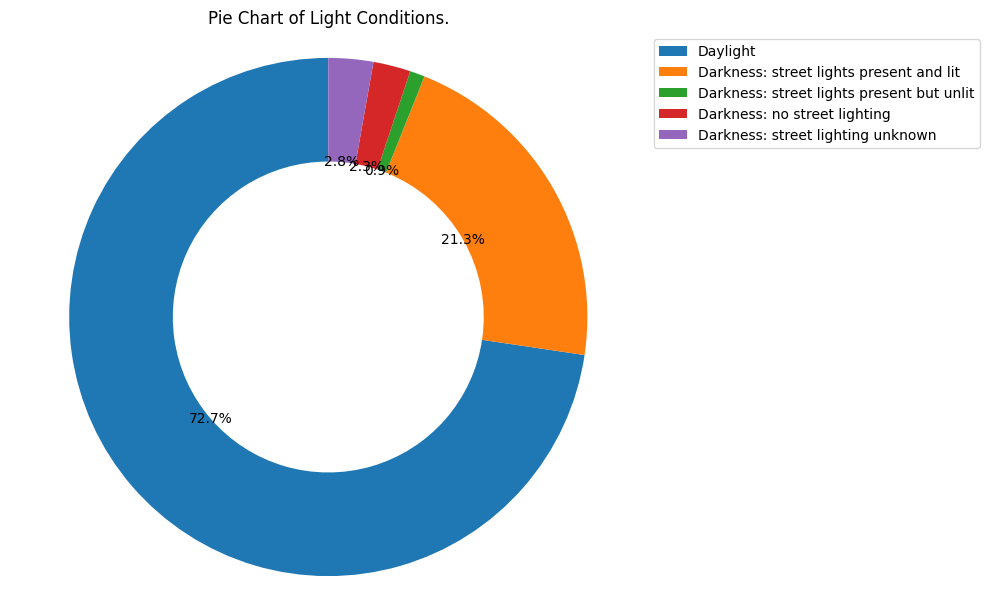

In [161]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df2_cc2["light_conditions"], light_labels, "Light Conditions", "lit_cond_q2")

Most accidents during the significant period and days occurred during daylight.

###### Weather Conditions

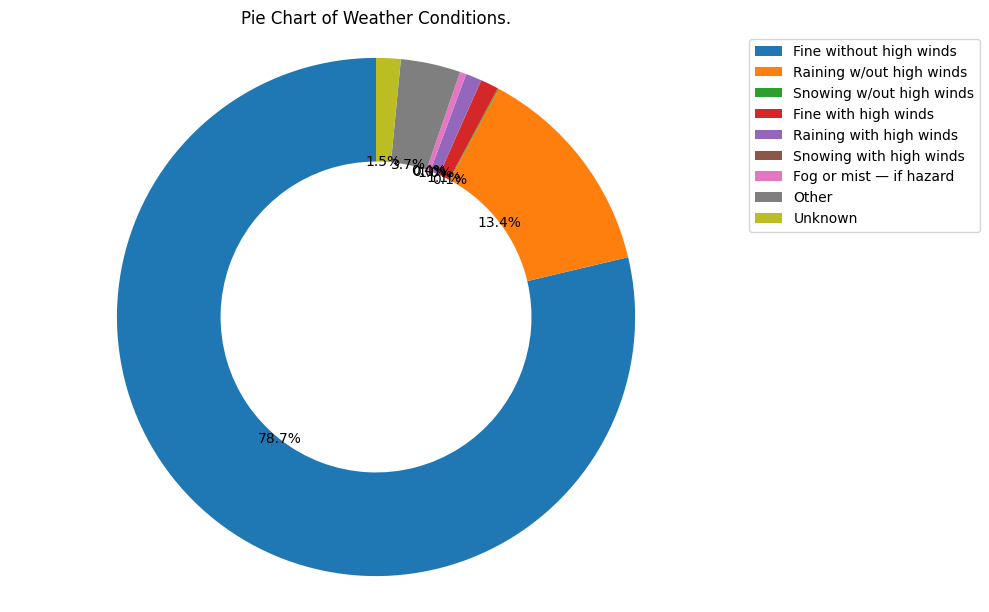

In [162]:
cond_plotter(df2_cc2["weather_conditions"], weather_labels, "Weather Conditions", "wth_cond_q2")

Most accidents during the significant period and days occurred during fine weather without high winds.

##### Road Surface Conditions

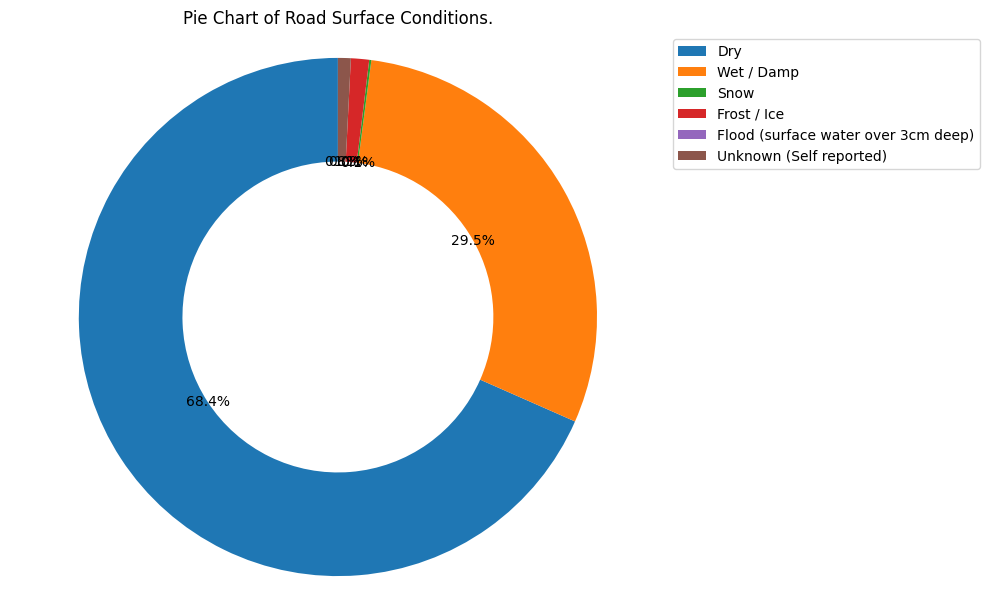

In [163]:
cond_plotter(df2_cc2["road_surface_conditions"], rsc_labels, "Road Surface Conditions", "rsc_cond_q2")

Most accidents during the significant period and days occurred on dry road surface.

##### Special Conditions at Site

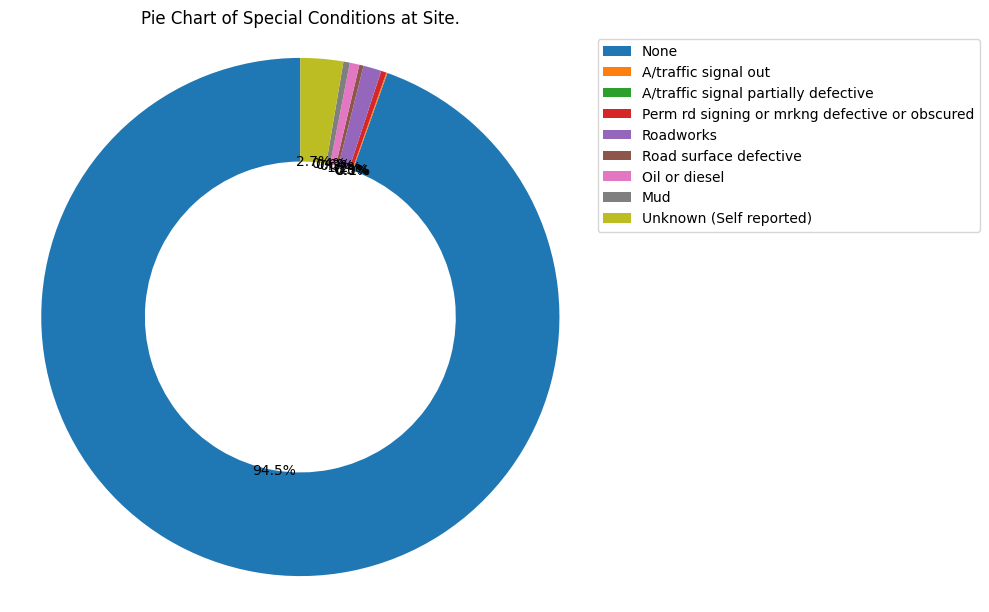

In [164]:
cond_plotter(df2_cc2["special_conditions_at_site"], scs_labels, "Special Conditions at Site", "scs_cond_q2")

Most accidents during the significant period and days occurred within no special conditions at site.

##### Accident Severity

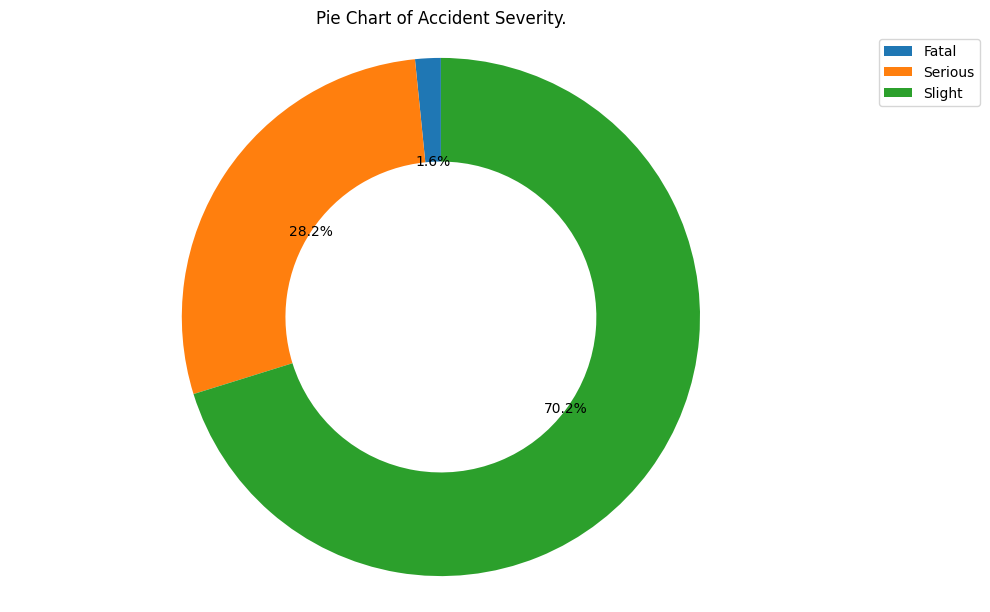

In [165]:
cond_plotter(df2_cc2["accident_severity"], acc_sev_labels, "Accident Severity", "acc_sev_q2")

Most accidents during the significant period and days were slightly severe.

##### Heat Map

In [166]:
df2_cc3 = df2_cc2.copy() # Creating new dataframe from df2_cc2.
df2_cc3["day_of_week_txt"] = day_of_week_new_df2 # Adding the mapped days dataseries.

In [167]:
# Creating a dictionary for the brands of Motorcycle.

df2_brands = {3 : "Motorcycle 125cc and under",
              4 : "Motorcycle over 125cc and up to 500cc",
              5 : "Motorcycle over 500cc"}

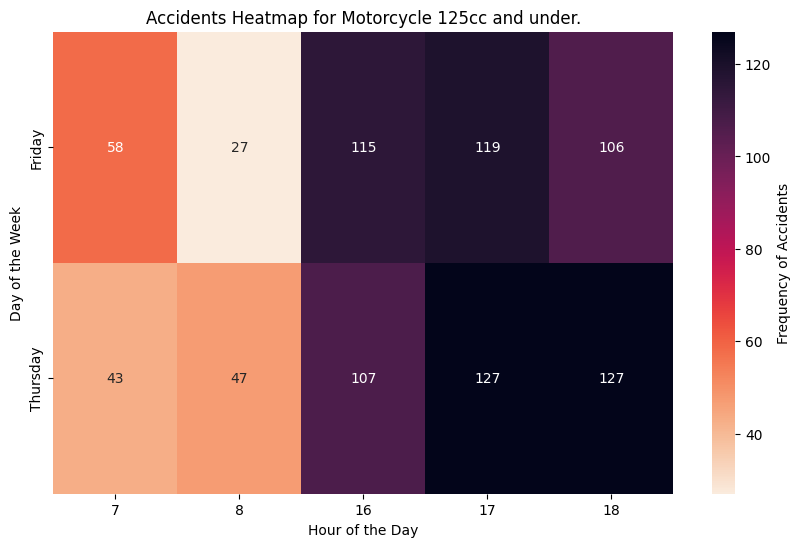

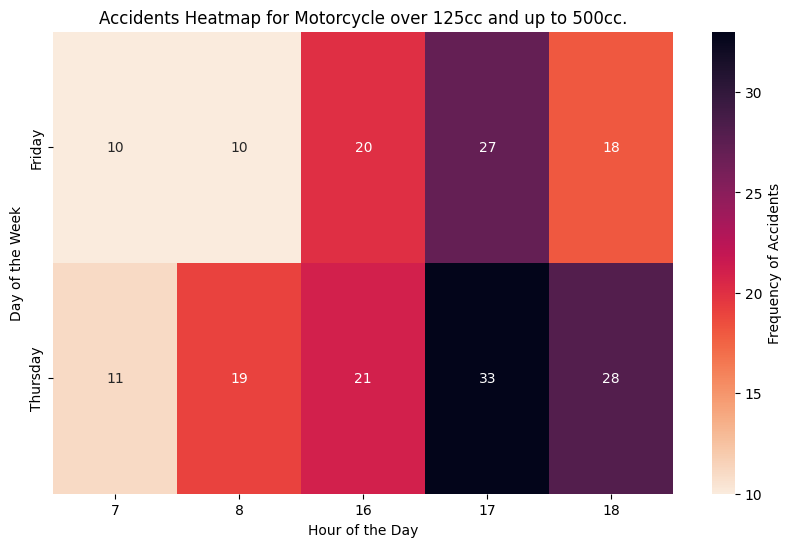

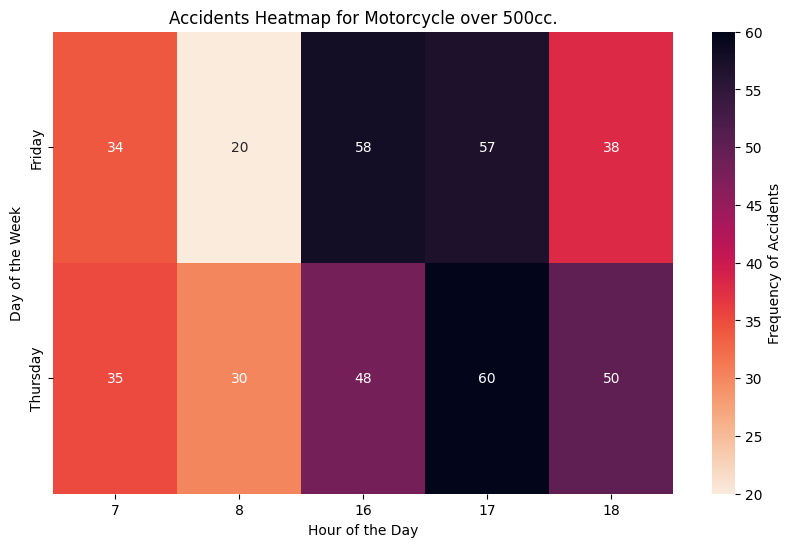

In [168]:
"""
(Display the Pandas DataFrame in Heatmap style, 2020)
Source: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
"""


# Creating a pivot table to aggregate data by motorcycle brands, day of week, and hour.
df2_pivot_table = df2_cc3.pivot_table(index = "day_of_week_txt", columns = "hour", values = "vehicle_type", aggfunc = "count")

# Creating a subplot for each motorcycle brands.
for d in df2_brands.keys():
    # Filteing data for the current brand.
    brand_data = df2_cc3[df2_cc2["vehicle_type"] == d]
    
    # Creating a pivot table for the current brand.
    brand_pivot_table = brand_data.pivot_table(index = "day_of_week_txt", columns = "hour", values = "vehicle_type", aggfunc = "count")
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Accidents Heatmap for {df2_brands[d]}.")
    
    # Creating the heatmap.
    cmap = sns.cm.rocket_r
    heatmap = sns.heatmap(brand_pivot_table, cmap = cmap, annot = True, fmt = "g", cbar = True)
    
    plt.xlabel("Hour of the Day")
    plt.ylabel("Day of the Week")
    cbar = heatmap.collections[0].colorbar
    cbar.set_label("Frequency of Accidents")
    plt.savefig(f"heat_map_{d}", dpi = 300, bbox_inches = "tight")
    plt.show()

### 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [169]:
query_3 = """
SELECT a.accident_index, a.date, a.time, a.day_of_week, a.accident_severity, a.longitude, a.latitude, a.speed_limit, a.light_conditions, a.weather_conditions, a.road_surface_conditions, a.special_conditions_at_site
FROM accident as a
INNER JOIN casualty as c ON a.accident_index = c.accident_index
WHERE a.accident_year = 2020 AND c.casualty_class = 3
"""

df3 = pd.read_sql(query_3, con)
df3

accident_index        date   time  day_of_week  accident_severity  \
0      2020010219808  04/02/2020  09:00            3                  3   
1      2020010220496  27/04/2020  13:55            2                  3   
2      2020010220496  27/04/2020  13:55            2                  3   
3      2020010228005  01/01/2020  01:25            4                  3   
4      2020010228006  01/01/2020  01:50            4                  2   
...              ...         ...    ...          ...                ...   
14745  2020991023621  10/11/2020  10:30            3                  2   
14746  2020991023880  14/12/2020  17:00            2                  3   
14747  2020991024526  17/11/2020  12:00            3                  3   
14748  2020991029573  13/11/2020  15:05            6                  3   
14749  2020991032575  25/08/2020  13:50            3                  3   

       longitude   latitude  speed_limit  light_conditions  \
0      -0.254001  51.462262           20                 1   
1      -0.139253  51.470327           20                 1   
2      -0.139253  51.470327           20                 1   
3      -0.178719  51.529614           30                 4   
4      -0.001683  51.541210           30                 4   
...          ...        ...          ...               ...   
14745  -2.946947  56.491558           20                 1   
14746  -2.927095  56.468699           30                 4   
14747  -3.841439  56.331864           60                 1   
14748  -4.267565  55.802353           30                 1   
14749  -4.561040  56.003843           30                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       9                        9                           0  
1                       1                        1                           0  
2                       1                        1                           0  
3                       1                        2                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
14745                   9                        2                           0  
14746                   1                        2                           0  
14747                   2                        2                           0  
14748                   1                        1                           0  
14749                   1                        1                           0  

[14750 rows x 12 columns]

### EDA for The Columns Relevant to Question 3.

In [170]:
# Retrieving information of dataframe df2.

info_chk(df3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14750 entries, 0 to 14749
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   accident_index              14750 non-null  object 
 1   date                        14750 non-null  object 
 2   time                        14750 non-null  object 
 3   day_of_week                 14750 non-null  int64  
 4   accident_severity           14750 non-null  int64  
 5   longitude                   14750 non-null  float64
 6   latitude                    14750 non-null  float64
 7   speed_limit                 14750 non-null  int64  
 8   light_conditions            14750 non-null  int64  
 9   weather_conditions          14750 non-null  int64  
 10  road_surface_conditions     14750 non-null  int64  
 11  special_conditions_at_site  14750 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1.4+ MB


In [171]:
# Retrieving information of dataframe df2.

df_null_chk(df3)

accident_index                0
date                          0
time                          0
day_of_week                   0
accident_severity             0
longitude                     0
latitude                      0
speed_limit                   0
light_conditions              0
weather_conditions            0
road_surface_conditions       0
special_conditions_at_site    0
dtype: int64

In [172]:
# Retrieving the describe information of dataframe df2.

df_desc_chk(df3)

day_of_week  accident_severity     longitude      latitude  \
count  14750.000000       14750.000000  14750.000000  14750.000000   
mean       4.181627           2.674644     -1.270653     52.482535   
std        1.863656           0.519053      1.374930      1.373398   
min        1.000000           1.000000     -7.321385     50.046635   
25%        3.000000           2.000000     -2.173951     51.488284   
50%        4.000000           3.000000     -1.183857     51.935491   
75%        6.000000           3.000000     -0.134586     53.429604   
max        7.000000           3.000000      1.750759     58.592504   

        speed_limit  light_conditions  weather_conditions  \
count  14750.000000      14750.000000        14750.000000   
mean      29.777695          2.066780            1.791932   
std        7.614340          1.670157            1.996071   
min       -1.000000          1.000000            1.000000   
25%       30.000000          1.000000            1.000000   
50%       30.000000          1.000000            1.000000   
75%       30.000000          4.000000            1.000000   
max       70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             14750.000000                14750.000000  
mean                  1.377627                    0.194712  
std                   0.941960                    1.208227  
min                  -1.000000                   -1.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

##### Date

In [173]:
# Checking if the date column has any blank records or None values.

ds_empty_chk(df3, "date")

0

##### Time

In [174]:
# Checking if the time column has any blank records or None values.

ds_empty_chk(df3, "time")

0

##### Day of Week

In [175]:
# Checking if the day of week column has any blank records or None values.

ds_empty_chk(df3, "day_of_week")

0

In [176]:
# Retrieving the unique values of the day_of_week column.

ds_unique_chk(df3, "day_of_week")

array([3, 2, 4, 5, 6, 7, 1], dtype=int64)

##### Accident Severity

In [177]:
# Checking if the accident severity column has any blank records or None values.

ds_empty_chk(df3, "accident_severity")

0

In [178]:
# Retrieving the unique values of the accident severity column.

ds_unique_chk(df3, "accident_severity")

array([3, 2, 1], dtype=int64)

#####  Latitude and Longitude Columns

In [179]:
# Checking if the longtitude column has any blank records or None values.

ds_empty_chk(df3, "longitude")

0

In [180]:
# Checking if the latitude column has any blank records or None values.

ds_empty_chk(df3, "latitude")

0

##### Speed Limit

In [181]:
# Checking if the speed limit column has any blank records or None values.

ds_empty_chk(df3, "speed_limit")

0

In [182]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df3, "speed_limit")

array([20, 30, 40, 60, -1, 50, 70], dtype=int64)

In [183]:
"""
A function that converts the specified value of a dataframe column to NaN.
"""

def func_null(df_res_null, res_null, ds_res_null):
    df_res_null.loc[res_null, ds_res_null] = np.nan

In [184]:
# Creating a variable that stores all records where speed limit is -1.

sp_limit_m1 = df3["speed_limit"] == -1

In [185]:
# Replacing speed limit -1 with np.nan.

func_null(df3, sp_limit_m1, "speed_limit")

##### Light Conditions

In [186]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df3, "light_conditions")

0

In [187]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df3, "light_conditions")

array([1, 4, 7, 5, 6], dtype=int64)

##### Special Conditions at Site

In [188]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df3, "special_conditions_at_site")

0

In [189]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df3, "special_conditions_at_site")

array([ 0,  4,  5,  9,  1,  3,  7,  6,  2, -1], dtype=int64)

In [190]:
df3_scas_new = df3["special_conditions_at_site"].map(scas_mapping) # Creating a new dataseries and replacing with the mapped values.
df3_scas_new_count = df3_scas_new.value_counts()

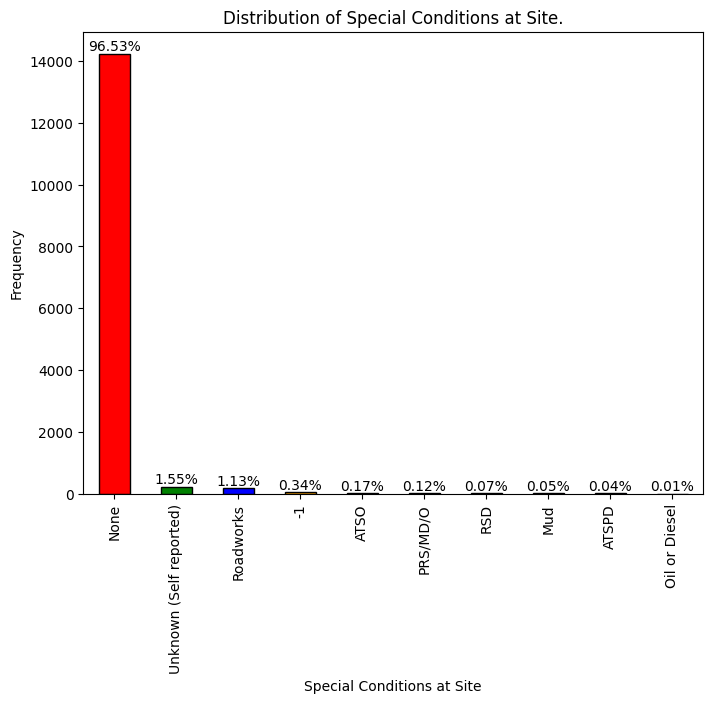

In [191]:
# Plotting a bar plot that displays distribution of special conditions at site.

plt.figure(figsize = (8, 6))
df3_scas_new_count.plot(kind = "bar", color = colour_bar_scas, edgecolor="black")
df3_total_data_points = len(df3_scas_new)
plt.xlabel("Special Conditions at Site")
plt.ylabel("Frequency")
plt.title("Distribution of Special Conditions at Site.")
plt.xticks(rotation=90)
plt.grid(False)

for bar3 in plt.gca().patches:
    percentage = (bar3.get_height() / df3_total_data_points) * 100
    plt.text(bar3.get_x() + bar3.get_width() / 2, bar3.get_height(), f"{percentage:.2f}%", 
             ha="center", va="bottom")
plt.savefig("dist_special_conditions_df3", dpi=300, bbox_inches='tight')
plt.show()

In [192]:
"""
Values for Special Conditions at Site are difficult to infer.
Also from the EDA approximately 97% of these conditions are None (0), which could be that it was difficult to tell the conditions...
... or there are none.
The incorrect values -1 would be replaced with 0 meaning None.
"""

df3["special_conditions_at_site"].replace([-1], 0, inplace = True) 

##### Weather Conditions

In [193]:
# Checking if the weather conditions column has any blank records or None values.

ds_empty_chk(df3, "weather_conditions")

0

In [194]:
# Retrieving the unique values of the weather conditions column.

ds_unique_chk(df3, "weather_conditions")

array([9, 1, 8, 2, 4, 5, 3, 7, 6], dtype=int64)

##### Road Surface Conditions

In [195]:
# Checking if the day_of_week data series from df3 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df3, "road_surface_conditions")

0

In [196]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df3, "road_surface_conditions")

array([ 9,  1,  2,  4,  3,  5, -1], dtype=int64)

In [197]:
# Changed road surface conditions in dataframe df3 with values -1 and 9 for all accidents that occurred while raining was changed to wet/damp (2).

scas_filter1(df3)

In [198]:
# Changed road surface conditions in dataframe df3 with values -1 and 9 for all accidents that occurred while snowing without high winds was changed to snow (3).


scas_filter2(df3, 3, 3)

In [199]:
# Changed road surface conditions in dataframe df3 with values -1 and 9 for all accidents that occurred while it was foggy or misty was changed to wet/damp (2)..


scas_filter2(df3, 7, 2)

In [200]:
"""
There are no records where the weather condition was snowing with high winds and...
... road surface conditions was either -1 or 9.
"""

df3[(df3["weather_conditions"] == 6) & ((df3["road_surface_conditions"] == -1))]

Empty DataFrame
Columns: [accident_index, date, time, day_of_week, accident_severity, longitude, latitude, speed_limit, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site]
Index: []

In [201]:
"""
Changing road surface conditions in dataframe df3 with values -1 for all accidents that occurred while the ..
.... weather conditons are 1, 4, 8 and 9 to np.nan in order to implement MICE.

"""

scas_filter3(df3)

#### Multiple Imputation Using Chain Equations (MICE)

MICE would generate and impute estimated values for all missing records (NaN) in the dataframe.

In [202]:
# Creating a copy of dataframe df2.
df3_cc = df3.copy()

In [203]:
# Removing the accident_index, date and time columns in dataframe df2_cc.

q3_mice_col = ["accident_index", "date", "time"]


mice_col_remover(df3_cc, q3_mice_col)

In [204]:
# Executing MICE.

df3_cc = mice_exec(df3_cc, 3)

In [205]:
"""Retrieving the dataframe df3_cc describe information in order to compare data distribution values with....
... uncleaned dataframe df3. 
"""

df_desc_chk(df3_cc)

day_of_week  accident_severity     longitude      latitude  \
count  14750.000000       14750.000000  14750.000000  14750.000000   
mean       4.181627           2.674644     -1.270653     52.482535   
std        1.863656           0.519053      1.374930      1.373398   
min        1.000000           1.000000     -7.321385     50.046635   
25%        3.000000           2.000000     -2.173951     51.488284   
50%        4.000000           3.000000     -1.183857     51.935491   
75%        6.000000           3.000000     -0.134586     53.429604   
max        7.000000           3.000000      1.750759     58.592504   

        speed_limit  light_conditions  weather_conditions  \
count  14750.000000      14750.000000        14750.000000   
mean      29.794576          2.066780            1.791932   
std        7.577554          1.670157            1.996071   
min       20.000000          1.000000            1.000000   
25%       30.000000          1.000000            1.000000   
50%       30.000000          1.000000            1.000000   
75%       30.000000          4.000000            1.000000   
max       70.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  
count             14750.000000                14750.000000  
mean                  1.389288                    0.198102  
std                   0.929354                    1.206272  
min                   1.000000                    0.000000  
25%                   1.000000                    0.000000  
50%                   1.000000                    0.000000  
75%                   2.000000                    0.000000  
max                   9.000000                    9.000000

In [206]:
# Converting the road surface condition column back to int64.

ds_type_conv(df3_cc, "road_surface_conditions")

In [207]:
# Converting the speed limit column back to int64.

ds_type_conv(df3_cc, "speed_limit")

In [208]:
# Returning the all columns with datatype object that were drop earlier to implement MICE.

col_add(df3_cc, df3, q3_mice_col)

In [209]:
df3_cc

accident_index        date   time  day_of_week  accident_severity  \
0      2020010219808  04/02/2020  09:00            3                  3   
1      2020010220496  27/04/2020  13:55            2                  3   
2      2020010220496  27/04/2020  13:55            2                  3   
3      2020010228005  01/01/2020  01:25            4                  3   
4      2020010228006  01/01/2020  01:50            4                  2   
...              ...         ...    ...          ...                ...   
14745  2020991023621  10/11/2020  10:30            3                  2   
14746  2020991023880  14/12/2020  17:00            2                  3   
14747  2020991024526  17/11/2020  12:00            3                  3   
14748  2020991029573  13/11/2020  15:05            6                  3   
14749  2020991032575  25/08/2020  13:50            3                  3   

       longitude   latitude  speed_limit  light_conditions  \
0      -0.254001  51.462262           20                 1   
1      -0.139253  51.470327           20                 1   
2      -0.139253  51.470327           20                 1   
3      -0.178719  51.529614           30                 4   
4      -0.001683  51.541210           30                 4   
...          ...        ...          ...               ...   
14745  -2.946947  56.491558           20                 1   
14746  -2.927095  56.468699           30                 4   
14747  -3.841439  56.331864           60                 1   
14748  -4.267565  55.802353           30                 1   
14749  -4.561040  56.003843           30                 1   

       weather_conditions  road_surface_conditions  special_conditions_at_site  
0                       9                        9                           0  
1                       1                        1                           0  
2                       1                        1                           0  
3                       1                        2                           0  
4                       1                        1                           0  
...                   ...                      ...                         ...  
14745                   9                        2                           0  
14746                   1                        2                           0  
14747                   2                        2                           0  
14748                   1                        1                           0  
14749                   1                        1                           0  

[14750 rows x 12 columns]

### Analysis

### Hours of the day with most accidents

In [210]:
"""
Creating a datatime object from the time dataseries. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

time_ds_df3 = obj_time(df3_cc, "time", "%H:%M") 

In [211]:
# Extracting the hours from the datetime object.

hr_df3 = hr_extract(time_ds_df3)

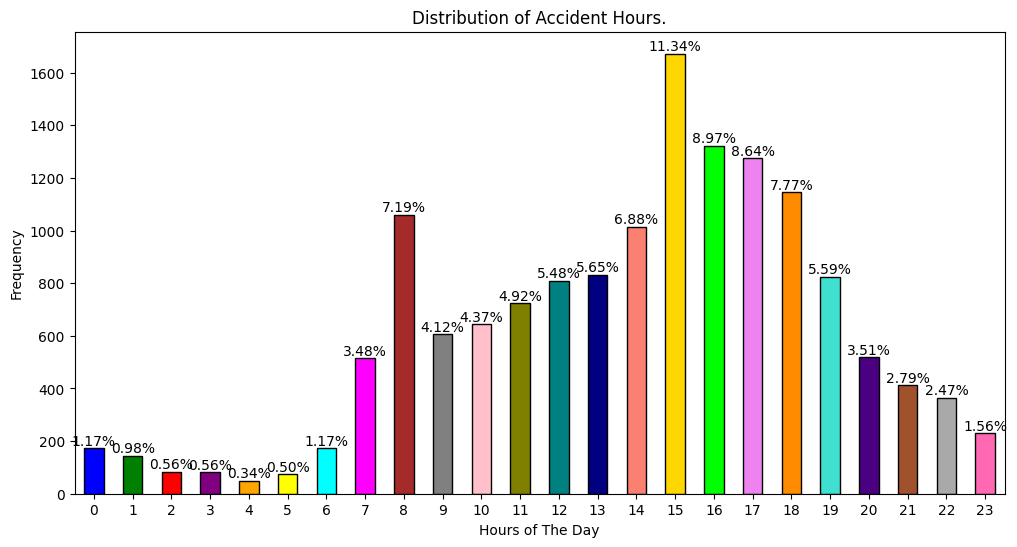

In [212]:
# Plotting a bar chart accident occurrances for each hour of the day and respective proportions.

bar_plot(hr_df3, "dist_acc_hr_q3")

Generally, the significant hours which accident occurs are between hour 7 & 8 and hour 14 & 18. This is mostly likely due to the early morning and late evening rush to and fro different destinations. Hours 17, 16 and 15 are top hours of accident.

### Days of Week With Most Accident

In [213]:
# Creating a new dataseries and replacing with the mapped values.

day_of_week_new_df3 = days_mapper(df3_cc)

In [214]:
# Creating a variable that stores the count of the newly mapped dataseries.

day_of_week_new_count_df3 = map_count(day_of_week_new_df3)

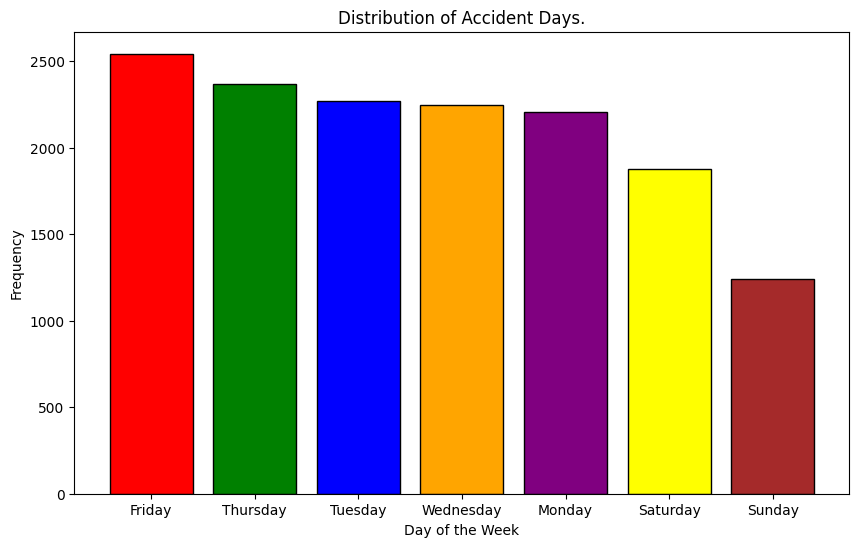

In [215]:
# Plotting a bar chart showing the accident frequency for each day of the week.

days_bar_plotter(day_of_week_new_count_df3, "dis_acc_days_q3")

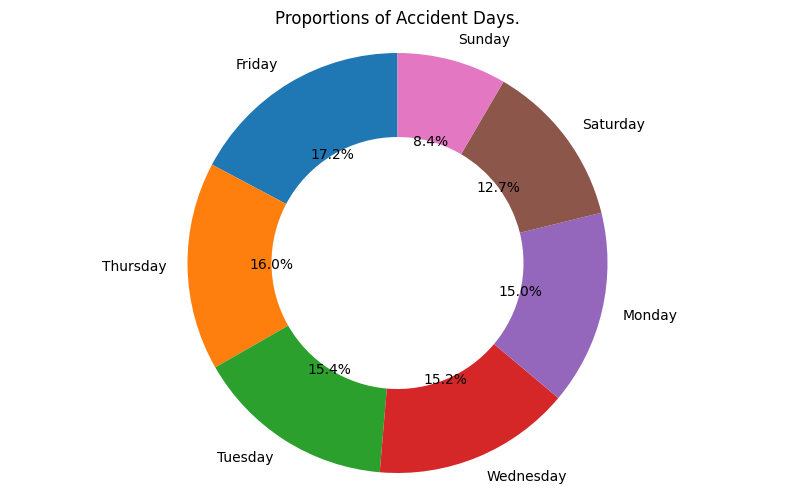

In [216]:
# Plotting Pie Chart for accident days.

pie_plotter(day_of_week_new_count_df3, "pie_days_q3")

In [217]:
# Displaying the total number of accidents for each day.

day_acc_total(day_of_week_new_count_df3)

The number of accidents on Fridays is 2543.
The number of accidents on Thursdays is 2366.
The number of accidents on Tuesdays is 2267.
The number of accidents on Wednesdays is 2247.
The number of accidents on Mondays is 2207.
The number of accidents on Saturdays is 1878.
The number of accidents on Sundays is 1242.


The weekdays (Monday - Friday) are the significant days that accident occur.

### Plotting Time Stamp

In [218]:
df3_cc_combined = pd.concat([day_of_week_new_df3, hr_df3], axis=1)
df3_cc_combined.columns = ["day_of_week", "hour_of_day"]

In [219]:
grouped_df3_cc = df3_cc_combined.groupby(["day_of_week", "hour_of_day"]).size()

In [220]:
pivot_df3_cc = grouped_df3_cc.unstack(level="day_of_week")

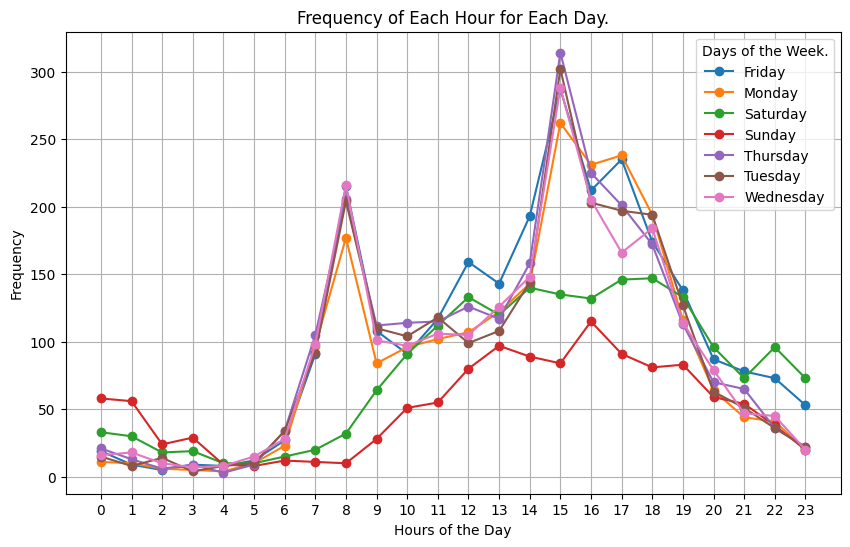

In [221]:
# Plotting a bar plot.

pivot_df3_cc.plot(kind="line", marker="o", figsize=(10, 6))
plt.xlabel("Hours of the Day")
plt.ylabel("Frequency")
plt.title("Frequency of Each Hour for Each Day.")
plt.xticks(range(24), range(24))  # Assuming hours are integers from 0 to 23
plt.legend(title="Days of the Week.")
plt.grid(True)
plt.savefig("time_stamp_q3", dpi=300, bbox_inches='tight')
plt.show()

#### Locations of Accident During Significants Hours and Days.

In [222]:
# Introducing a new dataseries containing only hour of time.

df3_cc["hour"] = hr_df3.copy()

In [223]:
# Creating a dataframe containing accidents that occurred during the significants hours and days.

df3_cc2 = df3_cc[((((df3_cc["hour"] >= 7) & (df3_cc["hour"] < 9)) | ((df3_cc["hour"] >= 14) & (df3_cc["hour"] < 19))) & ((df3_cc["day_of_week"] >=2) & (df3_cc["day_of_week"] <7)))]

In [224]:
# Combining longitude and latitude columns to create a Point geometry column.
geo_df3_cc2 = [Point(lon, lat) for lon, lat in zip(df3_cc2["longitude"], df3_cc2["latitude"])]

# Creating a GeoDataFrame with the original DataFrame and the Point geometries.
gdf3 = gpd.GeoDataFrame(df3_cc2, geometry = geo_df3_cc2, crs = "EPSG:4326")


In [225]:
# Loading the UK map shapefile (you can download shapefiles from various sources).
uk_map = gpd.read_file("./UK_DISTRICTS_COUNTIES_CENSUS2011.shp")

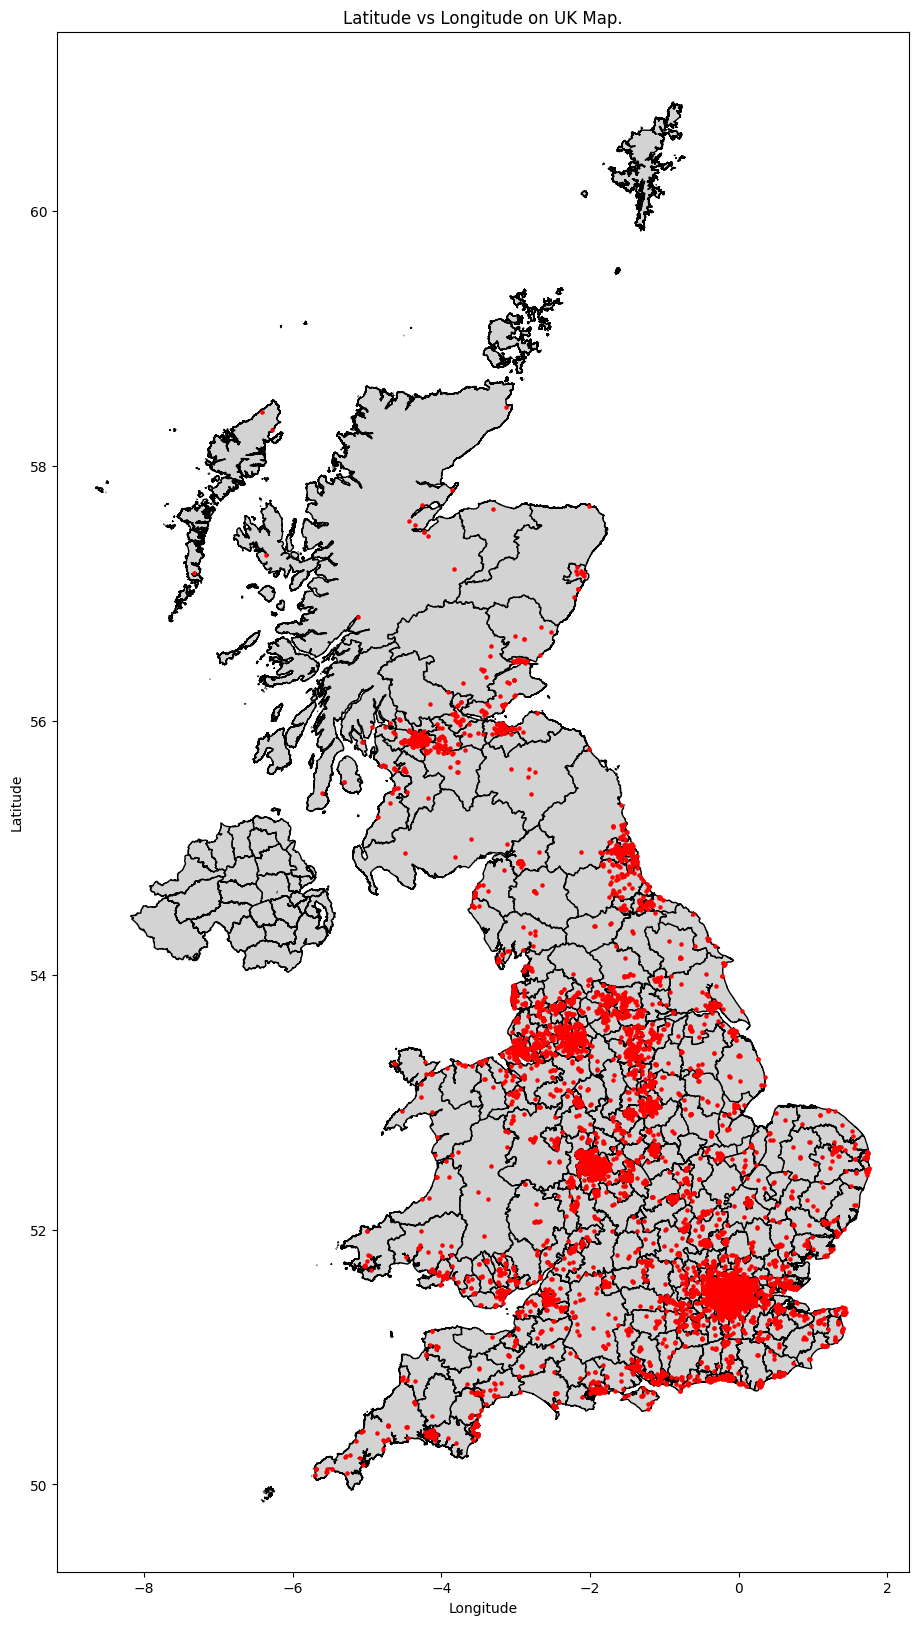

In [226]:
# Creating the plot.
fig, ax = plt.subplots(figsize = (20, 20))

# Plotting the world map.
uk_map.plot(ax = ax, color= "lightgray", edgecolor= "black")

# Plotting the GeoDataFrame with latitude and longitude data on the world map.
gdf3.plot(ax = ax, color = "red", markersize = 5)

# Adding title and labels.
plt.title("Latitude vs Longitude on UK Map.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("acc_loc_q3", dpi=300, bbox_inches='tight')

# Showing the plot.
plt.show()

Majority of accident within the significant periods occurred in the London Metropolitan region.

In [227]:
"""
Creating a folium map (Reinking, 2023).
Source: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium
"""

folium_map_3 = folium.Map(prefer_canvas=True)

def folium_plotter3(plot):
    folium.CircleMarker(location=[plot.latitude, plot.longitude],
                        radius=2,
                        weight=5).add_to(folium_map_3)

# Iterating through every row in the dataframe.
df3_cc2.apply(folium_plotter3, axis = 1)


# Setting the zoom to the maximum possible.
folium_map_3.fit_bounds(folium_map_3.get_bounds())

# Saving the map to an HTML file.
folium_map_3.save("./acc_loc_folium_q3.html")

#### Conditions

###### Speed Limit

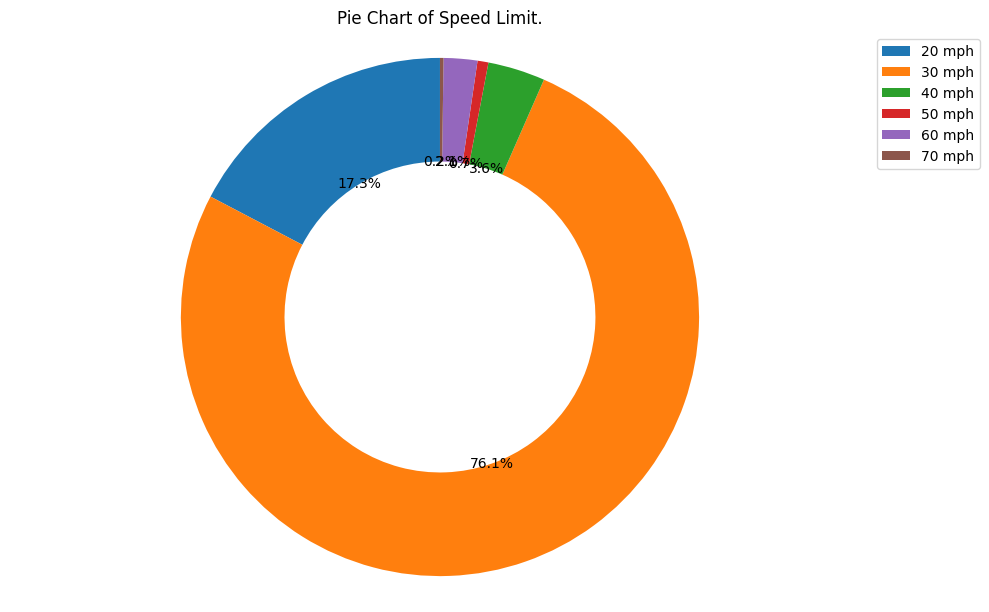

In [228]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df3_cc2["speed_limit"], speed_labels, "Speed Limit", "spd_cond_q3")

Most accidents during the significant period and days occurred within speed limit of 30 mph.

###### Light Conditions

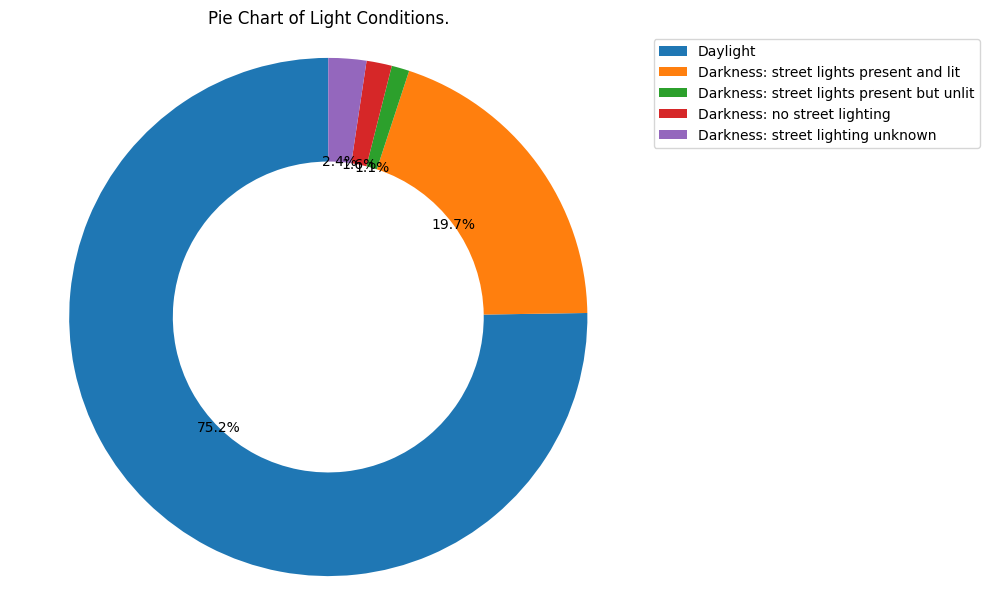

In [229]:
# Plotting pie to chart to retrieve the most significant light conditions under which accident accurred.

cond_plotter(df3_cc2["light_conditions"], light_labels, "Light Conditions", "lit_cond_q3")

Most accidents during the significant period and days occurred during daylight.

###### Weather Conditions

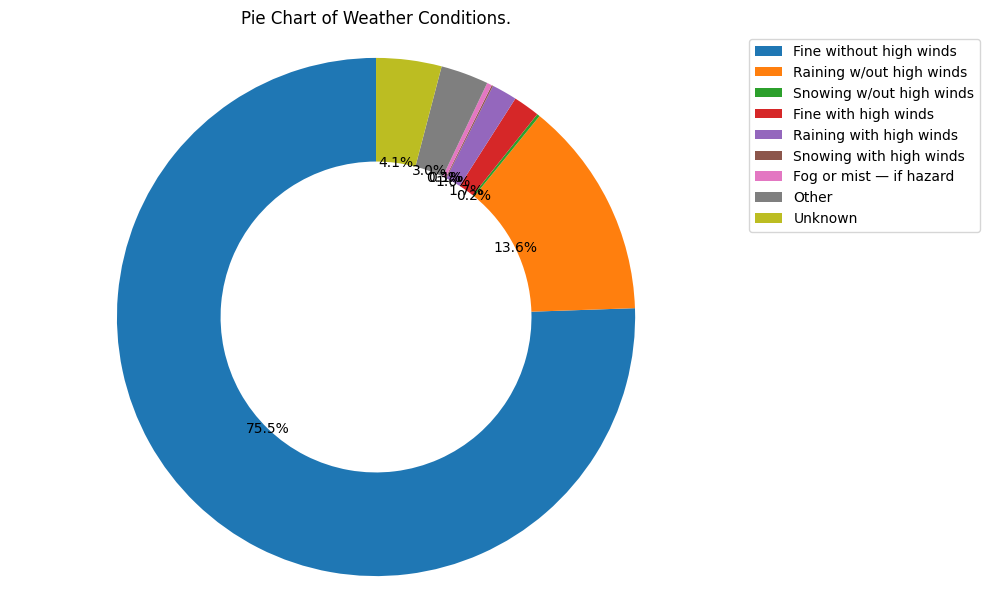

In [230]:
cond_plotter(df3_cc2["weather_conditions"], weather_labels, "Weather Conditions", "wth_cond_q3")

Most accidents during the significant period and days occurred during fine weather without high winds.

##### Road Surface Conditions

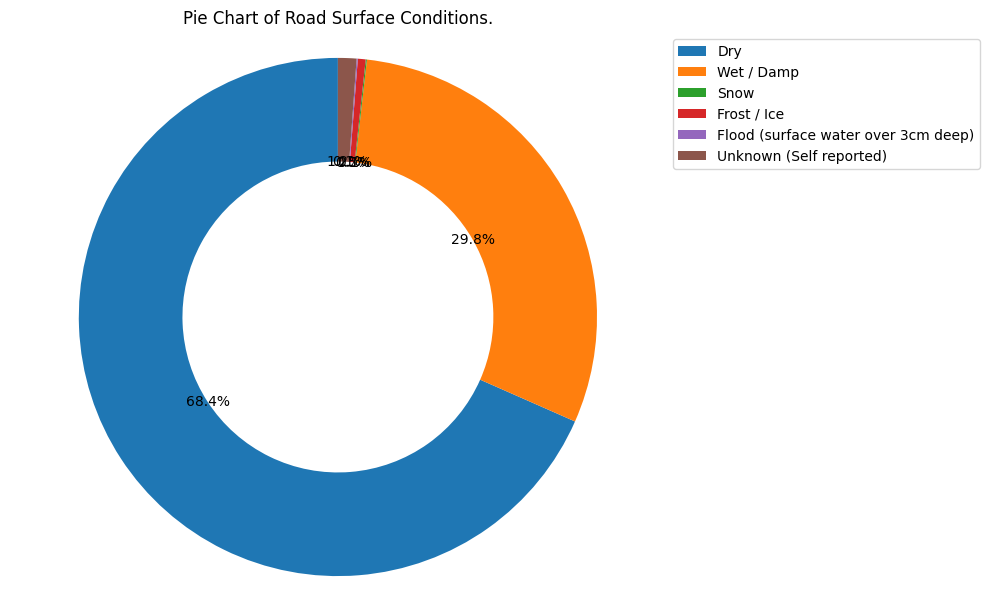

In [231]:
cond_plotter(df3_cc2["road_surface_conditions"], rsc_labels, "Road Surface Conditions", "rsc_cond_q3")

Most accidents during the significant period and days occurred on dry road surface.

##### Special Conditions at Site

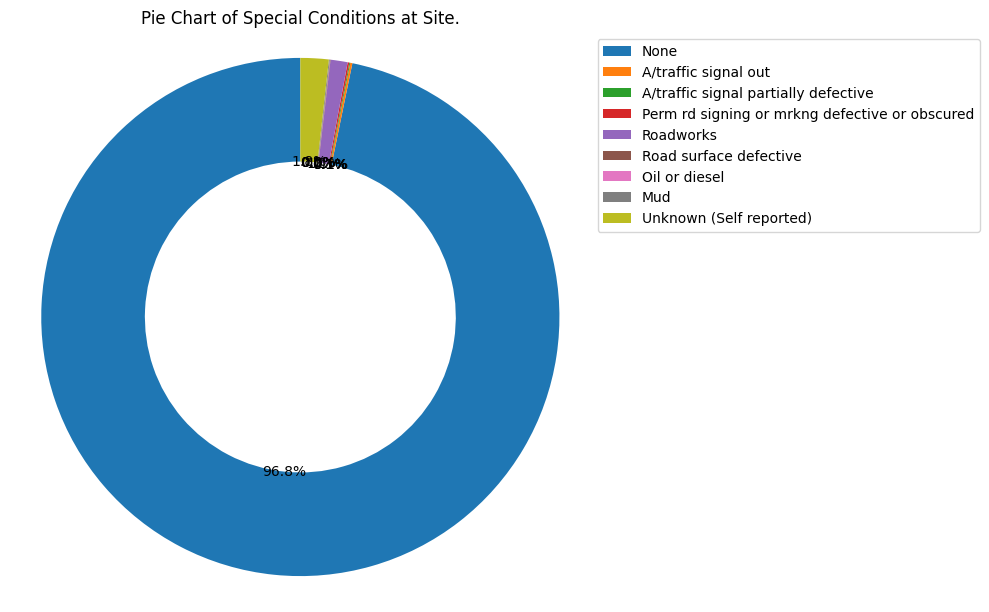

In [232]:
cond_plotter(df3_cc2["special_conditions_at_site"], scs_labels, "Special Conditions at Site", "scs_cond_q3")

Most accidents during the significant period and days occurred within no special conditions at site.

##### Accident Severity

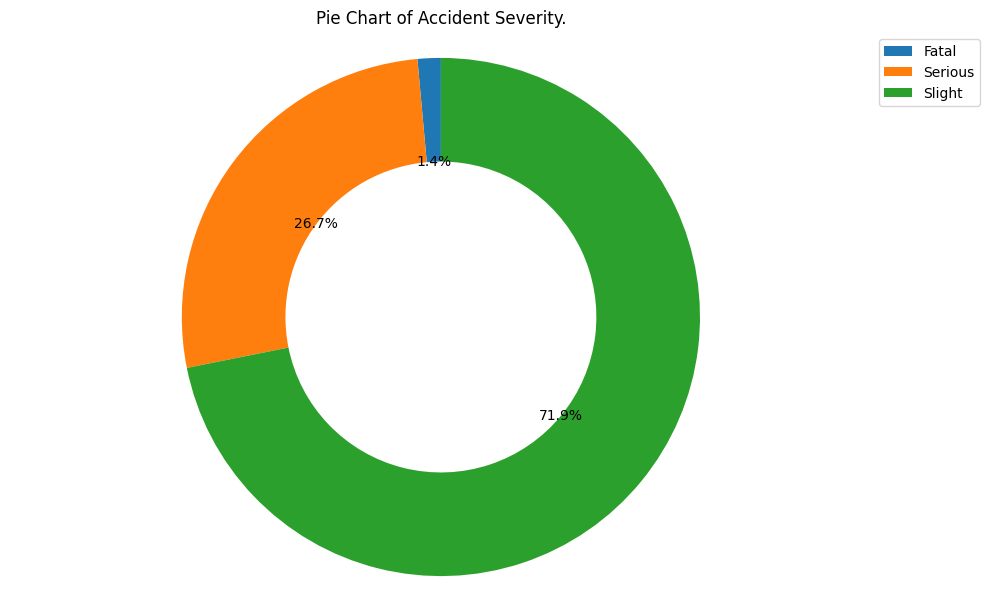

In [233]:
cond_plotter(df3_cc2["accident_severity"], acc_sev_labels, "Accident Severity", "acc_sev_q3")

Most accidents during the significant period and days were slightly severe.

### 4. Using the apriori algorithm, explore the impact of selected variables on accident severity.

The following are the selected variables whose impact on accident severity would be explored:

1) number_of_vehicles
2) Speed limit
3) number_of_casualties
4) Light conditions
5) Weather conditions
6) Road surface conditions
7) Special conditions at site
8) Police force
9) Did a Police Officer attend the scene and obtain the details for this report?
10) Carriageway hazards

In [234]:
query_4 = """
SELECT accident_severity, speed_limit, number_of_vehicles, number_of_casualties, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site, police_force, did_police_officer_attend_scene_of_accident, carriageway_hazards 
FROM accident
WHERE accident_year = 2020
"""

df4 = pd.read_sql(query_4, con)
df4

accident_severity  speed_limit  number_of_vehicles  \
0                      3           20                   1   
1                      3           20                   1   
2                      3           30                   1   
3                      2           30                   1   
4                      3           30                   1   
...                  ...          ...                 ...   
91194                  2           30                   2   
91195                  3           30                   1   
91196                  2           60                   2   
91197                  3           30                   2   
91198                  3           30                   1   

       number_of_casualties  light_conditions  weather_conditions  \
0                         1                 1                   9   
1                         2                 1                   1   
2                         1                 4                   1   
3                         1                 4                   1   
4                         2                 4                   1   
...                     ...               ...                 ...   
91194                     1                 1                   1   
91195                     1                 1                   1   
91196                     1                 1                   1   
91197                     1                 1                   1   
91198                     1                 1                   1   

       road_surface_conditions  special_conditions_at_site  police_force  \
0                            9                           0             1   
1                            1                           0             1   
2                            2                           0             1   
3                            1                           0             1   
4                            1                           0             1   
...                        ...                         ...           ...   
91194                        1                           0            99   
91195                        1                           0            99   
91196                        1                           0            99   
91197                        1                           0            99   
91198                        1                           0            99   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
0                                                3                    0  
1                                                1                    0  
2                                                1                    0  
3                                                1                    0  
4                                                1                    0  
...                                            ...                  ...  
91194                                            1                    0  
91195                                            2                    0  
91196                                            1                    0  
91197                                            2                    0  
91198                                            1                    2  

[91199 rows x 11 columns]

### EDA for The Columns Relevant to Question 4.

In [235]:
# Retrieving information of dataframe df4.

info_chk(df4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   accident_severity                            91199 non-null  int64
 1   speed_limit                                  91199 non-null  int64
 2   number_of_vehicles                           91199 non-null  int64
 3   number_of_casualties                         91199 non-null  int64
 4   light_conditions                             91199 non-null  int64
 5   weather_conditions                           91199 non-null  int64
 6   road_surface_conditions                      91199 non-null  int64
 7   special_conditions_at_site                   91199 non-null  int64
 8   police_force                                 91199 non-null  int64
 9   did_police_officer_attend_scene_of_accident  91199 non-null  int64
 10  carriageway_hazards   

In [236]:
# Retrieving information of dataframe df2.

df_null_chk(df4)

accident_severity                              0
speed_limit                                    0
number_of_vehicles                             0
number_of_casualties                           0
light_conditions                               0
weather_conditions                             0
road_surface_conditions                        0
special_conditions_at_site                     0
police_force                                   0
did_police_officer_attend_scene_of_accident    0
carriageway_hazards                            0
dtype: int64

In [237]:
# Retrieving the describe information of dataframe df4.

df_desc_chk(df4)

accident_severity   speed_limit  number_of_vehicles  \
count       91199.000000  91199.000000        91199.000000   
mean            2.768232     36.270113            1.835272   
std             0.456682     13.896032            0.677272   
min             1.000000     -1.000000            1.000000   
25%             3.000000     30.000000            1.000000   
50%             3.000000     30.000000            2.000000   
75%             3.000000     40.000000            2.000000   
max             3.000000     70.000000           13.000000   

       number_of_casualties  light_conditions  weather_conditions  \
count          91199.000000      91199.000000        91199.000000   
mean               1.267382          2.065308            1.702047   
std                0.681473          1.747690            1.845786   
min                1.000000         -1.000000           -1.000000   
25%                1.000000          1.000000            1.000000   
50%                1.000000          1.000000            1.000000   
75%                1.000000          4.000000            1.000000   
max               41.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  police_force  \
count             91199.000000                91199.000000  91199.000000   
mean                  1.391583                    0.244740     27.488043   
std                   0.925690                    1.318554     24.548964   
min                  -1.000000                   -1.000000      1.000000   
25%                   1.000000                    0.000000      4.000000   
50%                   1.000000                    0.000000     22.000000   
75%                   2.000000                    0.000000     45.000000   
max                   9.000000                    9.000000     99.000000   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
count                                 91199.000000         91199.000000  
mean                                      1.415268             0.180594  
std                                       0.665469             1.149791  
min                                      -1.000000            -1.000000  
25%                                       1.000000             0.000000  
50%                                       1.000000             0.000000  
75%                                       2.000000             0.000000  
max                                       3.000000             9.000000

##### Accident Severity

In [238]:
# Checking if the accident severity column has any blank records or None values.

ds_empty_chk(df4, "accident_severity")

0

In [239]:
# Retrieving the accident severity column unique values.

ds_unique_chk(df2, "accident_severity")

array([3, 2, 1], dtype=int64)

##### Speed Limit

In [240]:
# Checking if the speed limit column has any blank records or None values.

ds_empty_chk(df4, "speed_limit")

0

In [241]:
# Retrieving the speed limit column unique values.

ds_unique_chk(df4, "speed_limit")

array([20, 30, 40, 50, 60, 70, -1], dtype=int64)

In [242]:
# Creating a variable that stores all records where speed limit is -1.

sp_limit_m1_df4 = df4["speed_limit"] == -1

In [243]:
# Replacing speed limit -1 with np.nan.

func_null(df4, sp_limit_m1_df4, "speed_limit")

##### Number of Vehicles

In [244]:
# Checking if the number of vehicles column has any blank records or None values.

ds_empty_chk(df4, "number_of_vehicles")

0

In [245]:
# Retrieving the number of vehicles column unique values.

ds_unique_chk(df4, "number_of_vehicles")

array([ 1,  2,  3,  4,  8,  6,  7,  5,  9, 10, 11, 13, 12], dtype=int64)

##### Number of Casualties

In [246]:
# Checking if the number of casualties column has any blank records or None values.

ds_empty_chk(df4, "number_of_casualties")

0

In [247]:
# Retrieving the number of vehicles column unique values.

ds_unique_chk(df4, "number_of_casualties")

array([ 1,  2,  4,  3,  6,  5,  9, 11,  7,  8, 10, 17, 41, 13, 12, 19],
      dtype=int64)

##### Light Conditions

In [248]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df4, "light_conditions")

0

In [249]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df4, "light_conditions")

array([ 1,  4,  5,  7,  6, -1], dtype=int64)

In [250]:
df4[df4["light_conditions"] == -1]

accident_severity  speed_limit  number_of_vehicles  \
79777                  1         60.0                   1   

       number_of_casualties  light_conditions  weather_conditions  \
79777                     1                -1                  -1   

       road_surface_conditions  special_conditions_at_site  police_force  \
79777                       -1                          -1            52   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
79777                                           -1                   -1

In [251]:
"""
The time of the accident is 01:15 (midnight) which means the light condition would be dark.
The exact location of the accident is on A371 Road located in Axbridge, Somerser this information was confirmed with... 
... Google Maps (Google, 2023).
A371 is a primary road leading to several cities and towns. However, such road are usually unlit as street lights are....
....only available in part of the road where there settlements.
For this reason the possibility of that the light conditions is Darkness: no street lighting (6) is very high.
"""

df4.loc[79777, "light_conditions"] = 6 # Replaced -1 with 6.

##### Special Conditions at Site

In [252]:
# Checking if the light conditions column has any blank records or None values.

ds_empty_chk(df4, "special_conditions_at_site")

0

In [253]:
# Retrieving the unique values of the speed limit column.

ds_unique_chk(df4, "special_conditions_at_site")

array([ 0,  9,  2,  4,  5,  1,  3,  6,  7, -1], dtype=int64)

In [254]:
df4_scas_new = df4["special_conditions_at_site"].map(scas_mapping) # Creating a new dataseries and replacing with the mapped values.
df4_scas_new_count = df4_scas_new.value_counts()

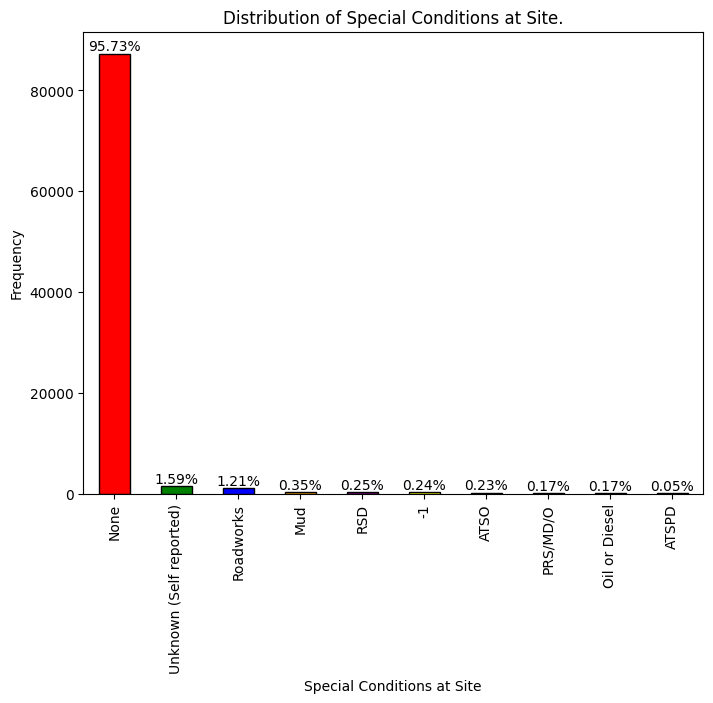

In [255]:
plt.figure(figsize = (8, 6))
df4_scas_new_count.plot(kind = "bar", color = colour_bar_scas, edgecolor="black")
df4_total_data_points = len(df4_scas_new)
plt.xlabel("Special Conditions at Site")
plt.ylabel("Frequency")
plt.title("Distribution of Special Conditions at Site.")
#plt.xticks(range(24))
plt.xticks(rotation=90)
plt.grid(False)

for bar4 in plt.gca().patches:
    percentage = (bar4.get_height() / df4_total_data_points) * 100
    plt.text(bar4.get_x() + bar3.get_width() / 2, bar4.get_height(), f"{percentage:.2f}%", 
             ha="center", va="bottom")
plt.savefig("dist_special_conditions_df4", dpi=300, bbox_inches='tight')
plt.show()

In [256]:
"""
Values for Special Conditions at Site are difficult to infer.
Also from the EDA approximately 96% of these conditions are None (0), which could be that it was difficult to tell the conditions...
... or there are none.
The incorrect values -1 and 9 would be replaced with 0 meaning None.
"""

df4["special_conditions_at_site"].replace([-1], 0, inplace = True) 

##### Weather Conditions

In [257]:
# Checking if the weather conditions column has any blank records or None values.

ds_empty_chk(df4, "weather_conditions")

0

In [258]:
# Retrieving the unique values of the weather conditions column.

ds_unique_chk(df4, "weather_conditions")

array([ 9,  1,  8,  7,  2,  4,  5,  3,  6, -1], dtype=int64)

In [259]:
df4[df4["weather_conditions"] == -1]

accident_severity  speed_limit  number_of_vehicles  \
79777                  1         60.0                   1   

       number_of_casualties  light_conditions  weather_conditions  \
79777                     1                 6                  -1   

       road_surface_conditions  special_conditions_at_site  police_force  \
79777                       -1                           0            52   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
79777                                           -1                   -1

In [260]:
"""
Weather history of the location was retrieved from VisualCrossing (Historical weather data for axbridge | Visual Crossing, n.d.).
From the record at 01:15 midnight the condition was dry with wind speed of 9.6kph, which is considered to be low.
Therefore, the weather condition during the accident is Fine without high winds (1). 
Also, since it has been confirmed from the weather record that it was a rain day the previous day.
A precipitation 0.79mm was recorded during the 19th hour of the previous day indicating rainfall just few hours to the incident.
This would certainly me the road surface was still wet/damp as at the time of accident.

"""

df4.loc[79777, "weather_conditions"] = 1
df4.loc[79777,"road_surface_conditions"] = 2

##### Road Surface Conditions

In [261]:
# Checking if the day_of_week data series from df4 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df4, "road_surface_conditions")

0

In [262]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df4, "road_surface_conditions")

array([ 9,  1,  2,  5,  4,  3, -1], dtype=int64)

In [263]:
# Changed road surface conditions in dataframe df4 with values -1 for all accidents that occurred while raining was changed to wet/damp (2).

scas_filter1(df4)

In [264]:
# Changed road surface conditions in dataframe df4 with values -1 for all accidents that occurred while snowing without high winds was changed to snow (3).


scas_filter2(df4, 3, 3)

In [265]:
# Changed road surface conditions in dataframe df4 with values -1 for all accidents that occurred while it was foggy or misty was changed to wet/damp (2)..


scas_filter2(df4, 7, 2)

In [266]:
"""
There are no records where the weather condition was snowing with high winds and...
... road surface conditions was -1.
"""

df4[(df4["weather_conditions"] == 6) & ((df4["road_surface_conditions"] == -1))]

Empty DataFrame
Columns: [accident_severity, speed_limit, number_of_vehicles, number_of_casualties, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site, police_force, did_police_officer_attend_scene_of_accident, carriageway_hazards]
Index: []

In [267]:
"""
Changing road surface conditions in dataframe df3 with values -1 for all accidents that occurred while the ..
.... weather conditons are 1, 4, 8 and 9 to np.nan in order to implement MICE.

"""

scas_filter3(df4)

##### Police Force

In [268]:
# Checking if the day_of_week data series from df4 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df4, "police_force")

0

In [269]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df4, "police_force")

array([ 1,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23,
       30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       50, 52, 53, 54, 55, 60, 61, 62, 63, 99], dtype=int64)

##### Did Police Officer Attend Scene of Accident

In [270]:
# Checking if the day_of_week data series from df4 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df4, "did_police_officer_attend_scene_of_accident")

0

In [271]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df4, "did_police_officer_attend_scene_of_accident")

array([ 3,  1,  2, -1], dtype=int64)

In [272]:
# Creating a variable that stores all records with value -1.

attend_df4 = df4["did_police_officer_attend_scene_of_accident"] == -1

In [273]:
# Replacing speed limit -1 with np.nan.

func_null(df4, attend_df4, "did_police_officer_attend_scene_of_accident")

##### Carriageway Hazards

In [274]:
# Checking if the day_of_week data series from df4 DataFrame contains any NaN or None or blank values.

ds_empty_chk(df4, "carriageway_hazards")

0

In [275]:
# Retrieving the unique values of the road surface conditions column.

ds_unique_chk(df4, "carriageway_hazards")

array([ 0,  2,  9,  6,  3,  1,  7, -1], dtype=int64)

According to the stat20 and the Road Safety Open Dataset Data Guide documents -1 is missing data or out of range. Hence all records with carriageway hazards with value of -1 will be changed to null.

In [276]:
# Creating a variable that stores all carriageway hazards records with values -1.

carriage_df4 = df4["carriageway_hazards"] == -1

In [277]:
# Replacing carriage hazards values -1 with np.nan.

func_null(df4, carriage_df4, "carriageway_hazards")

#### Multiple Imputation Using Chain Equations (MICE)

MICE would generate and impute estimated values for all missing records (NaN) in the dataframe.

In [278]:
# Creating a copy of dataframe df4.
df4_cc = df4.copy()

In [279]:
# Executing MICE.

df4_cc = mice_exec(df4_cc, 3)

In [280]:
"""Retrieving the dataframe df4_cc describe information in order to compare data distribution values with....
... uncleaned dataframe df4. 
"""

df_desc_chk(df4_cc)

accident_severity   speed_limit  number_of_vehicles  \
count       91199.000000  91199.000000        91199.000000   
mean            2.768232     36.274301            1.835272   
std             0.456682     13.890103            0.677272   
min             1.000000     20.000000            1.000000   
25%             3.000000     30.000000            1.000000   
50%             3.000000     30.000000            2.000000   
75%             3.000000     40.000000            2.000000   
max             3.000000     70.000000           13.000000   

       number_of_casualties  light_conditions  weather_conditions  \
count          91199.000000      91199.000000        91199.000000   
mean               1.267382          2.065384            1.702069   
std                0.681473          1.747709            1.845765   
min                1.000000          1.000000            1.000000   
25%                1.000000          1.000000            1.000000   
50%                1.000000          1.000000            1.000000   
75%                1.000000          4.000000            1.000000   
max               41.000000          7.000000            9.000000   

       road_surface_conditions  special_conditions_at_site  police_force  \
count             91199.000000                91199.000000  91199.000000   
mean                  1.399555                    0.247130     27.488043   
std                   0.915637                    1.317201     24.548964   
min                   1.000000                    0.000000      1.000000   
25%                   1.000000                    0.000000      4.000000   
50%                   1.000000                    0.000000     22.000000   
75%                   2.000000                    0.000000     45.000000   
max                   9.000000                    9.000000     99.000000   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
count                                 91199.000000         91199.000000  
mean                                      1.415290             0.183094  
std                                       0.665423             1.148890  
min                                       1.000000             0.000000  
25%                                       1.000000             0.000000  
50%                                       1.000000             0.000000  
75%                                       2.000000             0.000000  
max                                       3.000000             9.000000

In [281]:
# Converting the road surface condition column back to int64.

ds_type_conv(df4_cc, "road_surface_conditions")

In [282]:
# Converting the speed limit column back to int64.

ds_type_conv(df4_cc, "speed_limit")

In [283]:
# Converting the speed limit column back to int64.

ds_type_conv(df4_cc, "did_police_officer_attend_scene_of_accident")

In [284]:
# Converting the speed limit column back to int64.

ds_type_conv(df4_cc, "carriageway_hazards")

In [285]:
df4_cc

accident_severity  speed_limit  number_of_vehicles  \
0                      3           20                   1   
1                      3           20                   1   
2                      3           30                   1   
3                      2           30                   1   
4                      3           30                   1   
...                  ...          ...                 ...   
91194                  2           30                   2   
91195                  3           30                   1   
91196                  2           60                   2   
91197                  3           30                   2   
91198                  3           30                   1   

       number_of_casualties  light_conditions  weather_conditions  \
0                         1                 1                   9   
1                         2                 1                   1   
2                         1                 4                   1   
3                         1                 4                   1   
4                         2                 4                   1   
...                     ...               ...                 ...   
91194                     1                 1                   1   
91195                     1                 1                   1   
91196                     1                 1                   1   
91197                     1                 1                   1   
91198                     1                 1                   1   

       road_surface_conditions  special_conditions_at_site  police_force  \
0                            9                           0             1   
1                            1                           0             1   
2                            2                           0             1   
3                            1                           0             1   
4                            1                           0             1   
...                        ...                         ...           ...   
91194                        1                           0            99   
91195                        1                           0            99   
91196                        1                           0            99   
91197                        1                           0            99   
91198                        1                           0            99   

       did_police_officer_attend_scene_of_accident  carriageway_hazards  
0                                                3                    0  
1                                                1                    0  
2                                                1                    0  
3                                                1                    0  
4                                                1                    0  
...                                            ...                  ...  
91194                                            1                    0  
91195                                            2                    0  
91196                                            1                    0  
91197                                            2                    0  
91198                                            1                    2  

[91199 rows x 11 columns]

##### Implementing Apriori.

In [286]:
# One-hot encoding accident severity.

encoded_acc_severity = pd.get_dummies(df4_cc.accident_severity, prefix = "severity")

In [287]:
# One-hot encoding speed limit.

encoded_sp_limit = pd.get_dummies(df4_cc.speed_limit, prefix = "sp_limit")

In [288]:
# One-hot encoding number of vehicles.

encoded_no_veh = pd.get_dummies(df4_cc.number_of_vehicles, prefix = "no_vehicles")

In [289]:
# One-hot encoding number of casualities.

encoded_no_cas = pd.get_dummies(df4_cc.number_of_casualties, prefix = "no_casualties")

In [290]:
# One-hot encoding light conditions.

encoded_light_cond = pd.get_dummies(df4_cc.light_conditions, prefix = "light_cond")

In [291]:
# One-hot encoding weather conditions.

encoded_weather_cond = pd.get_dummies(df4_cc.weather_conditions, prefix = "w_cond")

In [292]:
# One-hot encoding road surface conditions.

encoded_rd_cond = pd.get_dummies(df4_cc.road_surface_conditions, prefix = "rd_cond")

In [293]:
# One-hot encoding special_conditions_at_site.

encoded_sp_cond = pd.get_dummies(df4_cc.special_conditions_at_site, prefix = "sp_cond")

In [294]:
# One-hot encoding police force.

encoded_police_force = pd.get_dummies(df4_cc.police_force, prefix = "police_force")

In [295]:
# One-hot encoding did police officer attend scene of accident.

encoded_police_attendance = pd.get_dummies(df4_cc.did_police_officer_attend_scene_of_accident, prefix = "police_attendance")

In [296]:
# One-hot encoding carriageway hazards.

encoded_carriageway = pd.get_dummies(df4_cc.carriageway_hazards, prefix = "carriage_hazards")

In [297]:
# Combining all one-hot encoded columns into a dataframe.

encoded_df4 = pd.concat([encoded_acc_severity, 
                         encoded_sp_limit, 
                         encoded_no_veh, 
                         encoded_no_cas, 
                         encoded_light_cond, 
                         encoded_weather_cond,
                         encoded_rd_cond,
                         encoded_sp_cond, 
                         encoded_police_force, 
                         encoded_police_attendance, 
                         encoded_carriageway], axis = 1)

In [298]:
# Converting non-boolean values to boolean
encoded_df4 = encoded_df4.astype(bool)

# Running Apriori
encoded_freq = apriori(encoded_df4, min_support = 0.7, use_colnames = True)
encoded_freq["length"] = encoded_freq["itemsets"].apply(lambda x: len(x))

In [299]:
# Displaying apriori results.
encoded_freq

support                                          itemsets  length
0   0.783484                                      (severity_3)       1
1   0.813178                                 (no_casualties_1)       1
2   0.706784                                    (light_cond_1)       1
3   0.775557                                        (w_cond_1)       1
4   0.959736                                       (sp_cond_0)       1
5   0.965844                              (carriage_hazards_0)       1
6   0.750162                           (sp_cond_0, severity_3)       2
7   0.755655                  (severity_3, carriage_hazards_0)       2
8   0.778989                      (sp_cond_0, no_casualties_1)       2
9   0.784077             (no_casualties_1, carriage_hazards_0)       2
10  0.750458                             (w_cond_1, sp_cond_0)       2
11  0.754690                    (w_cond_1, carriage_hazards_0)       2
12  0.937828                   (sp_cond_0, carriage_hazards_0)       2
13  0.733122       (sp_cond_0, severity_3, carriage_hazards_0)       3
14  0.761138  (sp_cond_0, carriage_hazards_0, no_casualties_1)       3
15  0.734866         (w_cond_1, sp_cond_0, carriage_hazards_0)       3

In [300]:
# Generating the rules.

rules = association_rules(encoded_freq, metric = "confidence", min_threshold = 0.75)
rules

antecedents  \
0                             (sp_cond_0)   
1                            (severity_3)   
2                            (severity_3)   
3                    (carriage_hazards_0)   
4                             (sp_cond_0)   
5                       (no_casualties_1)   
6                       (no_casualties_1)   
7                    (carriage_hazards_0)   
8                              (w_cond_1)   
9                             (sp_cond_0)   
10                             (w_cond_1)   
11                   (carriage_hazards_0)   
12                            (sp_cond_0)   
13                   (carriage_hazards_0)   
14                (severity_3, sp_cond_0)   
15        (sp_cond_0, carriage_hazards_0)   
16       (severity_3, carriage_hazards_0)   
17                            (sp_cond_0)   
18                           (severity_3)   
19                   (carriage_hazards_0)   
20        (sp_cond_0, carriage_hazards_0)   
21           (sp_cond_0, no_casualties_1)   
22  (no_casualties_1, carriage_hazards_0)   
23                            (sp_cond_0)   
24                   (carriage_hazards_0)   
25                      (no_casualties_1)   
26                  (w_cond_1, sp_cond_0)   
27         (w_cond_1, carriage_hazards_0)   
28        (sp_cond_0, carriage_hazards_0)   
29                             (w_cond_1)   
30                            (sp_cond_0)   
31                   (carriage_hazards_0)   

                              consequents  antecedent support  \
0                            (severity_3)            0.959736   
1                             (sp_cond_0)            0.783484   
2                    (carriage_hazards_0)            0.783484   
3                            (severity_3)            0.965844   
4                       (no_casualties_1)            0.959736   
5                             (sp_cond_0)            0.813178   
6                    (carriage_hazards_0)            0.813178   
7                       (no_casualties_1)            0.965844   
8                             (sp_cond_0)            0.775557   
9                              (w_cond_1)            0.959736   
10                   (carriage_hazards_0)            0.775557   
11                             (w_cond_1)            0.965844   
12                   (carriage_hazards_0)            0.959736   
13                            (sp_cond_0)            0.965844   
14                   (carriage_hazards_0)            0.750162   
15                           (severity_3)            0.937828   
16                            (sp_cond_0)            0.755655   
17       (severity_3, carriage_hazards_0)            0.959736   
18        (sp_cond_0, carriage_hazards_0)            0.783484   
19                (severity_3, sp_cond_0)            0.965844   
20                      (no_casualties_1)            0.937828   
21                   (carriage_hazards_0)            0.778989   
22                            (sp_cond_0)            0.784077   
23  (no_casualties_1, carriage_hazards_0)            0.959736   
24           (sp_cond_0, no_casualties_1)            0.965844   
25        (sp_cond_0, carriage_hazards_0)            0.813178   
26                   (carriage_hazards_0)            0.750458   
27                            (sp_cond_0)            0.754690   
28                             (w_cond_1)            0.937828   
29        (sp_cond_0, carriage_hazards_0)            0.775557   
30         (w_cond_1, carriage_hazards_0)            0.959736   
31                  (w_cond_1, sp_cond_0)            0.965844   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.783484  0.750162    0.781633  0.997637 -0.001777    0.991522   
1             0.959736  0.750162    0.957469  0.997637 -0.001777    0.946678   
2             0.965844  0.755655    0.964480  0.998588 -0.001068    0.961605   
3             0.783484  0.755655    0.782378  0.998588 -0.001068    0.994916  

There is approximately 78% likelihood that when no sp_cond_0 or carriage_hazards_0 or their combination is recorded then slight accident severity would be recorded in the same transaction (confidence). 
There are approximately 75% for sp_cond_0, 76% for carriage_hazards_0 and 73% for their combination that would lead to severity_3.
Each variable or the combination has a lift of approximately 1 indicating that the occurrence of the antecedent and consequent (severity_3) are independent of each other. In other words, the presence of the antecedent doesn't influence or change the likelihood of the consequent.

### 5) Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

According to the stat20 document the following regions are situated under Humberside:

1) Kingston upon Hull, City of
2) East Riding of Yorkshire
3) North Lincolnshire
4) North East Lincolnshire

In [301]:
query_5 = """
SELECT a.longitude, a.latitude
FROM accident as a
INNER JOIN lsoa as l ON a.lsoa_of_accident_location = l.lsoa01cd
WHERE a.accident_year = 2020 AND (l.lsoa01nm LIKE "%Kingston upon Hull%" 
                                OR l.lsoa01nm LIKE "%East Riding of Yorkshire%" 
                                OR l.lsoa01nm LIKE "%North Lincolnshire%" 
                                OR l.lsoa01nm LIKE "%North East Lincolnshire%")
"""

df5 = pd.read_sql(query_5, con)
df5

longitude   latitude
0     -0.393424  53.744936
1     -0.528743  53.512895
2     -0.324858  53.791630
3     -0.095008  53.574501
4     -0.327733  53.767805
...         ...        ...
1658  -0.651104  53.566753
1659  -0.424674  53.839482
1660  -0.308880  53.782750
1661  -0.703181  53.569801
1662  -0.342063  53.742609

[1663 rows x 2 columns]

### EDA for The Columns Relevant to Question 5.

In [302]:
# Retrieving information of dataframe df4.

info_chk(df5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  1663 non-null   float64
 1   latitude   1663 non-null   float64
dtypes: float64(2)
memory usage: 26.1 KB


In [303]:
# Retrieving information of dataframe df2.

df_null_chk(df5)

longitude    0
latitude     0
dtype: int64

In [304]:
# Retrieving the describe information of dataframe df4.

df_desc_chk(df5)

longitude     latitude
count  1663.000000  1663.000000
mean     -0.382412    53.718748
std       0.222034     0.137312
min      -1.055770    53.456614
25%      -0.479544    53.581496
50%      -0.359015    53.743308
75%      -0.246884    53.774485
max       0.123813    54.143923

##### Longitude

In [305]:
# Checking if the longitude column has any blank records or None values.

ds_empty_chk(df5, "longitude")

0

##### Latitude

In [306]:
# Checking if the latitude column has any blank records or None values.

ds_empty_chk(df5, "latitude")

0

##### Scatter Plot

In [307]:
df5_scaler = StandardScaler() #Initiating StandardScaler class.

In [308]:
df5_scaler_ds = df5_scaler.fit_transform(df5)
df5_scaler_ds

array([[-0.04961134,  0.19077661],
       [-0.65924685, -1.49961163],
       [ 0.25929036,  0.53093627],
       ...,
       [ 0.33127401,  0.46624664],
       [-1.44512022, -1.08505889],
       [ 0.18177886,  0.17382472]])

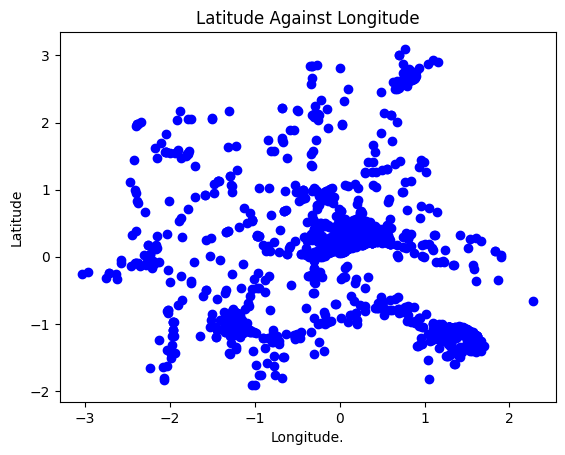

In [309]:
plt.scatter(df5_scaler_ds[:, 0], df5_scaler_ds[:, 1], c= "blue")
plt.xlabel("Longitude.")
plt.ylabel("Latitude")
plt.title("Latitude Against Longitude")
plt.savefig("scatter_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

##### KMeans Clustering

##### Elbow Method

In [310]:
inertia = []
K = range(5, 61, 5)
for elb in K:
    kmeans = KMeans(n_clusters = elb)
    kmeans.fit(df5_scaler_ds)
    inertia.append(kmeans.inertia_)

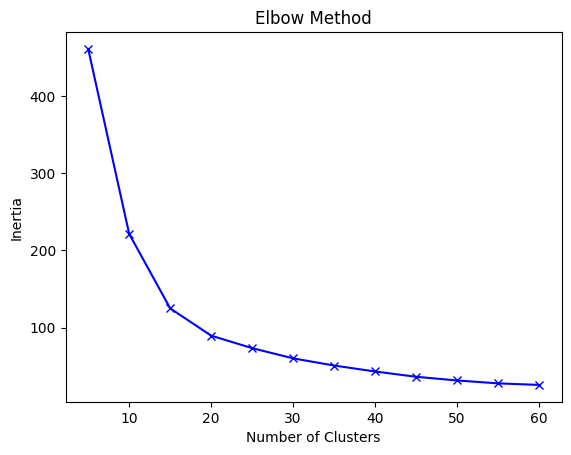

In [311]:
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.savefig("elbow_df5", dpi=300, bbox_inches='tight')
plt.show()

##### KMeans

In [312]:
kmeans = KMeans(n_clusters = 15)
kmeans.fit(df5_scaler_ds)

KMeans(n_clusters=15)

In [313]:
k_labels = kmeans.fit_predict(df5_scaler_ds)
centroids = kmeans.cluster_centers_

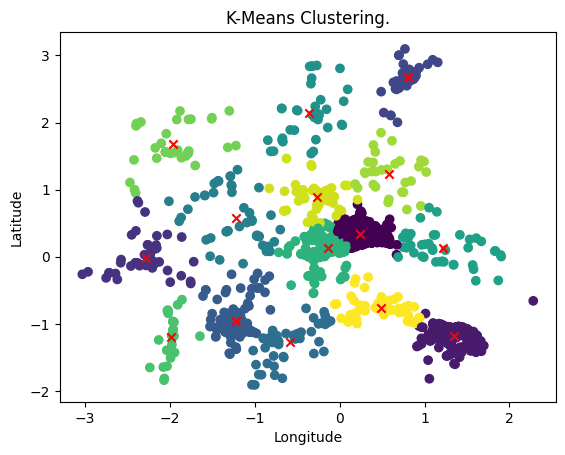

In [314]:
plt.scatter(df5_scaler_ds[:, 0], df5_scaler_ds[:, 1], c = k_labels, cmap = "viridis")
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = "red")
plt.title("K-Means Clustering.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("kmeans_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

##### Agglomerative Hierarchical Clustering

In [315]:
agg_cluster = AgglomerativeClustering(n_clusters = 10, affinity = "euclidean", linkage = "ward")
agg_cluster.fit_predict(df5_scaler_ds)

array([1, 4, 1, ..., 1, 4, 1], dtype=int64)

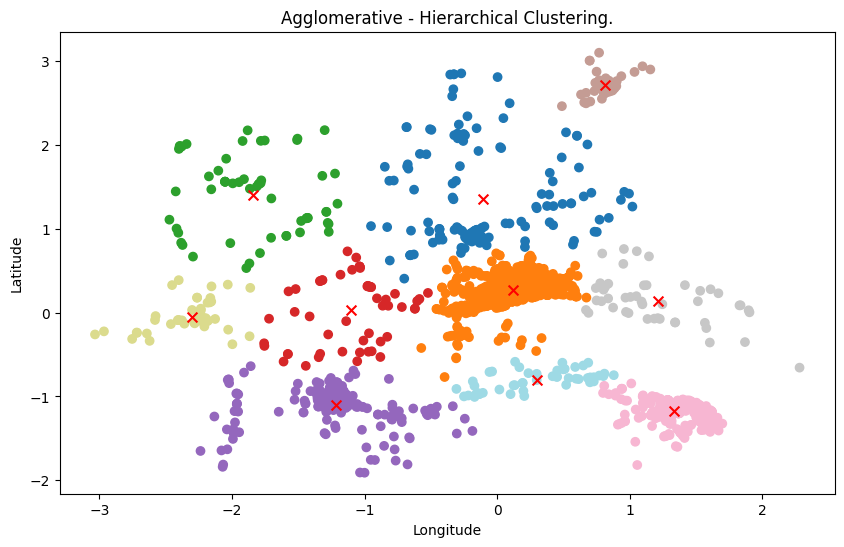

In [316]:
unique_labels = np.unique(agg_cluster.labels_)
centroids = []
for label in unique_labels:
    label_points = df5_scaler_ds[agg_cluster.labels_ == label]
    centroid = np.mean(label_points, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)


agg_cmap = plt.colormaps['tab20'](np.linspace(0, 1, 10))

fig = plt.figure(figsize = (10, 6))

l = agg_cluster.labels_

agg_colors = agg_cmap[agg_cluster.labels_]

plt.scatter(df5_scaler_ds[:, 0], df5_scaler_ds[:, 1], c = agg_colors)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=50, label='Cluster Centroids')

plt.title("Agglomerative - Hierarchical Clustering.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("agglomerative_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

##### Gaussian Mixture Model

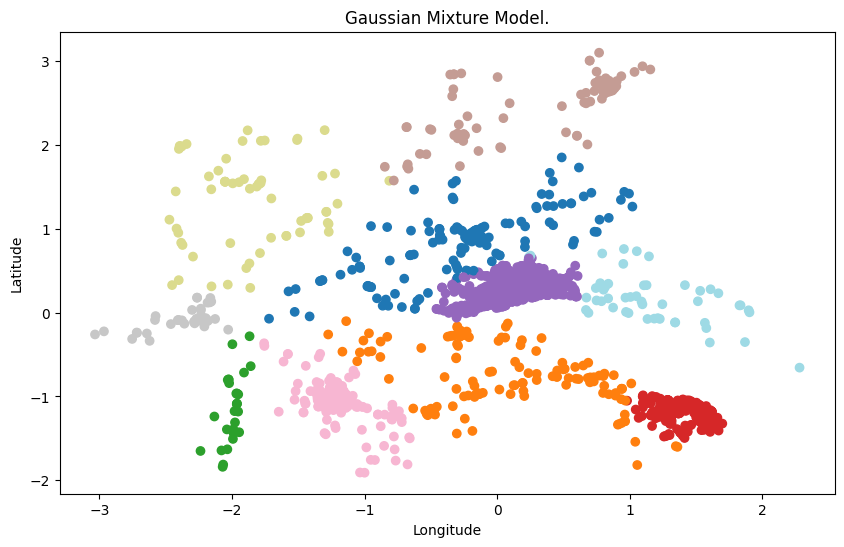

In [317]:
gmm_cmap = plt.colormaps['tab20'](np.linspace(0, 1, 10))
gmm = GaussianMixture(n_components = 10).fit(df5_scaler_ds)
gmm_labels = gmm.predict(df5_scaler_ds)

gmm_colors = gmm_cmap[gmm_labels]

fig = plt.figure(figsize = (10, 6))
plt.scatter(df5_scaler_ds[:, 0], df5_scaler_ds[:, 1], c = gmm_colors)
plt.title("Gaussian Mixture Model.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("gmm_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

##### DBSCAN

In [318]:
df5_dbscan_opt = DBSCAN(eps = 0.1, min_samples = 2)
df5_dbscan_opt.fit(df5_scaler_ds)
dbscan_labels = df5_dbscan_opt.labels_
dbscan_labels

array([0, 1, 0, ..., 0, 6, 0], dtype=int64)

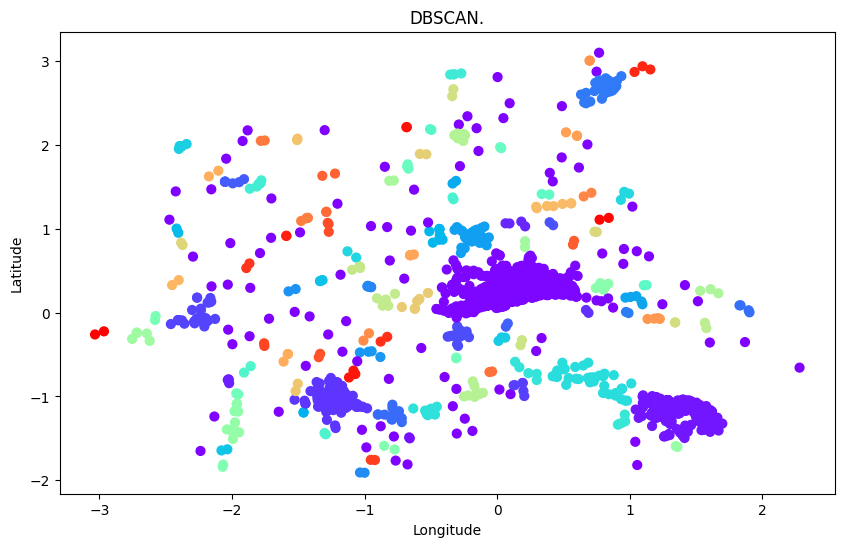

In [319]:
plt.figure(figsize = (10, 6))
plt.scatter(df5_scaler_ds[:, 0], df5_scaler_ds[:, 1], c = dbscan_labels, s = 40, cmap = "rainbow")
plt.title("DBSCAN.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("dbscan_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

##### Silhouette Coefficient Validation

In [320]:
cluster_list = []
sil_score_list = []

# A function that return the silhouette score of a clustering technique.
def sil_score(sil_label, cluster_name):
    sil_score_res = silhouette_score(df5_scaler_ds, sil_label, metric = "euclidean")
    cluster_list.append(cluster_name)
    sil_score_list.append(sil_score_res)
    print(f"The silhouette_score of the {cluster_name} is {sil_score_res}.")

In [321]:
# Calculating silhouette score for K-Means clustering.

sil_score(k_labels, "K-Means clustering")

The silhouette_score of the K-Means clustering is 0.5189438930550141.


In [322]:
# Calculating silhouette score for agglomerative-hierarchical clustering.

sil_score(l, "Agglomerative clustering")

The silhouette_score of the Agglomerative clustering is 0.5740979343477666.


In [323]:
# Calculating silhouette score for Gaussian Mixture Model.

sil_score(gmm_labels, "Gaussian Mixture Models")

The silhouette_score of the Gaussian Mixture Models is 0.5355451368225582.


In [324]:
# Calculating silhouette score for DBSCAN.

sil_score(dbscan_labels, "dbscan_labels")

The silhouette_score of the dbscan_labels is 0.2713224647623154.


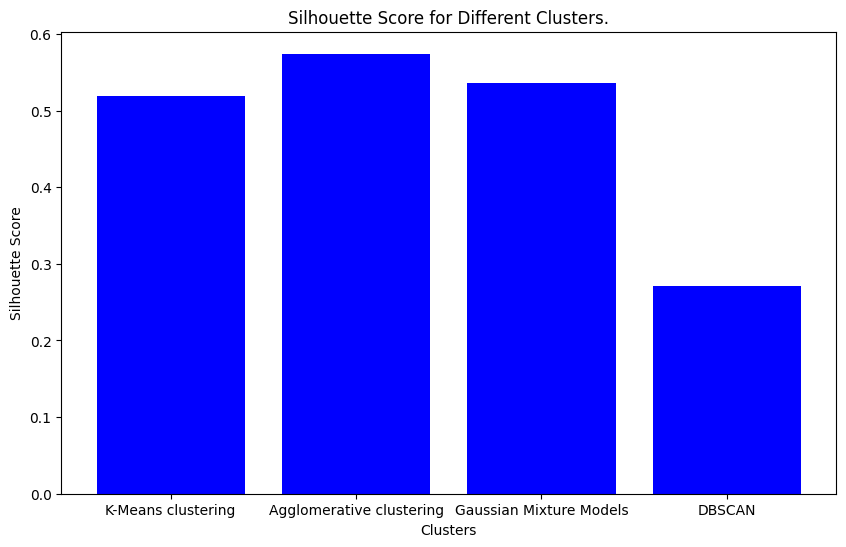

In [325]:
cluster_list[3] = "DBSCAN" # Modifying the name of the fourth element of the list.

# Creating a bar plot for silhouette scores.
plt.figure(figsize=(10, 6))
plt.bar(cluster_list, sil_score_list, color = "blue")
plt.xlabel("Clusters")
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score for Different Clusters.")
plt.savefig("silhouette_plot_df5", dpi=300, bbox_inches='tight')
plt.show()

Agglomerative clustering with 10 clusters was considered the best due to its coherent cluster formation, distances within individual neighborhoods, and favorable silhouette score.
Agglomerative clustering reveals that accidents in the Humberside region exhibit a scattered distribution with fewer dense clusters.

### 6) Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data?

Using the Local Outlier Factor (LOF) method to detect global outliers in the dataset from question 5.

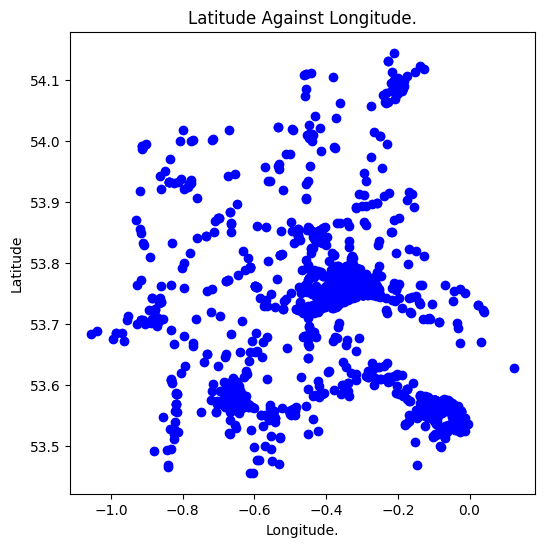

In [326]:
# Plotting Longitude against Latitude.
plt.figure(figsize=(6,6))
plt.scatter(df5["longitude"], df5["latitude"], c= "blue")
plt.xlabel("Longitude.")
plt.ylabel("Latitude")
plt.title("Latitude Against Longitude.")
plt.savefig("scatter_plot_df6", dpi=300, bbox_inches='tight')
plt.show()

In [327]:
model = LocalOutlierFactor(n_neighbors = 5, contamination = .05)
y_pred = model.fit_predict(df5)
LOF_Scores = model.negative_outlier_factor_
LOF_pred = pd.Series(y_pred).replace([-1,1],[1,0])
LOF_anomalies = df5[LOF_pred == 1]

In [328]:
LOF_anomalies

longitude   latitude
12    -0.233784  53.722959
13    -0.400675  53.761627
30    -0.364669  53.700887
31    -0.367902  53.695609
37    -0.832815  53.690712
...         ...        ...
1526  -0.872670  53.695948
1557  -0.219574  54.081251
1572  -0.619945  53.618058
1582  -0.335721  53.835548
1605  -0.394913  53.744857

[84 rows x 2 columns]

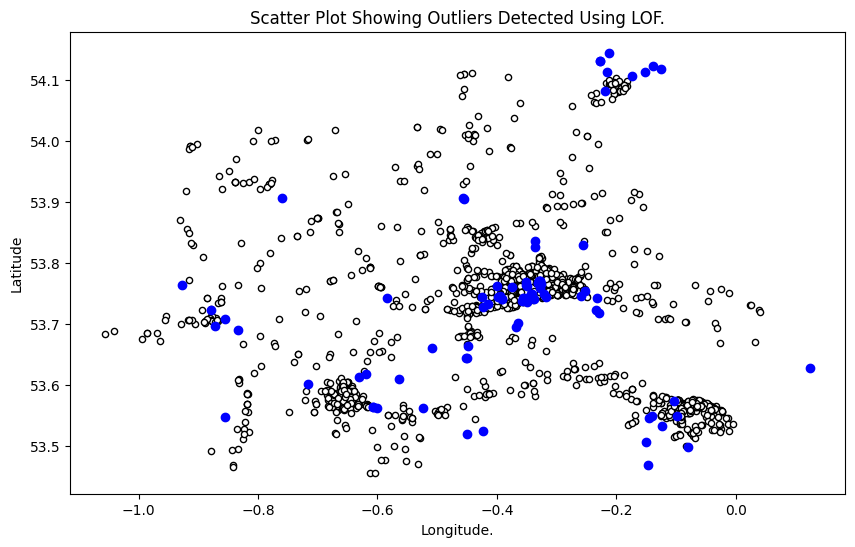

In [329]:
# Plotting Longitude against Latitude to outliers using LOF.

plt.figure(figsize=(10,6))
plt.scatter(df5["longitude"], df5["latitude"],c = "white", s = 20, edgecolor = "k")
plt.scatter(LOF_anomalies["longitude"],LOF_anomalies["latitude"], c = "blue")
plt.xlabel("Longitude.")
plt.ylabel("Latitude")
plt.title("Scatter Plot Showing Outliers Detected Using LOF.")
plt.savefig("outlier_plot_df6", dpi = 300, bbox_inches = "tight")
plt.show()

In [330]:
# Combining longitude and latitude columns to create a Point geometry column.
geo_LOF_anomalies = [Point(lon, lat) for lon, lat in zip(LOF_anomalies["longitude"], LOF_anomalies["latitude"])]

# Creating a GeoDataFrame with the original DataFrame and the Point geometries.
gdf_LOF_anomalies = gpd.GeoDataFrame(LOF_anomalies, geometry = geo_LOF_anomalies, crs = "EPSG:4326")


In [331]:
# Loading the UK map shapefile (you can download shapefiles from various sources).
uk_map = gpd.read_file("./UK_DISTRICTS_COUNTIES_CENSUS2011.shp")

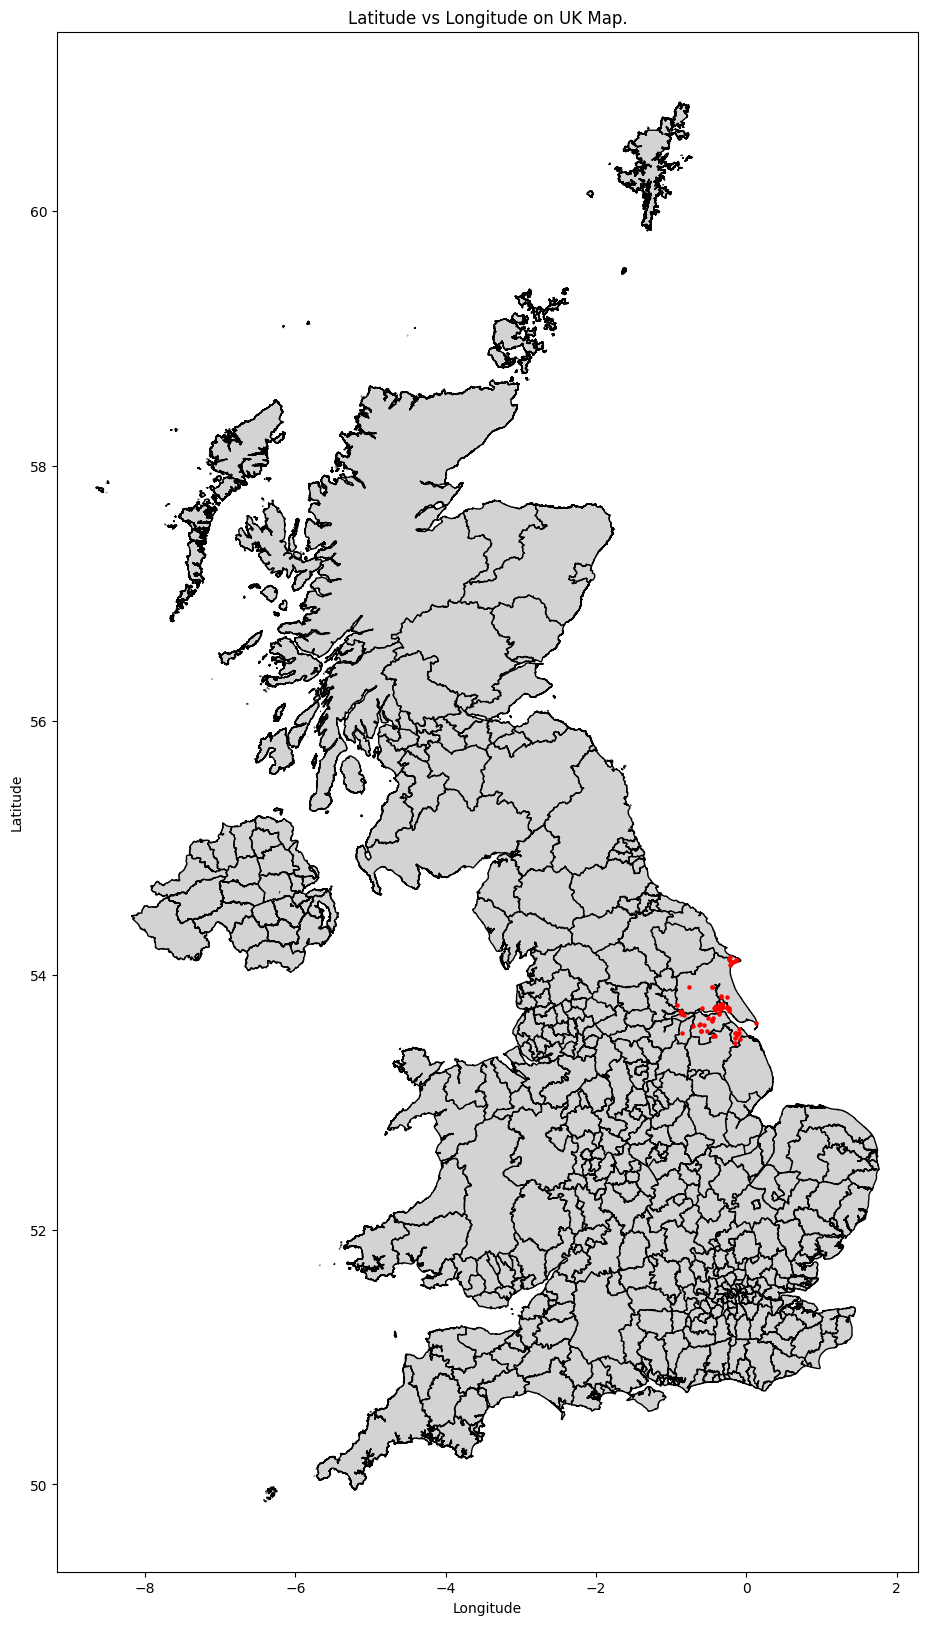

In [332]:
# Creating the plot.
fig, ax = plt.subplots(figsize = (20, 20))

# Plotting the world map.
uk_map.plot(ax = ax, color= "lightgray", edgecolor= "black")

# Plotting the GeoDataFrame with latitude and longitude data on the world map.
gdf_LOF_anomalies.plot(ax = ax, color = "red", markersize = 5)

# Adding title and labels.
plt.title("Latitude vs Longitude on UK Map.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("outlier_loc_q6", dpi=300, bbox_inches='tight')

# Showing the plot.
plt.show()

Majority of accident within the significant periods occurred in the London Metropolitan region.

In [333]:
"""
Creating a folium map (Reinking, 2023).
Source: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium
"""

folium_map_LOF_outliers = folium.Map(prefer_canvas=True)

def folium_plotter_LOF_outlier(plot):
    folium.CircleMarker(location=[plot.latitude, plot.longitude],
                        radius=2,
                        weight=5).add_to(folium_map_LOF_outliers)

# Tterating through every row in the dataframe.
LOF_anomalies.apply(folium_plotter_LOF_outlier, axis = 1)


#Setting the zoom to the maximum possible
folium_map_LOF_outliers.fit_bounds(folium_map_LOF_outliers.get_bounds())

#Saving the map to an HTML file
folium_map_LOF_outliers.save("./outliers_loc_folium_q6.html")

##### Implementing Isolation Forest outlier detection method to validate that the detected are global outliers.

In [334]:
ranst=np.random.RandomState(0)

if_model = IsolationForest(max_samples = 50, random_state = ranst, contamination = .05) 
if_model.fit(df5.values) # Converting DataFrame to a NumPy array.
if_scores = if_model.decision_function(df5.values)
if_anomalies = if_model.predict(df5.values)
if_anomalies = pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies = df5[if_anomalies == 1];

In [335]:
if_anomalies

longitude   latitude
45    -0.194271  54.091148
72    -0.211803  54.143923
77    -0.182158  54.097510
85    -0.196679  54.090978
103   -0.210107  54.095196
...         ...        ...
1524  -0.186150  54.085938
1557  -0.219574  54.081251
1609  -0.208336  54.093345
1630  -0.203062  54.094363
1636  -0.205244  54.082800

[84 rows x 2 columns]

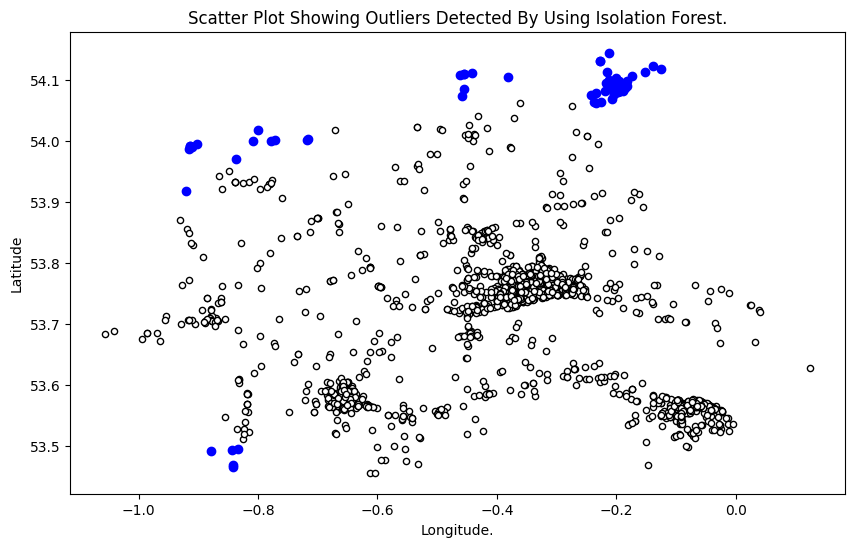

In [336]:
# # Plotting Longitude against Latitude to outliers using isolation forest.

plt.figure(figsize=(10,6))
plt.scatter(df5["longitude"], df5["latitude"], c = "white", s = 20, edgecolor = "k")
plt.scatter(if_anomalies["longitude"], if_anomalies["latitude"], c = "blue")
plt.xlabel("Longitude.")
plt.ylabel("Latitude")
plt.title("Scatter Plot Showing Outliers Detected By Using Isolation Forest.")
plt.savefig("isolation_outlier_plot_df6", dpi = 300, bbox_inches = "tight")
plt.show()

In [337]:
# Combine longitude and latitude columns to create a Point geometry column
geo_if_anomalies = [Point(lon, lat) for lon, lat in zip(if_anomalies["longitude"], if_anomalies["latitude"])]

# Create a GeoDataFrame with the original DataFrame and the Point geometries
gdf_if_anomalies = gpd.GeoDataFrame(if_anomalies, geometry = geo_if_anomalies, crs = "EPSG:4326")


In [338]:
# Load the UK map shapefile (you can download shapefiles from various sources)
uk_map = gpd.read_file("./UK_DISTRICTS_COUNTIES_CENSUS2011.shp")

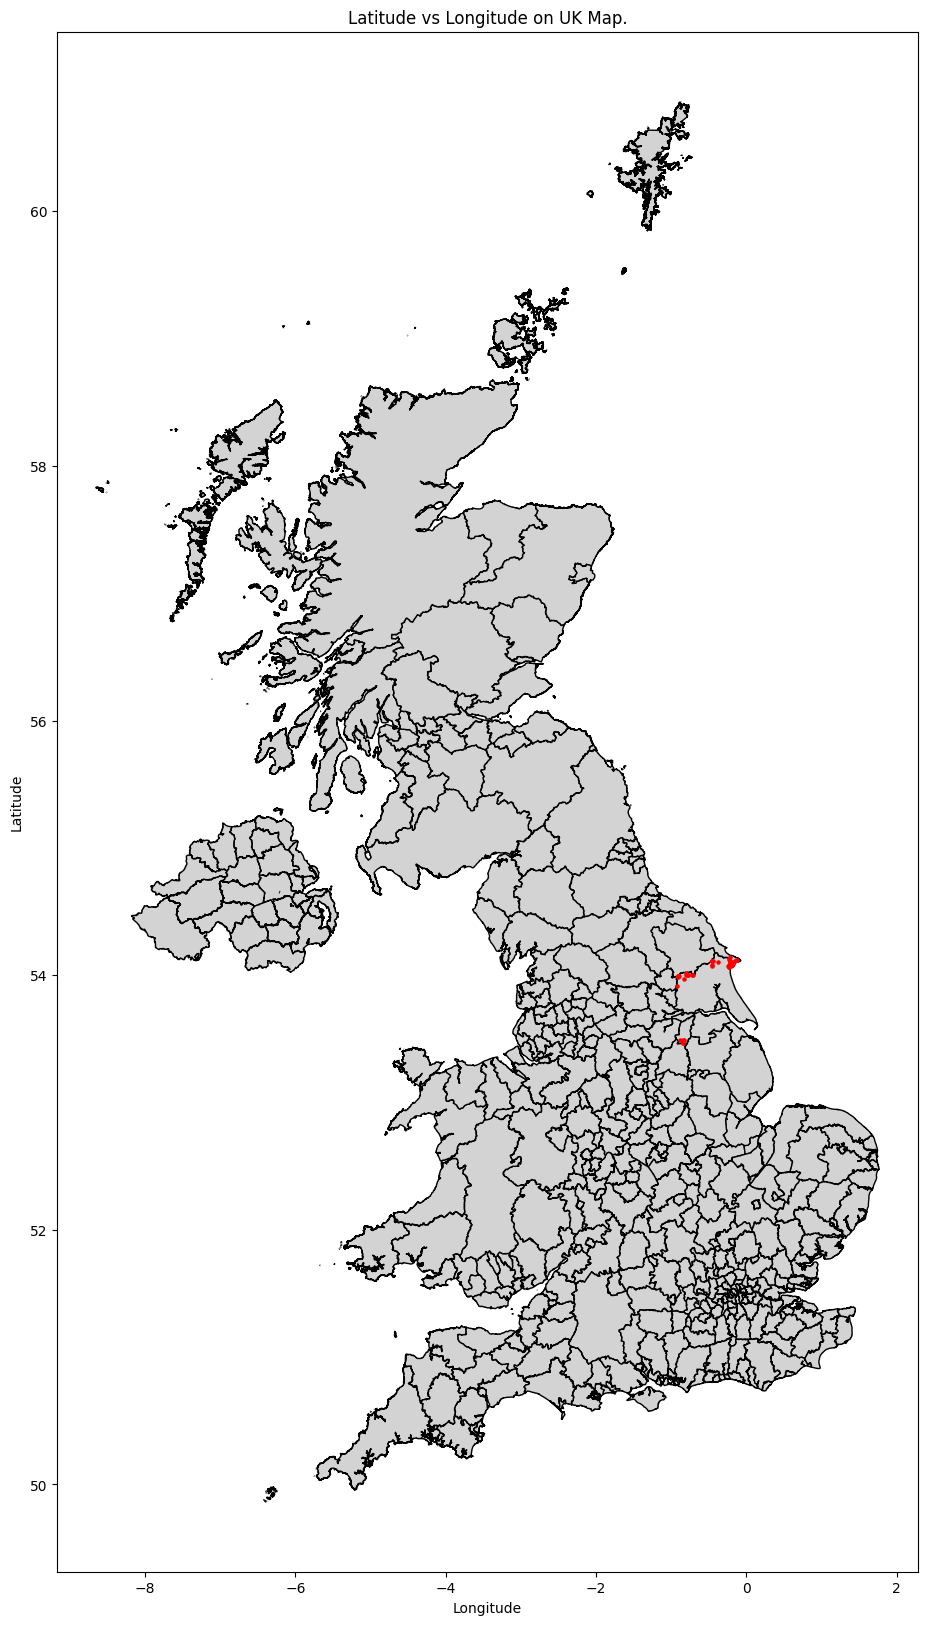

In [339]:
# Create the plot
fig, ax = plt.subplots(figsize = (20, 20))

# Plot the world map
uk_map.plot(ax = ax, color = "lightgray", edgecolor = "black")

# Plot the GeoDataFrame with latitude and longitude data on the world map
gdf_if_anomalies.plot(ax = ax, color = "red", markersize = 5)

# Add title and labels
plt.title("Latitude vs Longitude on UK Map.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("if_outlier_loc_q6", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

The Local Outlier Factor (LOF) was employed to detect outliers. The detected outliers were found to be global outliers as a plot of these data points revealed that the accidents occurred within the Humberside region (Kingston upon Hull, East Riding of Yorkshire, North Lincolnshire, and North East Lincolnshire).

Furthermore, the isolation forest technique was applied to validate the conclusions drawn from the utilization of LOF. The results were consistent and aligned with the initial findings.

In [340]:
"""
Creating a folium map (Reinking, 2023).
Source: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium
"""

folium_map_if_outliers = folium.Map(prefer_canvas=True)

def folium_plotter_if_outlier(plot):
    folium.CircleMarker(location=[plot.latitude, plot.longitude],
                        radius=2,
                        weight=5).add_to(folium_map_if_outliers)

# Iterating through every row in the dataframe.
if_anomalies.apply(folium_plotter_if_outlier, axis = 1)


# Setting the zoom to the maximum possible.
folium_map_if_outliers.fit_bounds(folium_map_if_outliers.get_bounds())

# Saving the map to an HTML file.
folium_map_if_outliers.save("./outliers_if_folium_q6.html")

### 7) Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

In [341]:
query_7 = """
SELECT *
FROM accident as a
INNER JOIN vehicle as v ON a.accident_index = v.accident_index
INNER JOIN casualty as c ON a.accident_index = c.accident_index
INNER JOIN lsoa as l ON a.lsoa_of_accident_location = l.lsoa01cd
WHERE a.accident_year = 2020
"""

df7 = pd.read_sql(query_7, con)

"""
Removing duplicate columns.
Removes duplicate columns. (Admin, 2021).
Source: https://sparkbyexamples.com/pandas/pandas-remove-duplicate-columns-from-dataframe/?expand_article=1
"""

df7 = df7.loc[:, ~df7.columns.duplicated()]
df7

accident_index  accident_year accident_reference  \
0       2020010219808           2020          010219808   
1       2020010220496           2020          010220496   
2       2020010220496           2020          010220496   
3       2020010228005           2020          010228005   
4       2020010228006           2020          010228006   
...               ...            ...                ...   
201938  202063DF01620           2020          63DF01620   
201939  202063DF01620           2020          63DF01620   
201940  202063DF01620           2020          63DF01620   
201941  202063DF01620           2020          63DF01620   
201942  202063DF01620           2020          63DF01620   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    529337.0                176237.0  -0.139253  51.470327   
2                    529337.0                176237.0  -0.139253  51.470327   
3                    526432.0                182761.0  -0.178719  51.529614   
4                    538676.0                184371.0  -0.001683  51.541210   
...                       ...                     ...        ...        ...   
201938               324280.0                259980.0  -3.110141  52.232798   
201939               324280.0                259980.0  -3.110141  52.232798   
201940               324280.0                259980.0  -3.110141  52.232798   
201941               324280.0                259980.0  -3.110141  52.232798   
201942               324280.0                259980.0  -3.110141  52.232798   

        police_force  accident_severity  number_of_vehicles  \
0                  1                  3                   1   
1                  1                  3                   1   
2                  1                  3                   1   
3                  1                  3                   1   
4                  1                  2                   1   
...              ...                ...                 ...   
201938            63                  1                   4   
201939            63                  1                   4   
201940            63                  1                   4   
201941            63                  1                   4   
201942            63                  1                   4   

        number_of_casualties        date  day_of_week   time  \
0                          1  04/02/2020            3  09:00   
1                          2  27/04/2020            2  13:55   
2                          2  27/04/2020            2  13:55   
3                          1  01/01/2020            4  01:25   
4                          1  01/01/2020            4  01:50   
...                      ...         ...          ...    ...   
201938                     6  12/12/2020            7  17:30   
201939                     6  12/12/2020            7  17:30   
201940                     6  12/12/2020            7  17:30   
201941                     6  12/12/2020            7  17:30   
201942                     6  12/12/2020            7  17:30   

        local_authority_district local_authority_ons_district  \
0                             10                    E09000032   
1                              9                    E09000022   
2                              9                    E09000022   
3                              1                    E09000033   
4                             17                    E09000025   
...                          ...                          ...   
201938                       753                    W06000023   
201939                       753                    W06000023   
201940                       753                    W06000023   
201941                       753                    W06000023   
201942                       753                    W06000023   

       local_authority_highway  first_road

In [342]:
# Checking for null values in the dataframe columns.

df7.isna().sum()

accident_index            0
accident_year             0
accident_reference        0
location_easting_osgr     0
location_northing_osgr    0
                         ..
lsoa01nm                  0
lsoa01nmw                 0
shape__area               0
shape__length             0
globalid                  0
Length: 83, dtype: int64

In [343]:
df7.duplicated().sum()

0

There are no duplicated records in the DataFrame df7. In other words, every row in the DataFrame is unique and there are no exact duplicates based on all columns.

##### Balancing and Preparing the DataFrame.

In [344]:
# Creating a series of accident severity labels, which have True for fatal accidents and False for non-fatal (serious and slight).

y_label = df7["accident_severity"] == 1

In [345]:
# Counting the values of True and False.

bool_counts = y_label.value_counts()
bool_counts

False    198271
True       3672
Name: accident_severity, dtype: int64

In [346]:
# Create a balanced dataset using the RandomUnderSampler.

df7_acc_balanced, y_balanced = RandomUnderSampler().fit_resample(df7, y_label)

In [347]:
df7_acc_balanced["accident_severity"].unique()

array([3, 2, 1], dtype=int64)

In [348]:
df7_acc_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 83 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               7344 non-null   object 
 1   accident_year                                7344 non-null   int64  
 2   accident_reference                           7344 non-null   object 
 3   location_easting_osgr                        7344 non-null   float64
 4   location_northing_osgr                       7344 non-null   float64
 5   longitude                                    7344 non-null   float64
 6   latitude                                     7344 non-null   float64
 7   police_force                                 7344 non-null   int64  
 8   accident_severity                            7344 non-null   int64  
 9   number_of_vehicles                           7344 non-null   int64  
 10  

In [349]:
# Creating a copy of the balanced dataset.

df7_cc = df7_acc_balanced.copy()

In [350]:
"""
Creating a datatime object from the time dataseries. 
(How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish, n.d.)
"""

df7_cc_time_ds = obj_time(df7_cc, "time", "%H:%M") 

In [351]:
# Extracting the hours from the datetime object. Inorder to retain the hours of the accident.

df7_cc["hour"]= hr_extract(df7_cc_time_ds)

In [352]:
# Replacing serious and slight accident severity with 0, because our classification is binary.

df7_cc["accident_severity"].replace([2, 3], 0, inplace=True)

In [353]:
# Reducing the number of columns in the DataFrame by retaining only columns that are of number type.

df7_cc = df7_cc.select_dtypes([np.number])

In [354]:
# Moving accident_severity column to become the first column in the DataFrame.

column_to_move = df7_cc.pop("accident_severity")
df7_cc.insert(0, "accident_severity", column_to_move)

In [355]:
del df7_cc["location_easting_osgr"]
del df7_cc["location_northing_osgr"]
del df7_cc["longitude"]
del df7_cc["latitude"]

In [356]:
df7_cc

accident_severity  accident_year  police_force  number_of_vehicles  \
0                     0           2020            31                   4   
1                     0           2020            20                   2   
2                     0           2020            14                   2   
3                     0           2020            14                   2   
4                     0           2020            41                   3   
...                 ...            ...           ...                 ...   
7339                  1           2020            63                   4   
7340                  1           2020            63                   4   
7341                  1           2020            63                   4   
7342                  1           2020            63                   4   
7343                  1           2020            63                   4   

      number_of_casualties  day_of_week  local_authority_district  \
0                        2            7                       346   
1                        2            3                       309   
2                        1            6                       211   
3                        1            7                       213   
4                        2            3                       431   
...                    ...          ...                       ...   
7339                     6            7                       753   
7340                     6            7                       753   
7341                     6            7                       753   
7342                     6            7                       753   
7343                     6            7                       753   

      first_road_class  first_road_number  road_type  speed_limit  \
0                    3                 60          6           30   
1                    6                  0          6           30   
2                    1                 18          1           70   
3                    6                  0          6           30   
4                    3               4251          6           30   
...                ...                ...        ...          ...   
7339                 3                 44          6           60   
7340                 3                 44          6           60   
7341                 3                 44          6           60   
7342                 3                 44          6           60   
7343                 3                 44          6           60   

      junction_detail  junction_control  second_road_class  \
0                   6                 2                  6   
1                   9                 2                  3   
2                   1                 2                  2   
3                   0                -1                  0   
4                   3                 4                  6   
...               ...               ...                ...   
7339                0                -1                  0   
7340                0                -1                  0   
7341                0                -1                  0   
7342                0                -1                  0   
7343                0                -1                  0   

      second_road_number  pedestrian_crossing_human_control  \
0                      0                                  0   
1                   4150                                  0   
2                      1                                  0   
3                     -1                                  0   
4                      0                                  0   
...                  ...                                ...   
7339                  -1                                  0   
7340                  -1                                  0   
7341                  -1                                  0   
7342                  -1                                  0 

In [357]:
df7_cc.replace(-1, np.nan, inplace=True)

#### Multiple Imputation Using Chain Equations (MICE)

MICE would generate and impute estimated values for all missing records (NaN) in the dataframe.

In [358]:
# Creating a copy of dataframe df7_cc.
df7_cc2 = df7_cc.copy()

In [359]:
# Executing MICE.

df7_cc2 = mice_exec(df7_cc2, 3)

In [360]:
# Creating the features and the target variables for classification problem.

Xdata = df7_cc2.iloc[:, 1:68]
ydata = df7_cc2.iloc[:, 0]

In [361]:
Xdata_new =\
    SelectKBest(score_func=chi2, 
                k=20).fit_transform(Xdata, ydata)

In [362]:
selected_indices = SelectKBest(score_func=chi2, k=20).fit(Xdata, ydata).get_support()
selected_column_names = Xdata.columns[selected_indices]
print(selected_column_names)

Index(['police_force', 'local_authority_district', 'first_road_number',
       'speed_limit', 'junction_detail', 'second_road_class',
       'second_road_number', 'vehicle_index', 'vehicle_manoeuvre',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'engine_capacity_cc', 'casualty_index', 'age_of_casualty',
       'casualty_severity', 'objectid', 'shape__area', 'shape__length'],
      dtype='object')


In [363]:
df7_cc3 = df7_cc2.loc[:, ["accident_severity"]].copy()

In [364]:
for df7_col in selected_column_names:
    df7_cc3[df7_col] = df7_cc2[df7_col].copy()

In [365]:
df7_cc3

accident_severity  police_force  local_authority_district  \
0                     0            31                     346.0   
1                     0            20                     309.0   
2                     0            14                     211.0   
3                     0            14                     213.0   
4                     0            41                     431.0   
...                 ...           ...                       ...   
7339                  1            63                     753.0   
7340                  1            63                     753.0   
7341                  1            63                     753.0   
7342                  1            63                     753.0   
7343                  1            63                     753.0   

      first_road_number  speed_limit  junction_detail  second_road_class  \
0                    60           30                6                6.0   
1                     0           30                9                3.0   
2                    18           70                1                2.0   
3                     0           30                0                0.0   
4                  4251           30                3                6.0   
...                 ...          ...              ...                ...   
7339                 44           60                0                0.0   
7340                 44           60                0                0.0   
7341                 44           60                0                0.0   
7342                 44           60                0                0.0   
7343                 44           60                0                0.0   

      second_road_number  vehicle_index  vehicle_manoeuvre  \
0                    0.0         773099               18.0   
1                 4150.0         756326               18.0   
2                    1.0         749225                7.0   
3                  188.0         748321               18.0   
4                    0.0         789907                2.0   
...                  ...            ...                ...   
7339               312.0         842507               16.0   
7340               212.0         842507               16.0   
7341               406.0         842507               16.0   
7342              1093.0         842507               16.0   
7343               676.0         842507               16.0   

      vehicle_location_restricted_lane  junction_location  \
0                                  0.0                8.0   
1                                  0.0                1.0   
2                                  0.0                3.0   
3                                  0.0                0.0   
4                                  0.0                2.0   
...                                ...                ...   
7339                               0.0                0.0   
7340                               0.0                0.0   
7341                               0.0                0.0   
7342                               0.0                0.0   
7343                               0.0                0.0   

      hit_object_in_carriageway  hit_object_off_carriageway  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
...                         ...                         ...   
7339                        0.0                         0.0   
7340                        0.0                         0.0   
7341                        0.0                         0.0   
7342                        0.0                         0.0   
7343                        0.0                         0.0   

      engine_capacity_cc  casualty_index  age_of_casu

In [366]:
y_target = df7_cc3["accident_severity"].values
Xfeatures = df7_cc3.drop("accident_severity", axis=1)

In [367]:
X_train, X_test, y_train, y_test =\
    train_test_split(Xfeatures, y_target,
                    test_size=0.25, random_state=1)

In [368]:
dtree = DecisionTreeClassifier(criterion="gini")

In [369]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [370]:
Y_pred = dtree.predict(X_test)

In [371]:
acc_dtree = round(dtree.score(X_train, y_train) * 100,
                 2)

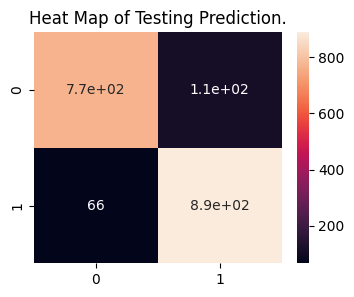

In [372]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, Y_pred), 
            annot=True)
plt.title("Heat Map of Testing Prediction.")
plt.savefig("test_pred_heat", dpi=300, bbox_inches='tight')
plt.show()

In [373]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       881
           1       0.89      0.93      0.91       955

    accuracy                           0.90      1836
   macro avg       0.90      0.90      0.90      1836
weighted avg       0.90      0.90      0.90      1836



In [374]:
df_importance = pd.DataFrame(np.array([dtree.feature_names_in_, 
                                       dtree.feature_importances_]
                                     ).T,
                             columns=["Feature", "Importance"]
                            )

In [375]:
df_importance.sort_values("Importance", ascending=False)

Feature Importance
16                 casualty_severity   0.483722
3                        speed_limit   0.078763
14                    casualty_index   0.047103
2                  first_road_number   0.046554
15                   age_of_casualty   0.045343
18                       shape__area    0.04369
19                     shape__length   0.040142
17                          objectid   0.039785
13                engine_capacity_cc   0.033566
7                      vehicle_index   0.028101
6                 second_road_number   0.020079
1           local_authority_district   0.017617
10                 junction_location   0.017388
8                  vehicle_manoeuvre   0.015421
12        hit_object_off_carriageway   0.010338
4                    junction_detail   0.010235
0                       police_force   0.007694
5                  second_road_class   0.007461
11         hit_object_in_carriageway    0.00396
9   vehicle_location_restricted_lane   0.003039

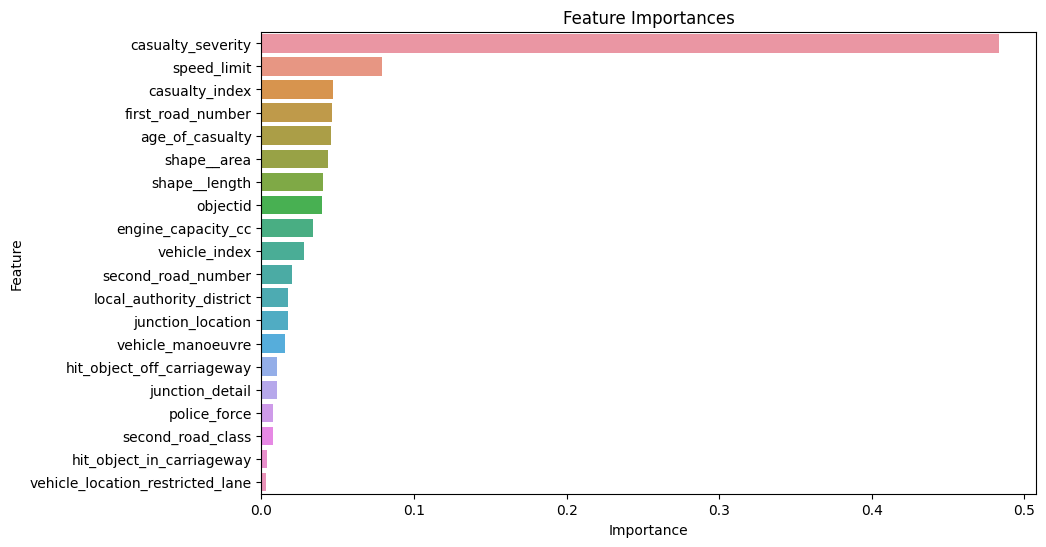

In [376]:
plt.figure(figsize=(10,6))
df_importance_sorted = df_importance.sort_values(by="Importance", ascending=False)
sns.barplot(x = df_importance_sorted["Importance"],
           y = df_importance_sorted["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.savefig("feature_importance", dpi=300, bbox_inches='tight')
plt.show()

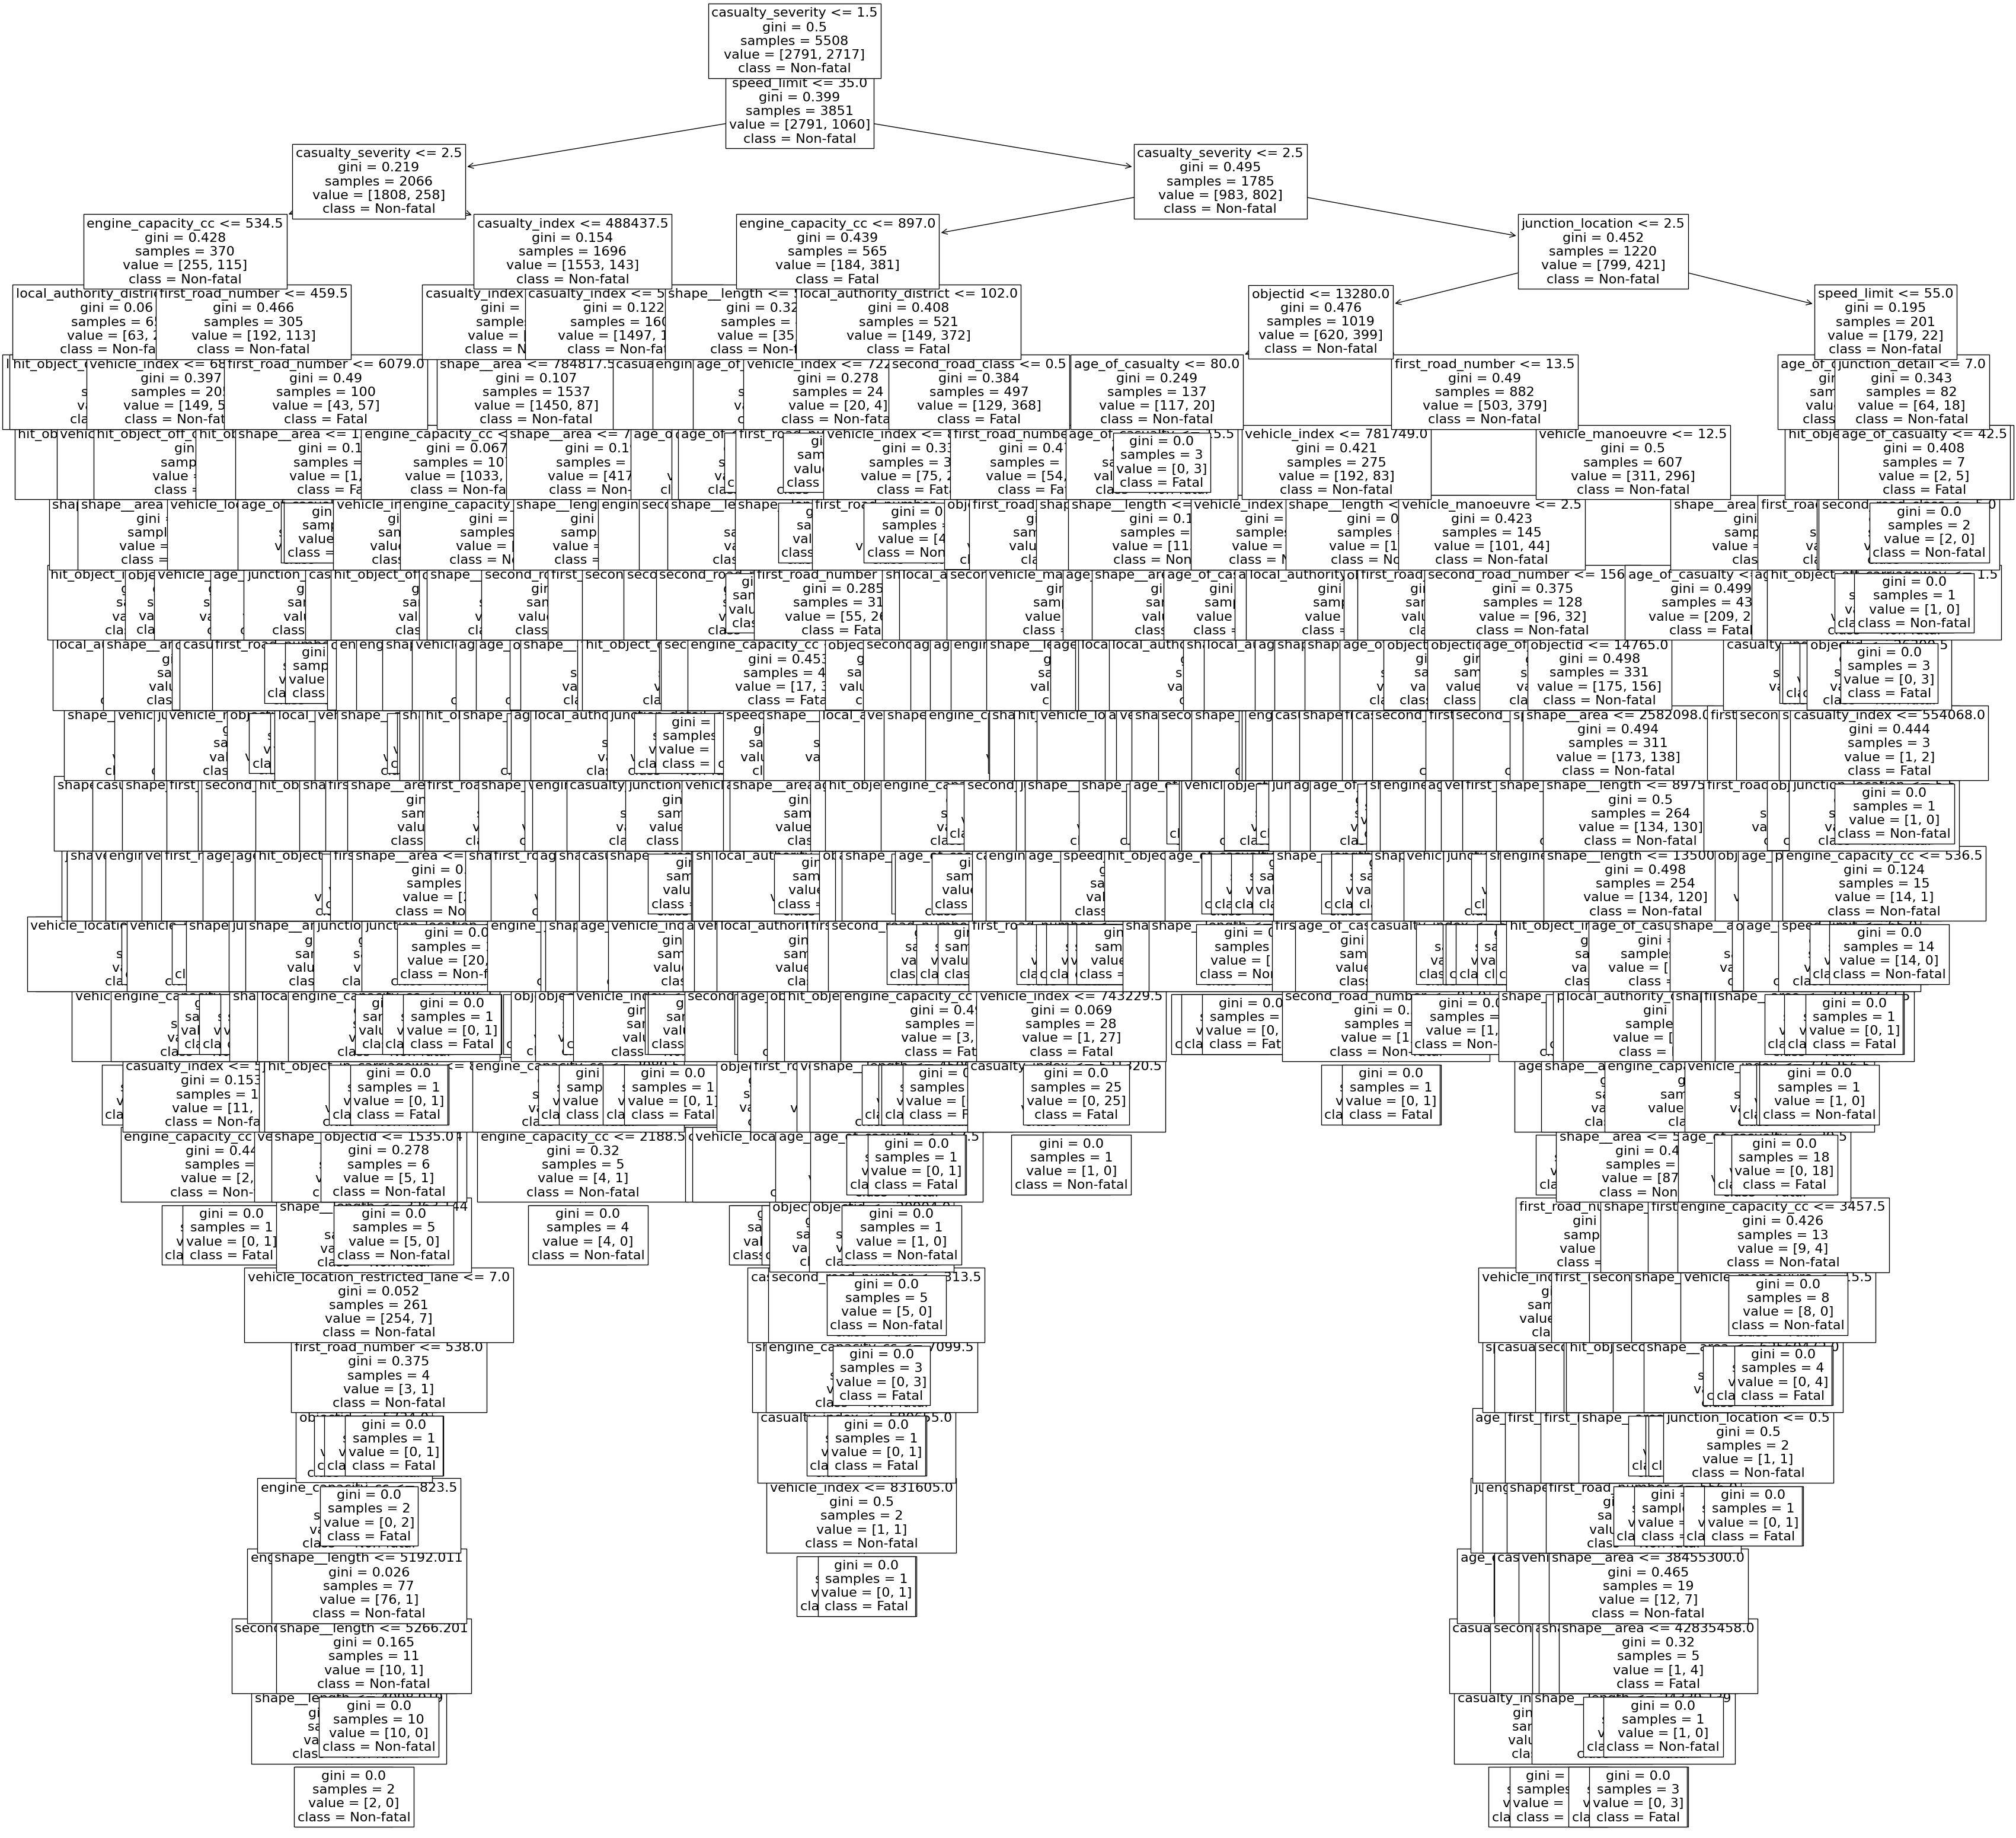

In [377]:
plt.figure(figsize=(40,40))
plot_tree(dtree, feature_names=dtree.feature_names_in_, 
          class_names=["Non-fatal", "Fatal"], fontsize=16)
plt.savefig("decision_1", dpi=300, bbox_inches='tight')
plt.show()

In [378]:
new_train = X_train.drop(["junction_location", "junction_detail", "vehicle_location_restricted_lane", 
                          "hit_object_in_carriageway", "police_force"],
                        axis=1)

In [379]:
new_test = X_test.drop(["junction_location", "junction_detail", "vehicle_location_restricted_lane", 
                          "hit_object_in_carriageway", "police_force"],
                        axis=1)

In [380]:
y_target_2 = df7_cc3["accident_severity"].values
Xfeatures_2 = df7_cc3.drop(["accident_severity", "junction_location", "junction_detail", "vehicle_location_restricted_lane", 
                          "hit_object_in_carriageway", "police_force"], axis=1)

In [381]:
X_train2, X_test2, y_train2, y_test2 =\
    train_test_split(Xfeatures_2, y_target_2,
                    test_size=0.25, random_state=1)

In [382]:
dtree2 = DecisionTreeClassifier(criterion="gini")

In [383]:
dtree2.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [384]:
Y_pred2 = dtree2.predict(X_test2)

In [385]:
acc_dtree2 = round(dtree2.score(X_train2, y_train2) * 100,
                 2)

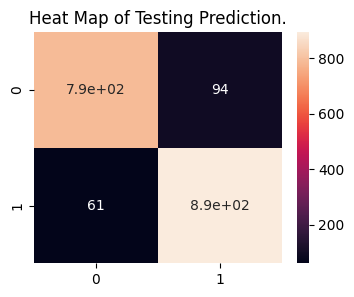

In [386]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test2, Y_pred2), 
            annot=True)
plt.title("Heat Map of Testing Prediction.")
plt.savefig("test_pred_heat2", dpi=300, bbox_inches='tight')
plt.show()

In [387]:
print(classification_report(y_test2, Y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       881
           1       0.90      0.94      0.92       955

    accuracy                           0.92      1836
   macro avg       0.92      0.91      0.92      1836
weighted avg       0.92      0.92      0.92      1836



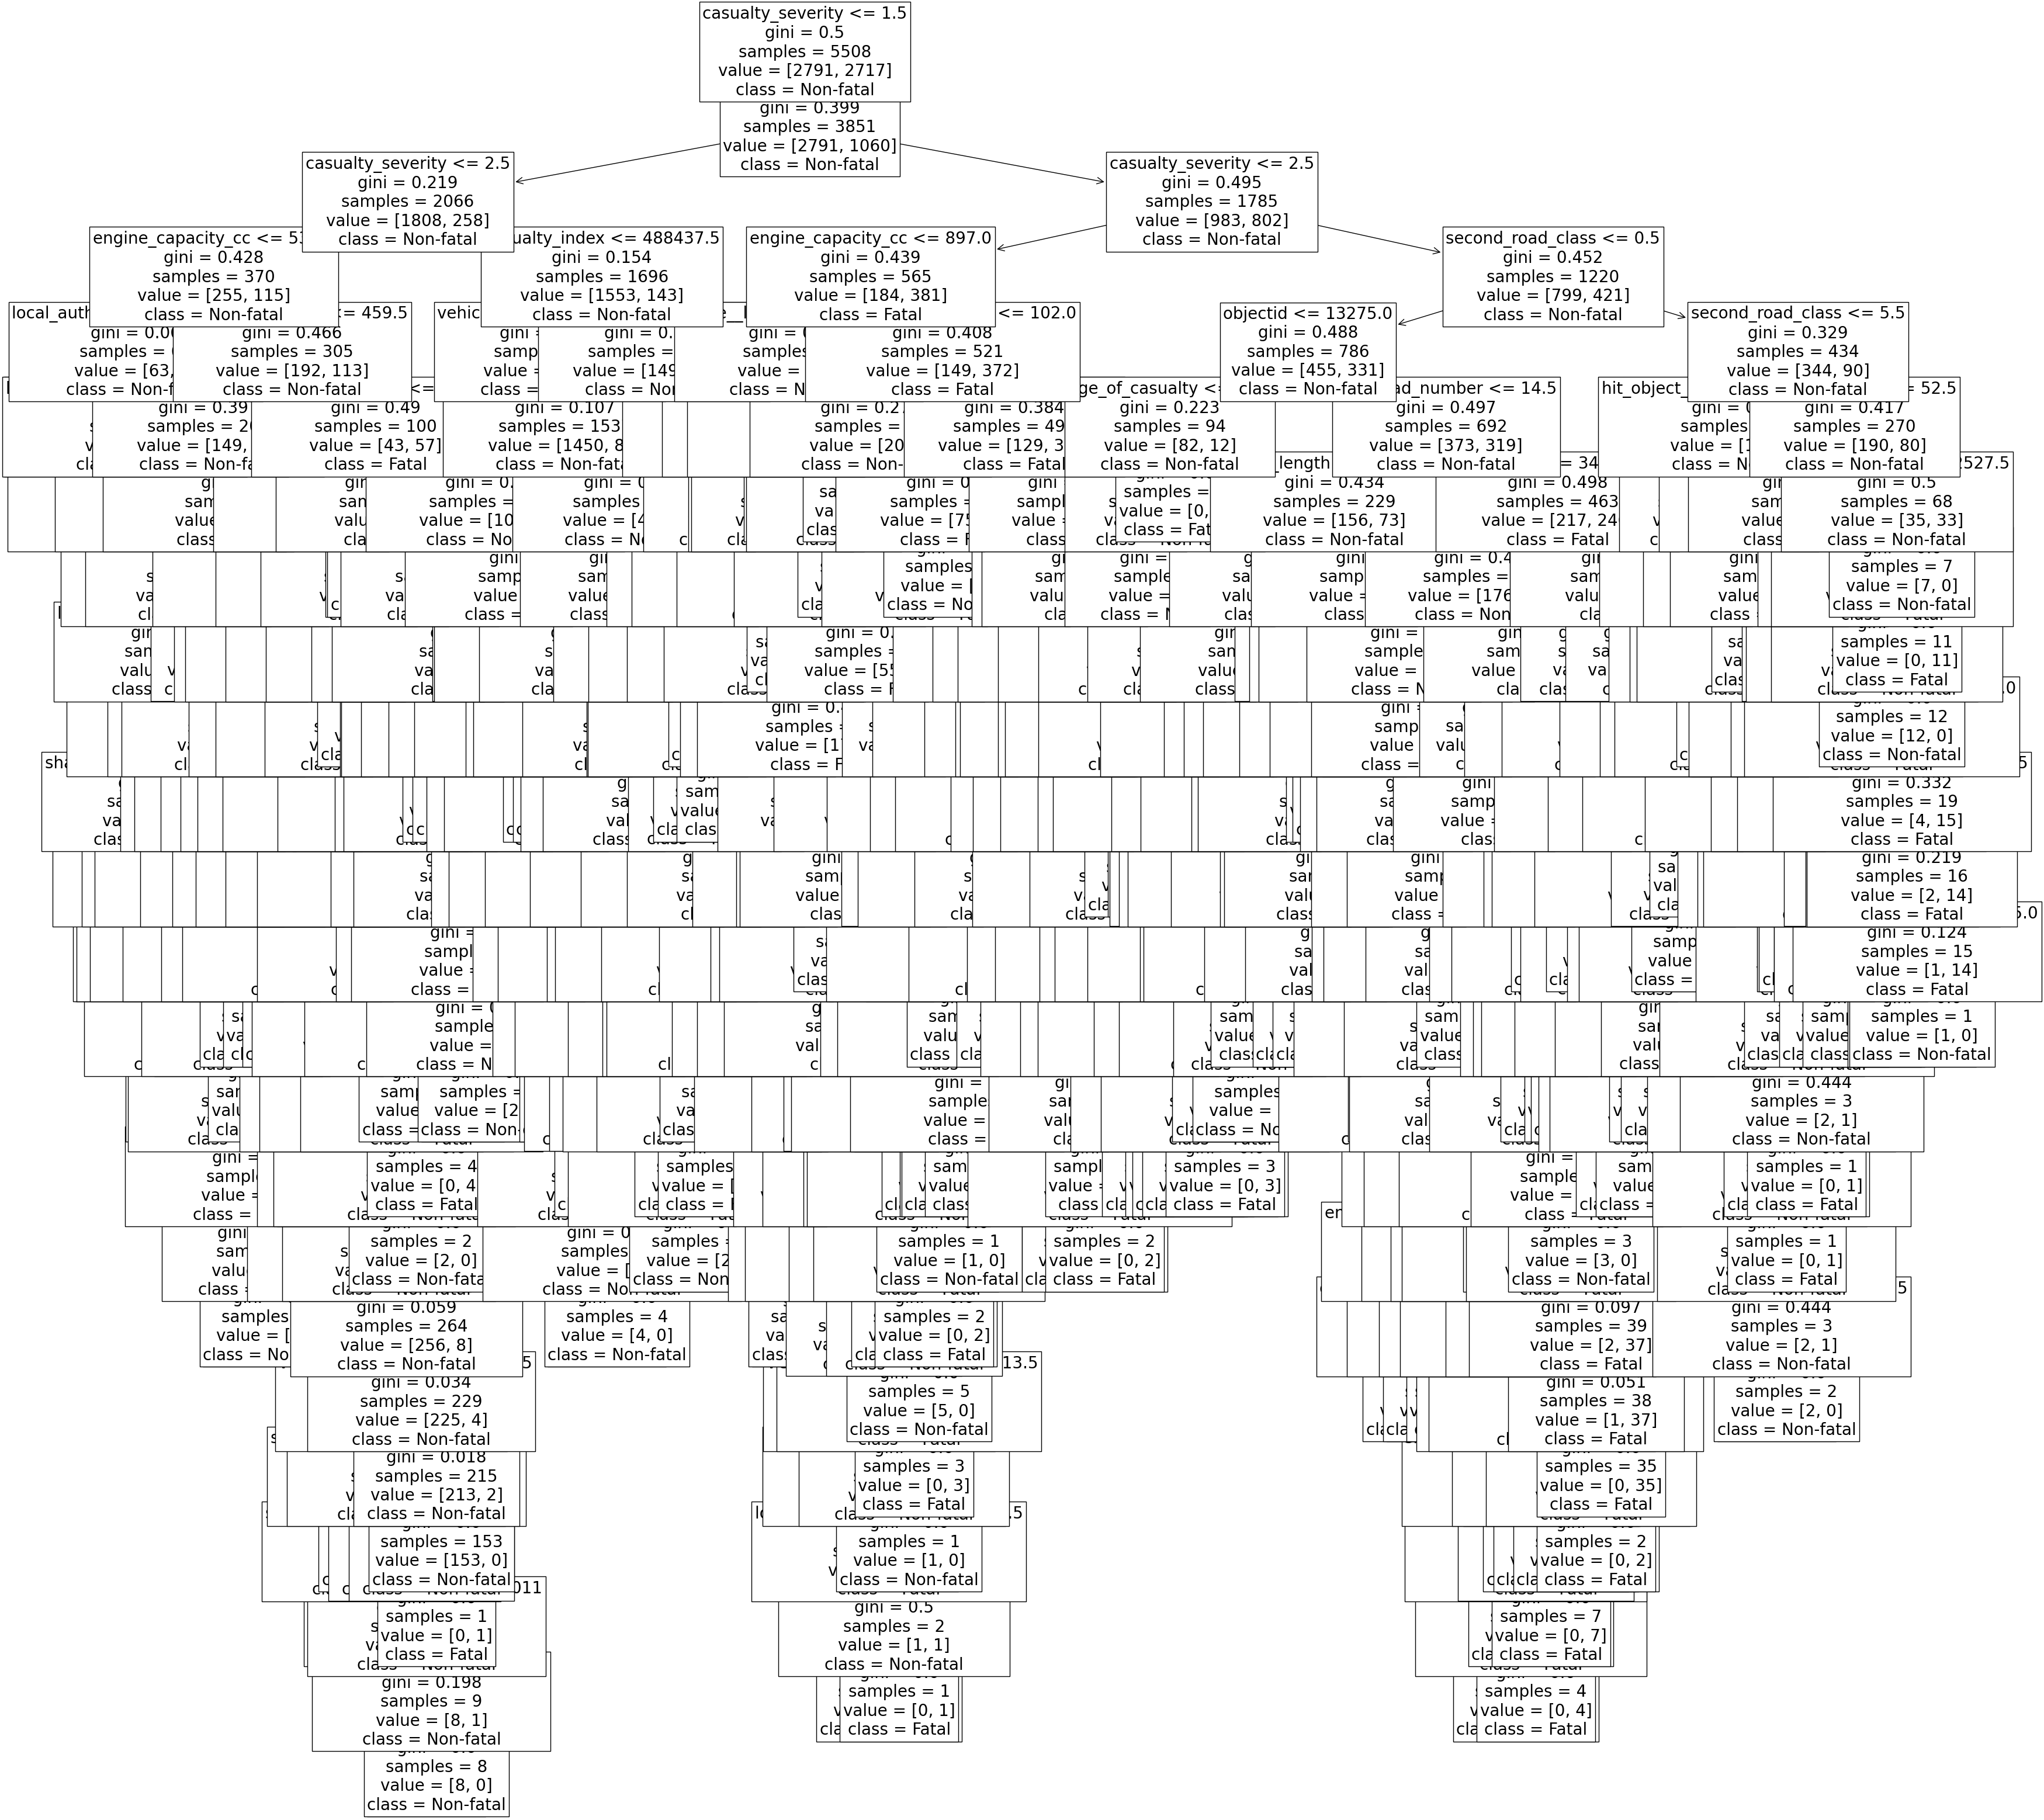

In [388]:
plt.figure(figsize=(40,40))
plot_tree(dtree2, feature_names=dtree2.feature_names_in_, 
          class_names=["Non-fatal", "Fatal"], fontsize=20)
plt.savefig("decision_2", dpi=300, bbox_inches='tight')
plt.show()

## Closing connection to the database.

In [389]:
con.close()

## References

How to Convert Strings to Datetime in Pandas DataFrame – Data to Fish. (n.d.) datatofish.com. Available online: https://datatofish.com/strings-to-datetime-pandas/ [Accessed 1 Aug. 2023].

How to extract the time only from pandas datetime objects? (n.d.) www.easytweaks.com. Available online: https://www.easytweaks.com/get-time-only-pandas-datetime/ [Accessed 1 Aug. 2023].

Pandas Map, Explained - Sharp Sight. (2022) www.sharpsightlabs.com. Available online: https://www.sharpsightlabs.com/blog/pandas-map-explained/ [Accessed 1 Aug. 2023].

Kernel Density Estimation in Python | Pythonic Perambulations. (n.d.) jakevdp.github.io. Available online: http://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/ [Accessed 2 Aug. 2023].

Google (2023) Google Maps. Google Maps. Available online: https://www.google.com/maps.

Historical weather data for axbridge | Visual Crossing. (n.d.) www.visualcrossing.com. Available online: https://www.visualcrossing.com/weather-history/axbridge/metric/2020-06-24/2020-06-25 [Accessed 3 Aug. 2023].

Keita, Z. (2023) Top Techniques to Handle Missing Values Every Data Scientist Should Know. Datacamp. Available online: https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values [Accessed 4 Aug. 2023].

Reinking, C. (2023) collinreinking/longitude_latitude_dot_plots_in_python_with_folium. GitHub. Available online: https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium [Accessed 5 Aug. 2023].

Display the Pandas DataFrame in Heatmap style. (2020) GeeksforGeeks. Available online: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/.

Admin (2021) How to Drop Duplicate Columns in pandas DataFrame. Spark By {Examples}. Available online: https://sparkbyexamples.com/pandas/pandas-remove-duplicate-columns-from-dataframe/?expand_article=1 [Accessed 1 Aug. 2023].

GOV.UK. (n.d.). Reported road casualties in Great Britain: notes, definitions, symbols and conventions. [online] Available at: https://www.gov.uk/government/publications/road-accidents-and-safety-statistics-notes-and-definitions/reported-road-casualties-in-great-britain-notes-definitions-symbols-and-conventions.

webarchive.nationalarchives.gov.uk. (n.d.). UK Government Web Archive. [online] Available at: https://webarchive.nationalarchives.gov.uk/ukgwa/20110503151558/http://dft.gov.uk/pgr/statistics/committeesusergroups/scras/2008reviewstats19/reviewreport.pdf.

Department for Transport (2021) STATS19 forms and guidance. GOV.UK. Available online: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/995422/stats19.pdf [Accessed 10/8/20232].

Department for Transport (2011) STATS20 Instructions for the Completion of Road Accident Reports from non-CRASH Sources. GOV.UK. Available online: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/995423/stats20-2011.pdf [Accessed 10/8/20232].